In [1]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential, load_model
from scipy import stats
from keras.layers import Dense
from keras.layers import LSTM
import numpy as np
from pytz import timezone
from collections import deque
import MySQLdb
import time
from websocket_server import WebsocketServer
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.offline as py
import Queue
import logging
est = timezone('US/Eastern')

Using TensorFlow backend.


In [2]:
btc = pd.read_csv('binance-data.csv')
twitter_sent = pd.read_csv('live_tweet.csv')
reddit_sent = pd.read_csv('live_reddit.csv')

btc.columns = ["Price","Volume", "Number_Trades", "Market_Cap","Supply", "Stamp"]
twitter_sent.columns = ["Sentiment", "Stamp"]
reddit_sent.columns = ["Sentiment", "Stamp"]

merged = pd.merge(twitter_sent, btc,  on='Stamp', how='inner').merge(reddit_sent, on='Stamp', how='inner')
data = merged[["Sentiment_x", "Sentiment_y","Volume", "Market_Cap", "Supply", "Number_Trades", "Price"]].groupby(merged['Stamp']).mean()
datag = data[["Volume", "Market_Cap", "Supply", "Number_Trades", "Price"]]
tw_sentiment = data["Sentiment_x"]
rdt_sentiment = data["Sentiment_y"]

print "Dataset size: " + str(len(datag))
print "Timespan: " + str(len(datag)/60) + " hours"

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
values = datag.values.reshape(-1, datag.shape[1])
tw_sentiment = tw_sentiment.values.reshape(-1, 1)
rdt_sentiment = rdt_sentiment.values.reshape(-1, 1)
tw_sentiment = tw_sentiment.astype('float32')
rdt_sentiment = rdt_sentiment.astype('float32')
values = values.astype('float32')
scaled = scaler.fit_transform(values)

Dataset size: 25651
Timespan: 427 hours


17951
7692


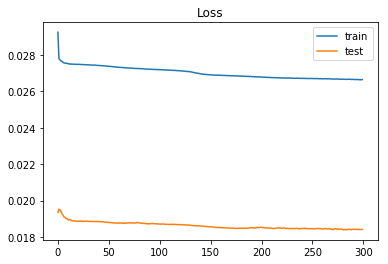

Test RMSE: 0.039


In [5]:
train_size = int(len(scaled) * 0.7)
test_size = len(scaled) - train_size
train, test = scaled[0:train_size,:], scaled[train_size:len(scaled),:]
split = train_size

def create_dataset(dataset, look_back, tw_sentiment, rdt_sentiment, sent=False):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        if i >= look_back:
            a = dataset[i-look_back:i+1, 0]
            a = a.tolist()
            if(sent==True):                
                current_tw_sentiment = tw_sentiment[i].tolist()[0]
                current_rdt_sentiment = rdt_sentiment[i].tolist()[0]
                a.append(current_tw_sentiment)
                a.append(current_rdt_sentiment)
            dataX.append(a)
            dataY.append(dataset[i + look_back, 0])
    print(len(dataY))
    return np.array(dataX), np.array(dataY)

look_back = 2
trainX, trainY = create_dataset(train, look_back, tw_sentiment[0:train_size], rdt_sentiment[0:train_size], sent=True)
testX, testY = create_dataset(test, look_back, tw_sentiment[train_size:len(scaled)], rdt_sentiment[train_size:len(scaled)], sent=True)

trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

# Creating new model
model = Sequential()
model.add(LSTM(100, input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(100))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
model.save('models/LSTM_Philip_V5_{0}'.format(datetime.now()) + '.h5')

# Loading model
# model = load_model('models/LSTM_12-03-2018_GOOD.h5')

history = model.fit(trainX, trainY, epochs=300, batch_size=100, validation_data=(testX, testY), verbose=0, shuffle=False)
yhat = model.predict(testX)
rmse_sent = sqrt(mean_squared_error(testY, yhat))

pyplot.title("Loss")
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

print('Test RMSE: %.3f' % rmse_sent)

In [5]:
true_q = Queue.Queue()
pred_q = Queue.Queue()

def process_data(in_data):
    out_data = []
    for line in in_data:
        out_data.append(float(line.split(',')[0]))
    return np.array(out_data).reshape(-1,1)

In [ ]:
diffs = deque([], maxlen=200)
lows = []
tops = []
top_lows = deque([], maxlen=30)
top_tops = deque([], maxlen=30)
prev = 6579
minute_ = 0
current_diff = None
top_diff = None
low_diff = None


def data_requested(client, server, message):
    if top_diff is not None and low_diff is not None and current_diff is not None:
        
        if current_diff < top_diff:
            server.send_message(client, "Buy")
            
        # If difference is greater than the average low in the top_lows list -> SELL
        elif current_diff > low_diff:
            server.send_message(client, "Sell")
        
        else:
            server.send_message(client, "Chill")
            
    else:
        server.send_message(client, "No data available yet")
    
server = WebsocketServer(5580, host='127.0.0.1', loglevel=logging.INFO)
server.set_fn_message_received(data_requested)

import threading

threading.Thread(target=server.run_forever).start()

while True:
    # Processing data
    minute_ = minute_ + 1
    btc = open('binance-data.csv','r')
    tw_sent = open('live_tweet.csv','r')
    rdt_sent = open('live_reddit.csv','r')
    bit_data = btc.readlines()
    tw_sent_data = tw_sent.readlines()
    rdt_sent_data = rdt_sent.readlines()
    bit_data = process_data(bit_data[len(bit_data)-5:])
    tw_sent_data = process_data(tw_sent_data[len(tw_sent_data)-5:])
    rdt_sent_data = process_data(rdt_sent_data[len(rdt_sent_data)-5:])

    # Last price recieved
    real_price = bit_data[len(bit_data) - 1][0]

    # Scaling prices
    live = scaler.fit_transform(bit_data)

    # Creating datasets and making prediction
    testX, testY = create_dataset(live, 2, tw_sent_data, rdt_sent_data, sent=True)
    testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
    yhat = model.predict(testX)

    #Re scaling prices
    yhat_inverse = scaler.inverse_transform(yhat.reshape(-1, 1))

    # Save real price and prediction price
    true_q.put(bit_data[4])
    pred_q.put(yhat_inverse[0])

    # Diference between real price and prediction
    alpha_diff = 100 * ((yhat_inverse[0][0] - float(real_price))/float(real_price))
    diffs.append(alpha_diff)
    diff_analisis = stats.describe(diffs)

    print "#######################################"
    print "Minute: ", minute_
    print "#######################################"
    print "Diff analysis ", diff_analisis
    print "#######################################"
    print "########---> Initial values <---#######"
    print "#######################################"
    print "Pred: " + str(yhat_inverse[0][0])
    print "Real price: " + str(real_price)
    print "Diff: " + str(alpha_diff)

    if(len(diffs) >= 200):

        # Sorting all diffs
        sorted_diffs = sorted(diffs)
        # Taking the highest 75 (most negative)
        tops = sorted_diffs[0:50]
        # Taking the lowest 75 (most positive)
        lows = sorted_diffs[-50:]
        # Analyzing lists
        low_analisis = stats.describe(lows)
        top_analisis = stats.describe(tops)

        # Getting averages of tops and lows
        top_threshold = top_analisis.mean
        low_threshold = low_analisis.mean

        print "#######################################"
        print "######---> Averages (Phase 2) <---#####"
        print "#######################################"
        print "Average low: " + str(low_threshold)
        print "Average top: " + str(top_threshold)
        print "#######################################"
        print "#######################################"
        print "Top analysis", top_analisis
        print "#######################################"
        print "#######################################"
        print "Low analysis", low_analisis
        print "#######################################"
        print "#######################################"
        print "Low length", len(top_lows)
        print "Top length", len(top_tops)
        print "#######################################"
        print "#######################################"
        print "Low break: ", alpha_diff > low_threshold
        print "#######################################"
        print "Top break: ", alpha_diff < top_threshold 

        # If diff is greater than the average low
        if(alpha_diff > low_threshold):
            # Adding to top_lows list
            top_lows.append(alpha_diff)
            # Sorting
            sorted_lows = sorted(top_lows)
            top_lows = deque(sorted_lows, maxlen=30)

        # If diff is lower than the average high
        if(alpha_diff < top_threshold):
            # Adding to top_tops list
            top_tops.append(alpha_diff)            
            # Sorting 
            sorted_tops = sorted(top_tops)
            top_tops = deque(sorted_tops, maxlen=30)

        if(len(top_tops) >= 30 and len(top_lows) >= 30):
            # Analyzing top_tops and top_lows
            alpha_top_analisis = stats.describe(top_tops)
            alpha_low_analisis = stats.describe(top_lows)

            # Getting averages of top_tops and top_lows analisis
            alpha_top = alpha_top_analisis.mean
            alpha_low = alpha_low_analisis.mean

            current_diff = alpha_diff
            top_diff = alpha_top
            low_diff = alpha_low

            print "####################################"
            print "####---> Signals (Phase 3) <---#####"
            print "Buy: " + str(alpha_top - alpha_top_analisis.variance)
            print "####################################"
            print "Sell: " + str(alpha_low)
    time.sleep(60)

INFO:websocket_server.websocket_server:Listening on port 5580 for clients..


1
#######################################
Minute:  1
#######################################
Diff analysis  DescribeResult(nobs=1, minmax=(0.027655056501001651, 0.027655056501001651), mean=0.027655056501001651, variance=nan, skewness=0.0, kurtosis=-3.0)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6577.81
Real price: 6575.99
Diff: 0.027655056501
1
#######################################
Minute:  2
#######################################
Diff analysis  DescribeResult(nobs=2, minmax=(0.022409638863305097, 0.027655056501001651), mean=0.025032347682153372, variance=1.3757203096929049e-05, skewness=2.0174500631512193e-15, kurtosis=-2.0)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6579.45
Real price: 6577.98
Diff: 0.0224096388633
1
#######################################
Minute:  3
#######################################
Diff analy

1
#######################################
Minute:  8
#######################################
Diff analysis  DescribeResult(nobs=8, minmax=(-0.13058650104403949, 0.027655056501001651), mean=-0.052338968879990656, variance=0.0033424667286386972, skewness=0.2504861885812805, kurtosis=-1.269042213278544)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6583.9
Real price: 6585.12
Diff: -0.0185206856519
1
#######################################
Minute:  9
#######################################
Diff analysis  DescribeResult(nobs=9, minmax=(-0.13058650104403949, 0.027655056501001651), mean=-0.047899653736465431, variance=0.0031020260580506519, skewness=0.037937828240349115, kurtosis=-1.287518869370826)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6585.17
Real price: 6585.99
Diff: -0.0123851325883
1
#######################################

1
#######################################
Minute:  26
#######################################
Diff analysis  DescribeResult(nobs=26, minmax=(-0.23970508607711644, 0.082216908269961975), mean=-0.060200158731348825, variance=0.0083298699351732099, skewness=-0.5366859068568193, kurtosis=-0.4380647905928603)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6580.27
Real price: 6579.69
Diff: 0.00881530180374
1
#######################################
Minute:  27
#######################################
Diff analysis  DescribeResult(nobs=27, minmax=(-0.23970508607711644, 0.082216908269961975), mean=-0.060318110354837529, variance=0.008009865962089989, skewness=-0.542843608121772, kurtosis=-0.3427053368396016)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6580.79
Real price: 6584.96
Diff: -0.0633848525655
1
##################################

1
#######################################
Minute:  43
#######################################
Diff analysis  DescribeResult(nobs=43, minmax=(-0.23970508607711644, 0.082216908269961975), mean=-0.052940314724359214, variance=0.0065844502227624998, skewness=-0.5842630967998529, kurtosis=-0.09907357630825775)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6582.42
Real price: 6585.99
Diff: -0.0541330204343
1
#######################################
Minute:  44
#######################################
Diff analysis  DescribeResult(nobs=44, minmax=(-0.23970508607711644, 0.082216908269961975), mean=-0.05089112143567634, variance=0.0066160879713087796, skewness=-0.6108609283015675, kurtosis=-0.10078649494248282)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6582.67
Real price: 6580.22
Diff: 0.0372241899777
1
################################

1
#######################################
Minute:  61
#######################################
Diff analysis  DescribeResult(nobs=61, minmax=(-0.26453788124188338, 0.14760276029987435), mean=-0.061300250073150181, variance=0.0085078923512598367, skewness=-0.2992332775906368, kurtosis=-0.38508438706379033)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6576.65
Real price: 6579.99
Diff: -0.0507465983041
1
#######################################
Minute:  62
#######################################
Diff analysis  DescribeResult(nobs=62, minmax=(-0.26453788124188338, 0.14760276029987435), mean=-0.060721161850169653, variance=0.0083892099826968908, skewness=-0.31868217498570595, kurtosis=-0.3470995426988863)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6579.35
Real price: 6581.02
Diff: -0.0253967802484
1
################################

1
#######################################
Minute:  79
#######################################
Diff analysis  DescribeResult(nobs=79, minmax=(-0.43799617988799733, 0.18935983699772554), mean=-0.069536595211446173, variance=0.01276391256083109, skewness=-0.7335106094473323, kurtosis=0.7713438553559726)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6598.92
Real price: 6600.91
Diff: -0.0301041589341
1
#######################################
Minute:  80
#######################################
Diff analysis  DescribeResult(nobs=80, minmax=(-0.43799617988799733, 0.18935983699772554), mean=-0.070658472804711311, variance=0.012703032794144474, skewness=-0.7057608234238376, kurtosis=0.7350542455495512)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6594.52
Real price: 6605.04
Diff: -0.159286802673
1
#######################################


1
#######################################
Minute:  97
#######################################
Diff analysis  DescribeResult(nobs=97, minmax=(-0.43799617988799733, 0.18935983699772554), mean=-0.065124903517453606, variance=0.011733519414669462, skewness=-0.761414471215414, kurtosis=0.8843439062608542)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6594.61
Real price: 6600.0
Diff: -0.0817205255682
1
#######################################
Minute:  98
#######################################
Diff analysis  DescribeResult(nobs=98, minmax=(-0.43799617988799733, 0.18935983699772554), mean=-0.064588121322435826, variance=0.011640792539231486, skewness=-0.7763475128755485, kurtosis=0.9213406704714457)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6596.14
Real price: 6596.97
Diff: -0.0125202484057
1
#######################################


1
#######################################
Minute:  115
#######################################
Diff analysis  DescribeResult(nobs=115, minmax=(-0.43799617988799733, 0.18935983699772554), mean=-0.066854023451349553, variance=0.011062063057265367, skewness=-0.7628241101587441, kurtosis=0.8682007942556824)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6612.75
Real price: 6611.0
Diff: 0.0265301202541
1
#######################################
Minute:  116
#######################################
Diff analysis  DescribeResult(nobs=116, minmax=(-0.43799617988799733, 0.18935983699772554), mean=-0.066105080273353212, variance=0.011030937447122096, skewness=-0.775907846018496, kurtosis=0.8819692183633512)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6612.34
Real price: 6611.02
Diff: 0.0200233851962
1
######################################

1
#######################################
Minute:  133
#######################################
Diff analysis  DescribeResult(nobs=133, minmax=(-0.43799617988799733, 0.18935983699772554), mean=-0.058258343490623789, variance=0.010434140374152615, skewness=-0.8830295907206233, kurtosis=1.105450559519273)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6593.82
Real price: 6590.94
Diff: 0.04369367979
1
#######################################
Minute:  134
#######################################
Diff analysis  DescribeResult(nobs=134, minmax=(-0.43799617988799733, 0.18935983699772554), mean=-0.057644695874800603, variance=0.010406147686006647, skewness=-0.8940657022786415, kurtosis=1.1208751591699775)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6595.64
Real price: 6594.06
Diff: 0.0239704370297
1
#######################################

1
#######################################
Minute:  151
#######################################
Diff analysis  DescribeResult(nobs=151, minmax=(-0.43799617988799733, 0.18935983699772554), mean=-0.053893027573463655, variance=0.0097771612214556953, skewness=-0.9404344571045351, kurtosis=1.323083568652696)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6581.88
Real price: 6587.99
Diff: -0.0927611266866
1
#######################################
Minute:  152
#######################################
Diff analysis  DescribeResult(nobs=152, minmax=(-0.43799617988799733, 0.18935983699772554), mean=-0.054598820653415904, variance=0.0097881296778927641, skewness=-0.9196149543399005, kurtosis=1.2672274691119574)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6583.52
Real price: 6594.15
Diff: -0.161173575726
1
##################################

1
#######################################
Minute:  169
#######################################
Diff analysis  DescribeResult(nobs=169, minmax=(-0.43799617988799733, 0.18935983699772554), mean=-0.053098567170016771, variance=0.0095203384726263839, skewness=-0.8860355075998028, kurtosis=1.2159087284932717)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6583.17
Real price: 6584.29
Diff: -0.0170558680207
1
#######################################
Minute:  170
#######################################
Diff analysis  DescribeResult(nobs=170, minmax=(-0.43799617988799733, 0.18935983699772554), mean=-0.053122981879405222, variance=0.009464106442148899, skewness=-0.8878841197948794, kurtosis=1.2398698178434726)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6583.23
Real price: 6587.0
Diff: -0.0572490677661
1
##################################

1
#######################################
Minute:  186
#######################################
Diff analysis  DescribeResult(nobs=186, minmax=(-0.43799617988799733, 0.18935983699772554), mean=-0.051321729268894403, variance=0.0090058668534599862, skewness=-0.9306155761792343, kurtosis=1.3885208236056847)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6584.07
Real price: 6583.93
Diff: 0.00212371970464
1
#######################################
Minute:  187
#######################################
Diff analysis  DescribeResult(nobs=187, minmax=(-0.43799617988799733, 0.18935983699772554), mean=-0.051025456237387218, variance=0.0089738626460830022, skewness=-0.9388842780793005, kurtosis=1.4083395576871025)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6584.18
Real price: 6583.91
Diff: 0.00408132762295
1
################################

1
#######################################
Minute:  201
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.43799617988799733, 0.18935983699772554), mean=-0.058003684511518189, variance=0.01075714977959057, skewness=-0.9063428378056915, kurtosis=0.965094935441928)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6585.54
Real price: 6592.0
Diff: -0.0980117945995
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0521318786468
Average top: -0.201285302926
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.43799617988799733, -0.11215717050604231), mean=-0.20128530292649882, variance=0.0061029070349494872, skewness=-0.9393120660738217, kurtosis=0.3381381930628935)
#######################################
###############

1
#######################################
Minute:  207
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.43799617988799733, 0.18935983699772554), mean=-0.054811247003763858, variance=0.010983410971221168, skewness=-0.9355427066897016, kurtosis=0.9561245883993337)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6577.83
Real price: 6578.0
Diff: -0.00253122387124
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0550073571885
Average top: -0.200899247622
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.43799617988799733, -0.11128373579545456), mean=-0.20089924762152711, variance=0.0061660602913475243, skewness=-0.9238225832633908, kurtosis=0.3105681557019495)
#######################################
############

1
#######################################
Minute:  213
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.43799617988799733, 0.18935983699772554), mean=-0.05558619600252554, variance=0.01097532012451481, skewness=-0.9114163404484568, kurtosis=0.9241795098386683)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6584.57
Real price: 6587.99
Diff: -0.0518708451857
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0550073571885
Average top: -0.20093635106
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.43799617988799733, -0.11215717050604231), mean=-0.20093635105954011, variance=0.0060987349181223826, skewness=-0.9511221011272103, kurtosis=0.36148114167409107)
#######################################
##############

1
#######################################
Minute:  219
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.43799617988799733, 0.18935983699772554), mean=-0.053871786897248093, variance=0.010795541592836719, skewness=-0.9609038929995749, kurtosis=1.0648915585373908)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6580.47
Real price: 6580.0
Diff: 0.00707191536854
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0542988462322
Average top: -0.198429198409
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.43799617988799733, -0.10987625759301442), mean=-0.19842919840902379, variance=0.0062375375449786928, skewness=-0.9825002614333244, kurtosis=0.3694550159348067)
#######################################
#############

1
#######################################
Minute:  225
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.43799617988799733, 0.18935983699772554), mean=-0.055898453789823714, variance=0.010888604538076182, skewness=-0.9252363599139745, kurtosis=0.9366714117391259)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6588.39
Real price: 6590.0
Diff: -0.0243844247914
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0529607684817
Average top: -0.201852604954
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.43799617988799733, -0.11217253758341225), mean=-0.20185260495444601, variance=0.0058994361823155985, skewness=-0.9919729468761334, kurtosis=0.5047945936628078)
#######################################
#############

1
#######################################
Minute:  231
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.43799617988799733, 0.18935983699772554), mean=-0.055412993123585545, variance=0.010867899349339762, skewness=-0.9393770730866908, kurtosis=0.9696050420189493)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6593.34
Real price: 6600.0
Diff: -0.100844874527
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0531979821967
Average top: -0.201485848935
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.43799617988799733, -0.10458827199741877), mean=-0.20148584893483121, variance=0.0059703655008125911, skewness=-0.9672117588360127, kurtosis=0.474440968475514)
#######################################
###############

1
#######################################
Minute:  237
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.43799617988799733, 0.18935983699772554), mean=-0.058480646615283086, variance=0.011517302221089411, skewness=-0.9173392151351101, kurtosis=0.7868840074402823)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6593.99
Real price: 6590.1
Diff: 0.0590759482026
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0536889319643
Average top: -0.209608141658
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.43799617988799733, -0.11217253758341225), mean=-0.2096081416577881, variance=0.0060859020844048336, skewness=-0.8398229884763984, kurtosis=0.09202003383942259)
#######################################
##############

1
#######################################
Minute:  243
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.43799617988799733, 0.18935983699772554), mean=-0.059216075103144271, variance=0.011716107729892681, skewness=-0.9023299184993987, kurtosis=0.6682546956556146)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6580.73
Real price: 6594.12
Diff: -0.203119230182
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0530831830105
Average top: -0.212889879017
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.43799617988799733, -0.11483925461841307), mean=-0.21288987901658274, variance=0.0058041331886271672, skewness=-0.8257295395679779, kurtosis=0.17919745262727638)
#######################################
############

1
#######################################
Minute:  249
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.43799617988799733, 0.18935983699772554), mean=-0.058833837848848471, variance=0.011257414397920837, skewness=-0.9810559939822032, kurtosis=0.869580676265759)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6593.39
Real price: 6593.95
Diff: -0.00852017995662
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0501173774847
Average top: -0.209352390068
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.43799617988799733, -0.11215717050604231), mean=-0.20935239006754908, variance=0.0061399188618663884, skewness=-0.8222496792197287, kurtosis=0.0736166446951021)
#######################################
############

1
#######################################
Minute:  255
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.43799617988799733, 0.18935983699772554), mean=-0.059935694192263023, variance=0.011371500250853008, skewness=-0.9670450216683368, kurtosis=0.7748745775005674)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6593.7
Real price: 6600.98
Diff: -0.110313283974
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0489566072609
Average top: -0.212299125221
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.43799617988799733, -0.11215717050604231), mean=-0.21229912522118166, variance=0.0058814713841996583, skewness=-0.8093607230993133, kurtosis=0.16166427079537726)
#######################################
#############

1
#######################################
Minute:  261
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.43799617988799733, 0.18935983699772554), mean=-0.058744252202544214, variance=0.011084746999724948, skewness=-1.001044766015184, kurtosis=0.9379279268104934)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6602.39
Real price: 6618.0
Diff: -0.23581077412
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.048587906782
Average top: -0.208178868401
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.43799617988799733, -0.10458827199741877), mean=-0.2081788684013014, variance=0.0061902255351088554, skewness=-0.8123385958915094, kurtosis=0.1313672790594529)
#######################################
##################

1
#######################################
Minute:  267
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.43799617988799733, 0.18935983699772554), mean=-0.055580909093551831, variance=0.010453027260447764, skewness=-1.0321844678427539, kurtosis=1.1849659569424853)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6606.18
Real price: 6611.0
Diff: -0.0729282871351
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.048587906782
Average top: -0.198767886264
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.43799617988799733, -0.098011794599514562), mean=-0.19876788626430286, variance=0.0063473692482748185, skewness=-0.9042844255377834, kurtosis=0.4219476892661862)
#######################################
#############

1
#######################################
Minute:  273
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.3802971117424242, 0.18935983699772554), mean=-0.051492815464838894, variance=0.0096438797712198043, skewness=-0.9298574289891797, kurtosis=0.843713981331927)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6587.25
Real price: 6585.77
Diff: 0.0224875232888
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.050616984672
Average top: -0.188622058296
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.3802971117424242, -0.092669862689393936), mean=-0.18862205829559056, variance=0.005469528884827963, skewness=-0.7206359653437033, kurtosis=-0.21829522176800298)
#######################################
##############

1
#######################################
Minute:  279
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.3802971117424242, 0.15287951028468938), mean=-0.053307125677629019, variance=0.0090335307718370002, skewness=-0.9450575636027462, kurtosis=0.7042176055065479)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6588.79
Real price: 6599.65
Diff: -0.164516596051
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0461436602555
Average top: -0.187205376854
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.3802971117424242, -0.098011794599514562), mean=-0.18720537685396324, variance=0.0047801922891336441, skewness=-0.8276399678833054, kurtosis=0.15286625906635987)
#######################################
############

1
#######################################
Minute:  285
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.3802971117424242, 0.15287951028468938), mean=-0.052535500349634549, variance=0.0089542765843667414, skewness=-0.9805573356829334, kurtosis=0.7860416680774165)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6587.62
Real price: 6586.66
Diff: 0.0146211718079
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.045117595806
Average top: -0.185874863334
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.3802971117424242, -0.092761126686588508), mean=-0.18587486333424191, variance=0.0049445138461551219, skewness=-0.7954158196048929, kurtosis=0.07266227636246825)
#######################################
#############

1
#######################################
Minute:  291
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.3802971117424242, 0.15287951028468938), mean=-0.053182799451238563, variance=0.0092321147645150637, skewness=-0.9550135775523259, kurtosis=0.6069390187367145)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6597.11
Real price: 6595.31
Diff: 0.0273640828672
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.045341281037
Average top: -0.190472784437
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.3802971117424242, -0.098644046114964024), mean=-0.19047278443701651, variance=0.0045986345573640662, skewness=-0.7801651803263941, kurtosis=0.17782948202071003)
#######################################
#############

1
#######################################
Minute:  297
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.3802971117424242, 0.15287951028468938), mean=-0.052295802300301029, variance=0.0089892965557407112, skewness=-1.0062001771313498, kurtosis=0.765072404100176)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6590.35
Real price: 6593.05
Diff: -0.0409507336324
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0437491519221
Average top: -0.187912087572
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.3802971117424242, -0.098011794599514562), mean=-0.18791208757230071, variance=0.0047405871527616082, skewness=-0.8053782873930518, kurtosis=0.1691635270196552)
#######################################
#############

1
#######################################
Minute:  303
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.3802971117424242, 0.15287951028468938), mean=-0.052899719261943597, variance=0.0091086100184288466, skewness=-0.981919496252367, kurtosis=0.6777075040137701)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6585.11
Real price: 6586.05
Diff: -0.0143265642912
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0442956304282
Average top: -0.18962344216
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.3802971117424242, -0.098011794599514562), mean=-0.18962344216004748, variance=0.004642664299823158, skewness=-0.7774299507378272, kurtosis=0.19840613106840665)
#######################################
##############

1
#######################################
Minute:  309
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.3802971117424242, 0.15287951028468938), mean=-0.0522267196752709, variance=0.0090110413311805526, skewness=-1.0003401923926263, kurtosis=0.7561358700397927)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6594.65
Real price: 6600.0
Diff: -0.0809955018939
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0442956304282
Average top: -0.188028894207
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.3802971117424242, -0.092761126686588508), mean=-0.18802889420737021, variance=0.0047267205316910655, skewness=-0.802172140324552, kurtosis=0.23046146646129806)
#######################################
###############

1
#######################################
Minute:  315
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.3802971117424242, 0.15287951028468938), mean=-0.05257310325108424, variance=0.0089866106777296839, skewness=-0.9960007008875202, kurtosis=0.7603996384275638)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6601.89
Real price: 6609.75
Diff: -0.118905783123
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0440519703689
Average top: -0.18816386646
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.3802971117424242, -0.092761126686588508), mean=-0.18816386645971772, variance=0.0047067322695087963, skewness=-0.8081238515727859, kurtosis=0.24181988846970492)
#######################################
##############

1
#######################################
Minute:  321
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.3802971117424242, 0.15287951028468938), mean=-0.053891082264132813, variance=0.0090141484374500671, skewness=-0.9605811488692371, kurtosis=0.688792227400306)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6598.7
Real price: 6600.06
Diff: -0.0206768953616
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0438798398306
Average top: -0.189664229851
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.3802971117424242, -0.098011794599514562), mean=-0.18966422985130468, variance=0.004511645061592311, skewness=-0.8580846786115983, kurtosis=0.3554368803925727)
#######################################
###############

1
#######################################
Minute:  327
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.3802971117424242, 0.15287951028468938), mean=-0.056157125460461588, variance=0.0088632305808499789, skewness=-0.9375958544982093, kurtosis=0.7001891053114826)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6604.69
Real price: 6609.0
Diff: -0.0651854360531
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0415610661954
Average top: -0.190323675691
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.3802971117424242, -0.098644046114964024), mean=-0.19032367569066555, variance=0.0044100419368466957, skewness=-0.8977866070378072, kurtosis=0.41234324738543204)
#######################################
############

1
#######################################
Minute:  333
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.3802971117424242, 0.15287951028468938), mean=-0.057707309829942668, variance=0.0087303325766661753, skewness=-0.9353036210779235, kurtosis=0.7270249562111974)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6608.43
Real price: 6613.0
Diff: -0.0691257986164
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0392660667775
Average top: -0.191182110385
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.3802971117424242, -0.10084487452651515), mean=-0.19118211038523861, variance=0.0042862732087759949, skewness=-0.9453087711672983, kurtosis=0.4874488951073088)
#######################################
##############

1
#######################################
Minute:  339
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.3802971117424242, 0.15287951028468938), mean=-0.060174412686234649, variance=0.0087982276344804929, skewness=-0.880704767301408, kurtosis=0.5957635570852009)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6613.3
Real price: 6625.87
Diff: -0.189691775854
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0381557076639
Average top: -0.194378366506
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.3802971117424242, -0.11031328397449415), mean=-0.19437836650648355, variance=0.0039613005907822652, skewness=-1.0242887087717998, kurtosis=0.6942183019870569)
#######################################
################

1
#######################################
Minute:  345
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.3802971117424242, 0.15287951028468938), mean=-0.058601943417176623, variance=0.009012087729529784, skewness=-0.863519354094887, kurtosis=0.5594388774550696)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6601.31
Real price: 6612.0
Diff: -0.161660085356
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0404429921559
Average top: -0.194785900952
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.3802971117424242, -0.1055218761805818), mean=-0.1947859009524483, variance=0.0039333478316143653, skewness=-1.0182260360730673, kurtosis=0.7267495041791339)
#######################################
###################

1
#######################################
Minute:  351
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.3802971117424242, 0.15287951028468938), mean=-0.058726115732898751, variance=0.0091719679527381571, skewness=-0.80943050156628, kurtosis=0.4912281321232874)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6594.3
Real price: 6590.99
Diff: 0.0501800682636
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0427611252383
Average top: -0.195266633241
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.3802971117424242, -0.11401130157766991), mean=-0.19526663324149293, variance=0.0038540844877486191, skewness=-1.0667771565741555, kurtosis=0.7767250323340562)
#######################################
#################

1
#######################################
Minute:  357
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.3802971117424242, 0.15287951028468938), mean=-0.060077033393723125, variance=0.0090750679003429556, skewness=-0.801573615441829, kurtosis=0.48467310322236257)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6585.94
Real price: 6592.06
Diff: -0.0927731856582
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0412845301159
Average top: -0.195320838504
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.3802971117424242, -0.11631018886116153), mean=-0.19532083850374365, variance=0.0038412062166242418, skewness=-1.0768851212904613, kurtosis=0.7849136551408438)
#######################################
#############

1
#######################################
Minute:  363
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.3802971117424242, 0.15287951028468938), mean=-0.059355882713969278, variance=0.008929338874615082, skewness=-0.8255638036498959, kurtosis=0.5929155305316804)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6595.66
Real price: 6591.0
Diff: 0.0707492935442
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0409651763064
Average top: -0.192292431816
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.3802971117424242, -0.11031328397449415), mean=-0.19229243181600278, variance=0.0041441049990186161, skewness=-0.9977852240392281, kurtosis=0.5700022204882185)
#######################################
################

1
#######################################
Minute:  369
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.3802971117424242, 0.15287951028468938), mean=-0.060398648106569856, variance=0.0095385486763265026, skewness=-0.806465773519694, kurtosis=0.38789292948371346)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6588.43
Real price: 6590.64
Diff: -0.0334704667339
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0430049575539
Average top: -0.199483899504
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.3802971117424242, -0.11631018886116153), mean=-0.19948389950380568, variance=0.0040174776054456036, skewness=-0.912234172291719, kurtosis=0.3683851804089411)
#######################################
##############

1
#######################################
Minute:  375
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.3802971117424242, 0.15287951028468938), mean=-0.060579461832050832, variance=0.009483925292640541, skewness=-0.8173613489666376, kurtosis=0.40823794673797353)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6589.87
Real price: 6590.02
Diff: -0.00224475324051
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0413620676586
Average top: -0.199483899504
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.3802971117424242, -0.11631018886116153), mean=-0.19948389950380568, variance=0.0040174776054456036, skewness=-0.912234172291719, kurtosis=0.3683851804089411)
#######################################
#############

1
#######################################
Minute:  381
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.3802971117424242, 0.15287951028468938), mean=-0.058464610735861663, variance=0.0096492721976401113, skewness=-0.8102747277615606, kurtosis=0.41249206745697675)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6575.97
Real price: 6580.0
Diff: -0.061250356193
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0452061785722
Average top: -0.198080668457
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.3802971117424242, -0.11401130157766991), mean=-0.19808066845689618, variance=0.0041597772791378334, skewness=-0.8840662393871376, kurtosis=0.2808576202276991)
#######################################
##############

1
#######################################
Minute:  387
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.3802971117424242, 0.15287951028468938), mean=-0.060841464750990365, variance=0.0098251471179738679, skewness=-0.7525935009342696, kurtosis=0.27166044931324107)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6589.94
Real price: 6594.85
Diff: -0.0744973468881
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0452061785722
Average top: -0.201070358528
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.3802971117424242, -0.11890578312341617), mean=-0.20107035852832594, variance=0.0039668777830664187, skewness=-0.88972380118689, kurtosis=0.3150089529142339)
#######################################
##############

1
#######################################
Minute:  393
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.3802971117424242, 0.12523043708960174), mean=-0.062829390149059819, variance=0.0091945023045972192, skewness=-0.7749882787897135, kurtosis=0.35121412558456244)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6596.46
Real price: 6604.12
Diff: -0.116025760718
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0404753696494
Average top: -0.19777382131
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.3802971117424242, -0.11890578312341617), mean=-0.19777382130989887, variance=0.0038560065598189329, skewness=-1.0316293684112052, kurtosis=0.6468001587154673)
#######################################
##############

1
#######################################
Minute:  399
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.34424145315284826, 0.12523043708960174), mean=-0.055907872654604639, variance=0.0077193287074880752, skewness=-0.6453666800862545, kurtosis=0.09527604488484753)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6596.41
Real price: 6601.78
Diff: -0.08131714335
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0411112395992
Average top: -0.179090907668
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.34424145315284826, -0.11031328397449415), mean=-0.17909090766787192, variance=0.0027743010487571869, skewness=-0.9422044679473599, kurtosis=0.8006216595256141)
#######################################
############

1
#######################################
Minute:  405
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.34424145315284826, 0.12523043708960174), mean=-0.057712445744272006, variance=0.0077031137291832729, skewness=-0.605532419213402, kurtosis=0.058330586305315624)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6598.14
Real price: 6604.92
Diff: -0.102619110546
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0406184475301
Average top: -0.179893475757
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.34424145315284826, -0.11031328397449415), mean=-0.17989347575688183, variance=0.0027234719906067198, skewness=-0.9408232757925064, kurtosis=0.8653895965397806)
#######################################
###########

1
#######################################
Minute:  411
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.34424145315284826, 0.12523043708960174), mean=-0.055645839661217458, variance=0.0073626073897014623, skewness=-0.6966305038728485, kurtosis=0.24846793419594437)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6594.56
Real price: 6596.92
Diff: -0.0357511772539
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0388839379933
Average top: -0.175708313535
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.34424145315284826, -0.1086721709280303), mean=-0.17570831353537045, variance=0.0029203644476094169, skewness=-0.9564293392386836, kurtosis=0.780488631797819)
#######################################
############

1
#######################################
Minute:  417
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.34424145315284826, 0.12523043708960174), mean=-0.057270950016207502, variance=0.0073963432167030406, skewness=-0.648781965417447, kurtosis=0.1763342500595395)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6600.1
Real price: 6595.88
Diff: 0.0639141877202
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0385895980181
Average top: -0.176738663838
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.34424145315284826, -0.10999448791368163), mean=-0.1767386638377943, variance=0.0028169813542278837, skewness=-1.0045105762833026, kurtosis=0.9076280577162601)
#######################################
###############

1
#######################################
Minute:  423
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.34424145315284826, 0.12523043708960174), mean=-0.057785011100918, variance=0.0072320618311545641, skewness=-0.6124181825278399, kurtosis=0.20130695502717222)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6605.69
Real price: 6612.72
Diff: -0.106252076963
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0383698830598
Average top: -0.174751472169
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.34424145315284826, -0.11031328397449415), mean=-0.17475147216876369, variance=0.002726041441709097, skewness=-1.1700642437989073, kurtosis=1.2844286164577676)
#######################################
###############

1
#######################################
Minute:  429
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.34424145315284826, 0.12523043708960174), mean=-0.056801017541544416, variance=0.0071023022891543676, skewness=-0.6332767620525711, kurtosis=0.2947761571877332)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6606.44
Real price: 6605.05
Diff: 0.0210066539996
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0381753858767
Average top: -0.172176208243
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.34424145315284826, -0.10998228166978632), mean=-0.17217620824257332, variance=0.0028513584788925333, skewness=-1.1667887225750597, kurtosis=1.2146411249131663)
#######################################
############

1
#######################################
Minute:  435
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.30256961332455073, 0.12523043708960174), mean=-0.054732950169532495, variance=0.0064916783412177935, skewness=-0.46810492185003955, kurtosis=-0.11010486165439737)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6609.72
Real price: 6618.38
Diff: -0.130792840355
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0386678527774
Average top: -0.164508306895
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.30256961332455073, -0.1086721709280303), mean=-0.16450830689521168, variance=0.0020731763083210375, skewness=-0.9499267952481348, kurtosis=0.6684529889821191)
#######################################
##########

1
#######################################
Minute:  441
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.30256961332455073, 0.12523043708960174), mean=-0.055907275064975545, variance=0.0065032724163435413, skewness=-0.42127255502848493, kurtosis=-0.12637459026028264)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6608.52
Real price: 6606.98
Diff: 0.0232498551721
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0386267559509
Average top: -0.164508306895
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.30256961332455073, -0.1086721709280303), mean=-0.16450830689521168, variance=0.0020731763083210375, skewness=-0.9499267952481348, kurtosis=0.6684529889821191)
#######################################
##########

1
#######################################
Minute:  447
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.30256961332455073, 0.12523043708960174), mean=-0.051517718720713611, variance=0.0063779528334873296, skewness=-0.4849635817570367, kurtosis=-0.043553094344533694)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6600.98
Real price: 6597.6
Diff: 0.0512452563243
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0405483625123
Average top: -0.159615714908
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.30256961332455073, -0.10705597423253341), mean=-0.15961571490780385, variance=0.0021447719463620948, skewness=-1.0639799760526192, kurtosis=0.9009649063018577)
#######################################
##########

1
#######################################
Minute:  453
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.30256961332455073, 0.12523043708960174), mean=-0.051049505332557581, variance=0.0063881791147275399, skewness=-0.44329754395448595, kurtosis=-0.10517902323548345)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6597.53
Real price: 6596.0
Diff: 0.023214827168
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0422831481207
Average top: -0.158610939129
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.30256961332455073, -0.10762538696768348), mean=-0.15861093912896426, variance=0.0020186682027397052, skewness=-1.2027234281491075, kurtosis=1.3851164189418732)
#######################################
###########

1
#######################################
Minute:  459
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.30256961332455073, 0.12523043708960174), mean=-0.051015536068501718, variance=0.0065455379438680589, skewness=-0.41614749007502866, kurtosis=-0.1944984240711749)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6602.68
Real price: 6598.14
Diff: 0.0687877331718
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0440954839095
Average top: -0.159650037556
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.30256961332455073, -0.10839365679393262), mean=-0.15965003755570842, variance=0.0019504436317543819, skewness=-1.2418996422274833, kurtosis=1.5200197091900396)
#######################################
##########

1
#######################################
Minute:  465
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.30256961332455073, 0.12523043708960174), mean=-0.049761652605800809, variance=0.0065340368568535959, skewness=-0.3896561990915218, kurtosis=-0.23979664303191361)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6594.56
Real price: 6588.86
Diff: 0.0865624184229
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0458603246793
Average top: -0.15811236825
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.30256961332455073, -0.10839365679393262), mean=-0.15811236825027511, variance=0.0018296649215125945, skewness=-1.3594975218389875, kurtosis=2.1167230338016383)
#######################################
###########

1
#######################################
Minute:  471
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.30256961332455073, 0.12523043708960174), mean=-0.049233690747055761, variance=0.0065482891320417661, skewness=-0.39636358953475487, kurtosis=-0.21658499793153396)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6582.07
Real price: 6584.99
Diff: -0.0443385259507
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0461204155985
Average top: -0.15811236825
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.30256961332455073, -0.10839365679393262), mean=-0.15811236825027511, variance=0.0018296649215125945, skewness=-1.3594975218389875, kurtosis=2.1167230338016383)
#######################################
#########

1
#######################################
Minute:  477
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.30256961332455073, 0.12523043708960174), mean=-0.050551364440270967, variance=0.0066754269354435299, skewness=-0.3635496679684427, kurtosis=-0.2897534406252582)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6581.17
Real price: 6587.84
Diff: -0.101270567724
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0465081850765
Average top: -0.159750859769
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.30256961332455073, -0.10839365679393262), mean=-0.15975085976870657, variance=0.0018164298408482385, skewness=-1.2950701964049667, kurtosis=1.970375247119037)
#######################################
############

1
#######################################
Minute:  483
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.30256961332455073, 0.12523043708960174), mean=-0.051578007888120288, variance=0.0065305090267318002, skewness=-0.324980590118251, kurtosis=-0.23204729493604814)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6591.23
Real price: 6594.0
Diff: -0.0419341328291
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0460330118246
Average top: -0.158023789965
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.30256961332455073, -0.10839365679393262), mean=-0.1580237899646533, variance=0.0018598683572137481, skewness=-1.348202371701825, kurtosis=1.9685771614715257)
#######################################
#############

1
#######################################
Minute:  488
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.30256961332455073, 0.12523043708960174), mean=-0.049870025595482231, variance=0.0063303499975410245, skewness=-0.34286517055476934, kurtosis=-0.13590853495701172)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6591.71
Real price: 6591.99
Diff: -0.00427039340548
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0463259945937
Average top: -0.154500159392
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.30256961332455073, -0.10705597423253341), mean=-0.15450015939220071, variance=0.0018912060384041476, skewness=-1.4642679970898231, kurtosis=2.2894537939751967)
#######################################
#######

1
#######################################
Minute:  494
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.30256961332455073, 0.12523043708960174), mean=-0.049848485989814222, variance=0.0062346055499109473, skewness=-0.31182960981315716, kurtosis=-0.10636641400661695)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6583.0
Real price: 6589.59
Diff: -0.0999988120467
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.046684480538
Average top: -0.152574971595
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.30256961332455073, -0.10676104700990141), mean=-0.15257497159503391, variance=0.0018858894694649601, skewness=-1.548759731269634, kurtosis=2.582667968591542)
#######################################
############

1
#######################################
Minute:  500
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.30256961332455073, 0.12523043708960174), mean=-0.052128224271879624, variance=0.0062302974372184352, skewness=-0.25234844134793105, kurtosis=-0.14107875910952394)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6593.92
Real price: 6597.0
Diff: -0.0467408836403
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0458829538759
Average top: -0.153534589375
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.30256961332455073, -0.10839365679393262), mean=-0.15353458937477232, variance=0.0018125640153850394, skewness=-1.6290280391813459, kurtosis=2.8267110533228434)
#######################################
#########

1
#######################################
Minute:  506
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.30256961332455073, 0.12523043708960174), mean=-0.050321624236187773, variance=0.0060442298038190078, skewness=-0.24927557690407504, kurtosis=-0.09258364197049129)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6591.55
Real price: 6597.0
Diff: -0.0826384744012
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0461596649776
Average top: -0.149564782877
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.30256961332455073, -0.10705597423253341), mean=-0.14956478287707509, variance=0.0017683233173895372, skewness=-1.8392139050478467, kurtosis=3.7218628188686793)
#######################################
#########

1
#######################################
Minute:  512
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.30256961332455073, 0.12523043708960174), mean=-0.049224905878081877, variance=0.0058569653291257098, skewness=-0.17699184992905456, kurtosis=-0.2968998762696615)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6596.13
Real price: 6608.88
Diff: -0.192857528904
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0461596649776
Average top: -0.146854260073
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.30256961332455073, -0.10705597423253341), mean=-0.146854260072697, variance=0.0014418690501180284, skewness=-1.8001410771680924, kurtosis=4.2834708731526545)
#######################################
############

1
#######################################
Minute:  518
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.30256961332455073, 0.12523043708960174), mean=-0.0477784173127122, variance=0.0057760230852574018, skewness=-0.21159251578540916, kurtosis=-0.23321800422614025)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6596.55
Real price: 6599.0
Diff: -0.0371889917033
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0462795043395
Average top: -0.145137193324
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.30256961332455073, -0.10625207696303872), mean=-0.14513719332358843, variance=0.0015079732425950269, skewness=-1.768839428813654, kurtosis=4.013603582879804)
#######################################
#############

1
#######################################
Minute:  524
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.30256961332455073, 0.12523043708960174), mean=-0.047874814048884058, variance=0.0057466623609107011, skewness=-0.21169806752712772, kurtosis=-0.21654496200012208)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6599.16
Real price: 6604.64
Diff: -0.0829548194527
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0458649375845
Average top: -0.144789333141
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.30256961332455073, -0.10625207696303872), mean=-0.14478933314109063, variance=0.0015240711336357694, skewness=-1.7579973251578624, kurtosis=3.937552275522683)
#######################################
#########

1
#######################################
Minute:  530
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.30256961332455073, 0.12523043708960174), mean=-0.047505044403456473, variance=0.0060100962192621912, skewness=-0.18708471411614958, kurtosis=-0.3297133209610137)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6591.44
Real price: 6599.99
Diff: -0.129598326096
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0486627361301
Average top: -0.146492545233
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.30256961332455073, -0.10705597423253341), mean=-0.14649254523279315, variance=0.0014775451450136485, skewness=-1.7516632788040467, kurtosis=4.018274972662023)
#######################################
###########

1
#######################################
Minute:  536
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.30256961332455073, 0.12523043708960174), mean=-0.047969622951990587, variance=0.0060132933098089279, skewness=-0.17493963954969452, kurtosis=-0.33186878215714666)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6602.11
Real price: 6603.98
Diff: -0.0283848716986
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0486627361301
Average top: -0.146841052379
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.30256961332455073, -0.10762538696768348), mean=-0.14684105237902093, variance=0.001466416606259343, skewness=-1.754777210592779, kurtosis=4.0467372503724555)
#######################################
##########

1
#######################################
Minute:  542
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.30256961332455073, 0.11493284017217187), mean=-0.047180890544291622, variance=0.0057616425088700875, skewness=-0.20611243678727165, kurtosis=-0.29725143624825323)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6593.23
Real price: 6592.57
Diff: 0.009951721692
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0474490324893
Average top: -0.143839235254
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.30256961332455073, -0.10705597423253341), mean=-0.14383923525434553, variance=0.0014658577550019786, skewness=-1.9117883550004526, kurtosis=4.626942318469478)
#######################################
###########

1
#######################################
Minute:  545
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.30256961332455073, 0.11493284017217187), mean=-0.049236020235277268, variance=0.0059471316703347708, skewness=-0.23554637463227537, kurtosis=-0.20220492795151568)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6594.71
Real price: 6605.98
Diff: -0.170596198917
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0468602700703
Average top: -0.147067245567
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.30256961332455073, -0.10762538696768348), mean=-0.14706724556739625, variance=0.001708846897548552, skewness=-1.7519846245479778, kurtosis=3.2889409911759406)
#######################################
##########

1
#######################################
Minute:  551
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.30256961332455073, 0.11486765766991996), mean=-0.051906614019745716, variance=0.005874686981766214, skewness=-0.2413199619461368, kurtosis=-0.2501585468043852)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6602.03
Real price: 6600.25
Diff: 0.0269062369797
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0434789778465
Average top: -0.149607080145
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.30256961332455073, -0.10839365679393262), mean=-0.14960708014485621, variance=0.0016427392756821172, skewness=-1.7236640064094286, kurtosis=3.3088122285530313)
#######################################
############

1
#######################################
Minute:  557
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.30256961332455073, 0.11486765766991996), mean=-0.051660844797654849, variance=0.0057911685801495831, skewness=-0.2536757417644624, kurtosis=-0.2023356246521364)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6593.12
Real price: 6599.0
Diff: -0.0891618284967
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0426861847244
Average top: -0.148711793113
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.30256961332455073, -0.10809912211987871), mean=-0.14871179311289021, variance=0.0016686439875136269, skewness=-1.7323683163918209, kurtosis=3.2832971744638577)
#######################################
###########

1
#######################################
Minute:  563
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.30256961332455073, 0.11486765766991996), mean=-0.051893551775793495, variance=0.0057856773627933252, skewness=-0.254789221597542, kurtosis=-0.20957228176226206)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6594.46
Real price: 6595.93
Diff: -0.0223092711149
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0425269640289
Average top: -0.149115102986
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.30256961332455073, -0.10809912211987871), mean=-0.14911510298574288, variance=0.0016452470485515357, skewness=-1.7550047467154801, kurtosis=3.3759620906495247)
#######################################
##########

1
#######################################
Minute:  569
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.25952037632375191, 0.11486765766991996), mean=-0.048702148001073801, variance=0.0051856420596471083, skewness=-0.14473052084835455, kurtosis=-0.5372375970467789)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6592.78
Real price: 6595.65
Diff: -0.0435167852107
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.040964296011
Average top: -0.14124107239
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.25952037632375191, -0.10676104700990141), mean=-0.14124107239013978, variance=0.0010675959545721747, skewness=-1.5737489849433652, kurtosis=2.8176191603995395)
#######################################
###########

1
#######################################
Minute:  575
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.25952037632375191, 0.11486765766991996), mean=-0.050289524009073501, variance=0.0051342807999889099, skewness=-0.09420352181511144, kurtosis=-0.5059415771711144)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6596.77
Real price: 6602.0
Diff: -0.0792107268631
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0407964163277
Average top: -0.14124107239
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.25952037632375191, -0.10676104700990141), mean=-0.14124107239013978, variance=0.0010675959545721747, skewness=-1.5737489849433652, kurtosis=2.8176191603995395)
#######################################
###########

1
#######################################
Minute:  581
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.25952037632375191, 0.10764874775740713), mean=-0.053582342309606686, variance=0.0052074664285156336, skewness=-0.11015756232700423, kurtosis=-0.44726026987544554)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6590.54
Real price: 6606.53
Diff: -0.242025278872
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0383230145487
Average top: -0.144468536432
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.25952037632375191, -0.10809912211987871), mean=-0.14446853643158061, variance=0.0012111211109726574, skewness=-1.5701680493514272, kurtosis=2.2924525440259416)
#######################################
#########

1
#######################################
Minute:  587
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.25952037632375191, 0.10764874775740713), mean=-0.051809206016803631, variance=0.0050598369729454558, skewness=-0.09486385292038538, kurtosis=-0.5002776054713625)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6599.84
Real price: 6599.36
Diff: 0.00724886816677
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0388301060988
Average top: -0.141732233035
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.25952037632375191, -0.10705597423253341), mean=-0.14173223303472518, variance=0.0010845617595798508, skewness=-1.5939816789563264, kurtosis=2.8181570570938828)
#######################################
#########

1
#######################################
Minute:  593
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.25952037632375191, 0.10764874775740713), mean=-0.050406742306126892, variance=0.0049488736556598367, skewness=-0.10920503816968366, kurtosis=-0.4519570701739499)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6600.85
Real price: 6606.99
Diff: -0.092967353515
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0388497926414
Average top: -0.139103595803
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.25952037632375191, -0.10571540448970321), mean=-0.13910359580348075, variance=0.0011149237447461815, skewness=-1.6854424667849448, kurtosis=3.0623272931144907)
#######################################
##########

1
#######################################
Minute:  599
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.25952037632375191, 0.10764874775740713), mean=-0.050126683093339876, variance=0.0051561676176030769, skewness=-0.13608511658991262, kurtosis=-0.5011853917367022)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6591.21
Real price: 6604.78
Diff: -0.205502208249
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0404584168656
Average top: -0.141099331879
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.25952037632375191, -0.10625207696303872), mean=-0.14109933187867016, variance=0.0011780840772240846, skewness=-1.5435465497451721, kurtosis=2.3193631933778587)
#######################################
##########

1
#######################################
Minute:  605
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.25952037632375191, 0.10764874775740713), mean=-0.047932915977587413, variance=0.0051531952437436001, skewness=-0.1749732061369011, kurtosis=-0.4784429111564341)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6589.0
Real price: 6588.0
Diff: 0.0152309952755
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0417374868061
Average top: -0.139973208368
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.25952037632375191, -0.1050603263470454), mean=-0.13997320836794513, variance=0.0011805287292134825, skewness=-1.6108104298208312, kurtosis=2.5141113591203466)
#######################################
##############

1
#######################################
Minute:  611
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.25952037632375191, 0.10764874775740713), mean=-0.047858652664403437, variance=0.0051812028478897343, skewness=-0.1688493819746047, kurtosis=-0.49202525064359426)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6583.55
Real price: 6584.97
Diff: -0.0216117157709
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0423525355755
Average top: -0.139973208368
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.25952037632375191, -0.1050603263470454), mean=-0.13997320836794513, variance=0.0011805287292134825, skewness=-1.6108104298208312, kurtosis=2.5141113591203466)
#######################################
##########

1
#######################################
Minute:  617
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.25952037632375191, 0.20032223576070338), mean=-0.042411503486519397, variance=0.0059718540779774522, skewness=0.0877869732600235, kurtosis=-0.033905855012930086)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6540.63
Real price: 6532.96
Diff: 0.117335607156
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0547693874366
Average top: -0.138581293284
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.25952037632375191, -0.10127056772402102), mean=-0.13858129328429641, variance=0.0012313125220795558, skewness=-1.5772917798694317, kurtosis=2.3753989535904543)
#######################################
###########

1
#######################################
Minute:  623
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.30273321252849916, 0.20032223576070338), mean=-0.044584055735617252, variance=0.0066763897924290135, skewness=-0.19287312773078466, kurtosis=0.4345012088197491)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6551.17
Real price: 6550.0
Diff: 0.0178688573473
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0548308901461
Average top: -0.146554659867
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.30273321252849916, -0.10127056772402102), mean=-0.14655465986702743, variance=0.0023992728259379075, skewness=-1.6561439793392492, kurtosis=2.0373950453013974)
#######################################
############

1
#######################################
Minute:  628
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.66425312446466334, 0.20032223576070338), mean=-0.050865533719150716, variance=0.0096578111600565363, skewness=-1.6737707563491073, kurtosis=8.385453051290197)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6552.51
Real price: 6596.33
Diff: -0.664253124465
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0548308901461
Average top: -0.167466866586
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.66425312446466334, -0.10431477974892775), mean=-0.16746686658591009, variance=0.00972826811005046, skewness=-3.436852229067678, kurtosis=13.080370187454491)
#######################################
################

1
#######################################
Minute:  633
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.66425312446466334, 0.20032223576070338), mean=-0.055170943069658557, variance=0.012172700749682493, skewness=-1.8851388687068171, kurtosis=7.69118600752668)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6591.37
Real price: 6581.53
Diff: 0.149481413326
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0572610457471
Average top: -0.185492553702
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.66425312446466334, -0.10809912211987871), mean=-0.1854925537017087, variance=0.014585005209432815, skewness=-2.5868755892576956, kurtosis=6.14172038134245)
#######################################
####################

1
#######################################
Minute:  638
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.66425312446466334, 0.20032223576070338), mean=-0.055474306951666309, variance=0.012271182124598198, skewness=-1.8652053672000062, kurtosis=7.5115667677354665)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6589.87
Real price: 6591.06
Diff: -0.0179937151611
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0572610457471
Average top: -0.188053500546
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.66425312446466334, -0.10904947916666667), mean=-0.18805350054586928, variance=0.014342678458645088, skewness=-2.5989948866429584, kurtosis=6.218580110661954)
#######################################
##############

1
#######################################
Minute:  643
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.66425312446466334, 0.20032223576070338), mean=-0.055973170734723084, variance=0.012175525463390619, skewness=-1.8846531051023145, kurtosis=7.62868728597552)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6590.96
Real price: 6590.5
Diff: 0.00699396859115
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.055476858971
Average top: -0.188053500546
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.66425312446466334, -0.10904947916666667), mean=-0.18805350054586928, variance=0.014342678458645088, skewness=-2.5989948866429584, kurtosis=6.218580110661954)
#######################################
##################

1
#######################################
Minute:  648
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.66425312446466334, 0.20032223576070338), mean=-0.057196619535922366, variance=0.012080236034658749, skewness=-1.8815660715499158, kurtosis=7.7054051048354655)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6593.14
Real price: 6594.99
Diff: -0.02810875424
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0543022510421
Average top: -0.188053500546
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.66425312446466334, -0.10904947916666667), mean=-0.18805350054586928, variance=0.014342678458645088, skewness=-2.5989948866429584, kurtosis=6.218580110661954)
#######################################
################

1
#######################################
Minute:  653
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.66425312446466334, 0.20032223576070338), mean=-0.056957561164220218, variance=0.011928984627732038, skewness=-1.9276327084387015, kurtosis=7.983137754702655)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6590.52
Real price: 6587.92
Diff: 0.0394145885575
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0529969171303
Average top: -0.186705172072
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.66425312446466334, -0.1050603263470454), mean=-0.18670517207156098, variance=0.014518708160816286, skewness=-2.5755950075500613, kurtosis=6.11977897885744)
#######################################
##################

1
#######################################
Minute:  658
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.66425312446466334, 0.20032223576070338), mean=-0.056243853507461597, variance=0.011956375885283917, skewness=-1.935305047072851, kurtosis=7.992307493157471)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6588.27
Real price: 6597.1
Diff: -0.133853795607
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0536101734813
Average top: -0.186328338639
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.66425312446466334, -0.10431477974892775), mean=-0.18632833863860176, variance=0.014593282978488935, skewness=-2.5610989266960895, kurtosis=6.062265333372711)
#######################################
##################

1
#######################################
Minute:  663
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.66425312446466334, 0.20032223576070338), mean=-0.056814746794623103, variance=0.01193630543546852, skewness=-1.9290586497789795, kurtosis=7.983658987191255)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6592.25
Real price: 6589.33
Diff: 0.0443807569396
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0529610704823
Average top: -0.186455073149
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.66425312446466334, -0.1050603263470454), mean=-0.18645507314859303, variance=0.01457287392110942, skewness=-2.564685098825956, kurtosis=6.075559870588693)
#######################################
####################

1
#######################################
Minute:  668
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.66425312446466334, 0.20032223576070338), mean=-0.057034991829225057, variance=0.011753193159995888, skewness=-1.9786487448647292, kurtosis=8.28980708907945)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6589.6
Real price: 6589.4
Diff: 0.00301442942454
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0506781412213
Average top: -0.185362822567
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.66425312446466334, -0.10431477974892775), mean=-0.18536282256660841, variance=0.014693886154287187, skewness=-2.5542020964796137, kurtosis=6.0235234023359965)
#######################################
#################

1
#######################################
Minute:  673
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.66425312446466334, 0.20032223576070338), mean=-0.057686383276410458, variance=0.011495083517126711, skewness=-2.03695845762775, kurtosis=8.70843766127467)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6593.63
Real price: 6597.01
Diff: -0.0512815180665
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0482997833762
Average top: -0.183516953889
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.66425312446466334, -0.10364244362040261), mean=-0.18351695388903161, variance=0.014824418180527189, skewness=-2.560240978546084, kurtosis=6.024966643545021)
#######################################
###################

1
#######################################
Minute:  678
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.66425312446466334, 0.20032223576070338), mean=-0.05787868603833532, variance=0.011497076943327451, skewness=-2.0366779872868097, kurtosis=8.687797421332023)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6600.4
Real price: 6601.62
Diff: -0.0185261699969
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0476072407958
Average top: -0.184357588903
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.66425312446466334, -0.1050603263470454), mean=-0.1843575889030005, variance=0.014709959711312517, skewness=-2.575706909887471, kurtosis=6.088541785022272)
#######################################
####################

1
#######################################
Minute:  683
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.66425312446466334, 0.20032223576070338), mean=-0.056290569885268413, variance=0.011886493743852531, skewness=-1.961150634573467, kurtosis=8.113443623942626)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6586.46
Real price: 6599.86
Diff: -0.203049998409
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.051782608521
Average top: -0.186594672381
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.66425312446466334, -0.1050603263470454), mean=-0.18659467238056041, variance=0.014580769456564844, skewness=-2.55872528949062, kurtosis=6.054203293488381)
#######################################
#####################

1
#######################################
Minute:  688
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.66425312446466334, 0.20032223576070338), mean=-0.05779829513389826, variance=0.011970793554061316, skewness=-1.9087624736908824, kurtosis=7.859153400567122)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6597.7
Real price: 6595.0
Diff: 0.0409060486164
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0516351719799
Average top: -0.188763575253
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.66425312446466334, -0.10904947916666667), mean=-0.18876357525250853, variance=0.014343060454834361, skewness=-2.579545373060992, kurtosis=6.157834838689359)
#######################################
####################

1
#######################################
Minute:  693
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.66425312446466334, 0.20032223576070338), mean=-0.058106596702456999, variance=0.011953612929292567, skewness=-1.9071929626543607, kurtosis=7.865227145380848)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6594.24
Real price: 6599.99
Diff: -0.0871029965576
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0512753624991
Average top: -0.188763575253
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.66425312446466334, -0.10904947916666667), mean=-0.18876357525250853, variance=0.014343060454834361, skewness=-2.579545373060992, kurtosis=6.157834838689359)
#######################################
################

1
#######################################
Minute:  698
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.66425312446466334, 0.20032223576070338), mean=-0.056137231425419501, variance=0.012031552802415683, skewness=-1.938719312025482, kurtosis=7.8712709731940365)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6595.0
Real price: 6606.38
Diff: -0.172205989229
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0522462025422
Average top: -0.189082418062
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.66425312446466334, -0.1050603263470454), mean=-0.18908241806249326, variance=0.014359748880934609, skewness=-2.5638809897431365, kurtosis=6.112459638457876)
#######################################
##################

1
#######################################
Minute:  703
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.66425312446466334, 0.20032223576070338), mean=-0.057929499648203785, variance=0.012025098412042634, skewness=-1.8988354072918474, kurtosis=7.757493065063072)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6604.65
Real price: 6606.15
Diff: -0.02277411484
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.051844522473
Average top: -0.190009006383
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.66425312446466334, -0.10809912211987871), mean=-0.19000900638270568, variance=0.014243791689297718, skewness=-2.5782686768612857, kurtosis=6.175271689442871)
#######################################
##################

1
#######################################
Minute:  708
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.66425312446466334, 0.20032223576070338), mean=-0.054877904315316667, variance=0.012256743948633833, skewness=-1.901582943019488, kurtosis=7.588907114483028)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6596.21
Real price: 6590.54
Diff: 0.0860318113159
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0557327605029
Average top: -0.189781801391
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.66425312446466334, -0.10715555496251528), mean=-0.18978180139056811, variance=0.014279523024018057, skewness=-2.5719026965317884, kurtosis=6.151292335512208)
#######################################
#################

1
#######################################
Minute:  713
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.66425312446466334, 0.20032223576070338), mean=-0.05632392742555125, variance=0.012605808328195458, skewness=-1.8414524989511067, kurtosis=7.030742149635797)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6597.79
Real price: 6597.11
Diff: 0.0103229387565
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0557327605029
Average top: -0.19436439144
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.66425312446466334, -0.10809912211987871), mean=-0.19436439144004336, variance=0.014357791637501898, skewness=-2.453168123845842, kurtosis=5.667185322472115)
#######################################
###################

1
#######################################
Minute:  718
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.66425312446466334, 0.20032223576070338), mean=-0.055688223248019766, variance=0.012654740612112083, skewness=-1.8431055226918653, kurtosis=6.9984783449381)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6594.65
Real price: 6598.03
Diff: -0.0511844894423
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0565763031849
Average top: -0.194175695365
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.66425312446466334, -0.10715555496251528), mean=-0.1941756953650845, variance=0.01438952226367142, skewness=-2.447522483430236, kurtosis=5.646682078305416)
#######################################
####################

1
#######################################
Minute:  723
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.66425312446466334, 0.20032223576070338), mean=-0.056409213091634818, variance=0.012596407058437408, skewness=-1.8375565931806503, kurtosis=7.0426384615888065)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6597.92
Real price: 6602.84
Diff: -0.0745293644477
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0565763031849
Average top: -0.194005080343
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.66425312446466334, -0.1050603263470454), mean=-0.19400508034317202, variance=0.014419036812145597, skewness=-2.4421217046459773, kurtosis=5.627421558085453)
#######################################
###############

1
#######################################
Minute:  728
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.66425312446466334, 0.20032223576070338), mean=-0.056905899639714569, variance=0.012347664759911812, skewness=-1.8946699146180428, kurtosis=7.38589741697391)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6602.59
Real price: 6603.0
Diff: -0.0062116651522
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0537816986718
Average top: -0.192719867889
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.66425312446466334, -0.10431477974892775), mean=-0.19271986788890813, variance=0.014568324423388903, skewness=-2.4286835260493023, kurtosis=5.5616175399288)
#######################################
###################

1
#######################################
Minute:  733
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.66425312446466334, 0.20032223576070338), mean=-0.056457106825035533, variance=0.012453952514324487, skewness=-1.8943127947275766, kurtosis=7.262999612543876)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6605.11
Real price: 6620.0
Diff: -0.224874905589
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0537816986718
Average top: -0.193703689872
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.66425312446466334, -0.10431477974892775), mean=-0.19370368987195941, variance=0.014628140433897539, skewness=-2.3855157544545, kurtosis=5.4168794316539195)
#######################################
###################

1
#######################################
Minute:  738
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-1.8351973925439704, 0.20032223576070338), mean=-0.075950857978951056, variance=0.036032731771007451, skewness=-5.378560268316325, kurtosis=41.29341215634305)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6626.09
Real price: 6749.97
Diff: -1.83519739254
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.052697252346
Average top: -0.265368466974
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-1.8351973925439704, -0.10809912211987871), mean=-0.26536846697406841, variance=0.086764179777854666, skewness=-3.797074234892818, kurtosis=15.847526749218886)
#######################################
#####################

1
#######################################
Minute:  743
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-1.9400902717201203, 0.20032223576070338), mean=-0.09584566589173471, variance=0.059524987713141748, skewness=-4.885741832166121, kurtosis=30.06477340018086)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6753.07
Real price: 6788.86
Diff: -0.527139428601
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.052697252346
Average top: -0.339086530144
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-1.9400902717201203, -0.11847956530451037), mean=-0.33908653014372753, variance=0.14985359233471476, skewness=-2.9301126026138196, kurtosis=8.453173099265634)
#######################################
######################

1
#######################################
Minute:  748
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-1.9400902717201203, 0.20032223576070338), mean=-0.093615217349024088, variance=0.0603734966314756, skewness=-4.80990012180539, kurtosis=29.337627562583755)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6766.29
Real price: 6760.73
Diff: 0.0821824390635
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0576778448964
Average top: -0.340239663315
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-1.9400902717201203, -0.11426993820033314), mean=-0.34023966331454147, variance=0.15052492247707475, skewness=-2.8982814261019607, kurtosis=8.318752912859743)
#######################################
######################

1
#######################################
Minute:  753
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-1.9400902717201203, 0.20032223576070338), mean=-0.097266052722883065, variance=0.06185400936446328, skewness=-4.617990268566866, kurtosis=27.583801492697734)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6782.07
Real price: 6770.08
Diff: 0.177165096277
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.060381567349
Average top: -0.35419945061
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-1.9400902717201203, -0.11847956530451037), mean=-0.35419945060977365, variance=0.14845146944753243, skewness=-2.860132664093619, kurtosis=8.204920100432533)
#######################################
########################

1
#######################################
Minute:  758
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-1.9400902717201203, 0.20032223576070338), mean=-0.097747753814915517, variance=0.06181155036935318, skewness=-4.616928280974059, kurtosis=27.590187550757705)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6769.94
Real price: 6764.99
Diff: 0.0731411026661
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0606583220877
Average top: -0.354193305996
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-1.9400902717201203, -0.11847956530451037), mean=-0.3541933059964657, variance=0.14845434510558031, skewness=-2.860080420018739, kurtosis=8.204684312859207)
#######################################
######################

1
#######################################
Minute:  763
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-1.9400902717201203, 0.20032223576070338), mean=-0.095699066406324779, variance=0.062080209755096635, skewness=-4.60859858282476, kurtosis=27.479760252762077)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6759.49
Real price: 6758.0
Diff: 0.0220225103581
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0623854559569
Average top: -0.3538205429
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-1.9400902717201203, -0.11426993820033314), mean=-0.35382054290018439, variance=0.14863051184878301, skewness=-2.856846145033424, kurtosis=8.190170512722847)
#######################################
########################

1
#######################################
Minute:  769
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-1.9400902717201203, 0.20032223576070338), mean=-0.10578319769522893, variance=0.063813658035515419, skewness=-4.346949262264456, kurtosis=25.197785909211035)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6778.68
Real price: 6799.78
Diff: -0.310344656831
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0620656169858
Average top: -0.379471708806
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-1.9400902717201203, -0.13269375922986085), mean=-0.37947170880648234, variance=0.14302727492550138, skewness=-2.84655730090665, kurtosis=8.259835962499183)
#######################################
######################

1
#######################################
Minute:  774
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-1.9400902717201203, 0.20032223576070338), mean=-0.10418765063113483, variance=0.064085860357350172, skewness=-4.335611874879979, kurtosis=25.06968215062917)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6787.93
Real price: 6790.0
Diff: -0.0304402729197
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.063424032277
Average top: -0.379471708806
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-1.9400902717201203, -0.13269375922986085), mean=-0.37947170880648234, variance=0.14302727492550138, skewness=-2.84655730090665, kurtosis=8.259835962499183)
#######################################
########################

1
#######################################
Minute:  779
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-1.9400902717201203, 0.20032223576070338), mean=-0.11629992712030479, variance=0.074636422701252036, skewness=-3.8159557343756596, kurtosis=18.777218147758692)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6787.36
Real price: 6860.03
Diff: -1.05936239528
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0625003751039
Average top: -0.425891724802
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-1.9400902717201203, -0.14958297207054308), mean=-0.42589172480213, variance=0.15845157797522963, skewness=-2.34044617430707, kurtosis=5.413895427802657)
#######################################
#########################

1
#######################################
Minute:  784
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-1.9400902717201203, 0.20032223576070338), mean=-0.12030680490679226, variance=0.077819436086815172, skewness=-3.6413400175385657, kurtosis=17.09017042410748)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6855.36
Real price: 6862.21
Diff: -0.0997742527553
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0634726718262
Average top: -0.442944590389
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-1.9400902717201203, -0.1503892882566058), mean=-0.44294459038853468, variance=0.15985719323768821, skewness=-2.2173021231811867, kurtosis=4.898070245185497)
#######################################
####################

1
#######################################
Minute:  789
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-1.9400902717201203, 0.27011701106078073), mean=-0.11826019580995713, variance=0.078823328402091025, skewness=-3.577450488187816, kurtosis=16.70728311569195)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6843.39
Real price: 6840.0
Diff: 0.049499154788
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0714119049374
Average top: -0.443076188692
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-1.9400902717201203, -0.1503892882566058), mean=-0.44307618869179272, variance=0.15977948816097215, skewness=-2.218455291096202, kurtosis=4.902282704809508)
#######################################
#########################

1
#######################################
Minute:  795
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-1.9400902717201203, 0.27011701106078073), mean=-0.11877925449213436, variance=0.078955568574526486, skewness=-3.560731460578316, kurtosis=16.61716503187423)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6814.55
Real price: 6825.0
Diff: -0.153044871795
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0730592146675
Average top: -0.443129300363
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-1.9400902717201203, -0.15138974235766872), mean=-0.44312930036255804, variance=0.15974790452938289, skewness=-2.218928901379704, kurtosis=4.904001800870256)
#######################################
#######################

1
#######################################
Minute:  800
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-1.9400902717201203, 0.27011701106078073), mean=-0.1208683548370182, variance=0.078939195590196909, skewness=-3.5417644388426535, kurtosis=16.51947451730901)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6831.64
Real price: 6829.61
Diff: 0.0297326640906
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0724301116193
Average top: -0.445618015705
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-1.9400902717201203, -0.15304487179487178), mean=-0.44561801570474474, variance=0.15864757883002664, skewness=-2.228994626509442, kurtosis=4.952889267480192)
#######################################
######################

1
#######################################
Minute:  805
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-1.9400902717201203, 0.27011701106078073), mean=-0.11843051310848221, variance=0.080124714619742243, skewness=-3.469481947764997, kurtosis=16.090248914423004)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6794.56
Real price: 6800.0
Diff: -0.0799704159007
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0819501643724
Average top: -0.445618015705
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-1.9400902717201203, -0.15304487179487178), mean=-0.44561801570474474, variance=0.15864757883002664, skewness=-2.228994626509442, kurtosis=4.952889267480192)
#######################################
#####################

1
#######################################
Minute:  810
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-1.9400902717201203, 0.27011701106078073), mean=-0.12591930076611271, variance=0.080719344616210512, skewness=-3.362226180199333, kurtosis=15.455456921327439)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6807.54
Real price: 6831.0
Diff: -0.343376587432
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0813453960213
Average top: -0.461368825615
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-1.9400902717201203, -0.16078509706439395), mean=-0.46136882561460996, variance=0.15166497248805991, skewness=-2.300033311620457, kurtosis=5.286028241350541)
#######################################
######################

1
#######################################
Minute:  815
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-1.9400902717201203, 0.27011701106078073), mean=-0.12988620525956557, variance=0.079729340162878068, skewness=-3.397705225167668, kurtosis=15.708251713343039)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6815.62
Real price: 6824.0
Diff: -0.122742915629
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0739503310369
Average top: -0.463125748221
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-1.9400902717201203, -0.16156010375726368), mean=-0.46312574822108327, variance=0.15074155144679041, skewness=-2.3136614857589715, kurtosis=5.339823563908482)
#######################################
#####################

1
#######################################
Minute:  820
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-1.9400902717201203, 0.27011701106078073), mean=-0.12727880451162787, variance=0.079427812702386302, skewness=-3.4450871535783754, kurtosis=15.973533018236775)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6810.01
Real price: 6810.01
Diff: -2.49517805439e-05
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0721148717761
Average top: -0.457762445481
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-1.9400902717201203, -0.15898318575755988), mean=-0.4577624454808838, variance=0.15329443008378721, skewness=-2.281817964107363, kurtosis=5.2030254080439065)
#######################################
#################

1
#######################################
Minute:  825
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-1.9400902717201203, 0.27011701106078073), mean=-0.13126551111589502, variance=0.080350597172693564, skewness=-3.3546057246329624, kurtosis=15.361421500507028)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6833.26
Real price: 6830.0
Diff: 0.0476628271413
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.072710751172
Average top: -0.47034567474
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-1.9400902717201203, -0.16265876028360837), mean=-0.4703456747400287, variance=0.14841667616522453, skewness=-2.3228573131714763, kurtosis=5.416506641706759)
#######################################
#######################

1
#######################################
Minute:  830
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-1.9400902717201203, 0.27011701106078073), mean=-0.12093242043704062, variance=0.076823542001954875, skewness=-3.6204316225722133, kurtosis=17.489773953949186)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6828.68
Real price: 6825.64
Diff: 0.044511908865
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.073223962055
Average top: -0.438866807777
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-1.9400902717201203, -0.15898318575755988), mean=-0.4388668077769825, variance=0.1542383595025397, skewness=-2.392579712124009, kurtosis=5.559628987070493)
#######################################
########################

1
#######################################
Minute:  835
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-1.9400902717201203, 0.27011701106078073), mean=-0.1206154512660801, variance=0.076620783608652959, skewness=-3.6417385050786613, kurtosis=17.611179265783402)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6823.88
Real price: 6820.0
Diff: 0.0569184155059
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0711810057214
Average top: -0.438825213953
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-1.9400902717201203, -0.15870540584065776), mean=-0.43882521395250779, variance=0.15426205106988206, skewness=-2.392184091889655, kurtosis=5.558181878076692)
#######################################
######################

1
#######################################
Minute:  840
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-1.9400902717201203, 0.27011701106078073), mean=-0.11871541866976523, variance=0.07681324103884464, skewness=-3.6468056768695702, kurtosis=17.60914573067812)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6815.43
Real price: 6817.0
Diff: -0.0230137546758
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.072319699461
Average top: -0.43821264398
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-1.9400902717201203, -0.15504150020827021), mean=-0.43821264398011978, variance=0.15460181113914451, skewness=-2.3867152508418523, kurtosis=5.537772061511337)
#######################################
#######################

1
#######################################
Minute:  845
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-1.9400902717201203, 0.27011701106078073), mean=-0.11883397340515145, variance=0.076792056291278804, skewness=-3.6472551944707936, kurtosis=17.614114063008333)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6819.44
Real price: 6822.0
Diff: -0.0375479835459
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.072319699461
Average top: -0.43821264398
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-1.9400902717201203, -0.15504150020827021), mean=-0.43821264398011978, variance=0.15460181113914451, skewness=-2.3867152508418523, kurtosis=5.537772061511337)
#######################################
#####################

1
#######################################
Minute:  850
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-1.9400902717201203, 0.27011701106078073), mean=-0.12095915370227674, variance=0.076791319312380354, skewness=-3.624883794897876, kurtosis=17.502677620840355)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6822.45
Real price: 6837.04
Diff: -0.213350733651
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.072319699461
Average top: -0.44021726497
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-1.9400902717201203, -0.15898318575755988), mean=-0.44021726497040953, variance=0.1535437917852458, skewness=-2.4027857543001416, kurtosis=5.5998909320854775)
#######################################
######################

1
#######################################
Minute:  855
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-1.9400902717201203, 0.27011701106078073), mean=-0.12134137090256746, variance=0.076700271583909782, skewness=-3.628021627379256, kurtosis=17.530729315407584)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6823.82
Real price: 6823.18
Diff: 0.00940583926776
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0718394201177
Average top: -0.44021726497
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-1.9400902717201203, -0.15898318575755988), mean=-0.44021726497040953, variance=0.1535437917852458, skewness=-2.4027857543001416, kurtosis=5.5998909320854775)
#######################################
####################

1
#######################################
Minute:  860
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-1.9400902717201203, 0.27011701106078073), mean=-0.12015286574981328, variance=0.076749486535062084, skewness=-3.636910251840869, kurtosis=17.567056719277947)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6826.95
Real price: 6830.66
Diff: -0.0543468141256
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0718394201177
Average top: -0.439558809167
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-1.9400902717201203, -0.15870540584065776), mean=-0.43955880916676809, variance=0.15389952083479974, skewness=-2.397173918520883, kurtosis=5.578585246494153)
#######################################
####################

1
#######################################
Minute:  865
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-1.9400902717201203, 0.27011701106078073), mean=-0.11971708992222922, variance=0.077035922092207124, skewness=-3.616806738092183, kurtosis=17.441772625677213)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6818.88
Real price: 6810.05
Diff: 0.129609398518
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0755072216481
Average top: -0.439558809167
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-1.9400902717201203, -0.15870540584065776), mean=-0.43955880916676809, variance=0.15389952083479974, skewness=-2.397173918520883, kurtosis=5.578585246494153)
#######################################
######################

1
#######################################
Minute:  870
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-1.9400902717201203, 0.27011701106078073), mean=-0.12239966372263573, variance=0.07707363516438237, skewness=-3.5861235499900097, kurtosis=17.28246322866447)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6824.59
Real price: 6823.99
Diff: 0.00884030777815
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0755072216481
Average top: -0.442617568456
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-1.9400902717201203, -0.16131293949786515), mean=-0.44261756845573458, variance=0.15236112588406744, skewness=-2.4194497159124295, kurtosis=5.667435057071463)
#######################################
####################

1
#######################################
Minute:  875
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-1.9400902717201203, 0.27011701106078073), mean=-0.12051297598081626, variance=0.077398533571229389, skewness=-3.5816183144949116, kurtosis=17.210937634754455)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6817.45
Real price: 6819.98
Diff: -0.0371011787241
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0759820625275
Average top: -0.442617568456
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-1.9400902717201203, -0.16131293949786515), mean=-0.44261756845573458, variance=0.15236112588406744, skewness=-2.4194497159124295, kurtosis=5.667435057071463)
#######################################
##################

1
#######################################
Minute:  880
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-1.9400902717201203, 0.27011701106078073), mean=-0.12242360595213977, variance=0.076946442633645126, skewness=-3.5970178529084267, kurtosis=17.34598104465716)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6820.8
Real price: 6827.3
Diff: -0.0952017200248
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0736039663509
Average top: -0.442617568456
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-1.9400902717201203, -0.16131293949786515), mean=-0.44261756845573458, variance=0.15236112588406744, skewness=-2.4194497159124295, kurtosis=5.667435057071463)
#######################################
#####################

1
#######################################
Minute:  885
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-1.9400902717201203, 0.27011701106078073), mean=-0.11959263369772735, variance=0.077091564632662243, skewness=-3.6162624279541724, kurtosis=17.417049147419544)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6815.6
Real price: 6815.0
Diff: 0.00876971753485
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0735092233544
Average top: -0.441601663598
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-1.9400902717201203, -0.15870540584065776), mean=-0.44160166359774083, variance=0.15290734965999059, skewness=-2.410699837369055, kurtosis=5.634240020287622)
#######################################
#####################

1
#######################################
Minute:  890
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-1.9400902717201203, 0.27011701106078073), mean=-0.12082125850780442, variance=0.076813641861478474, skewness=-3.624864315776358, kurtosis=17.499146488722662)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6817.95
Real price: 6822.01
Diff: -0.0594459720266
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0726346426819
Average top: -0.441601663598
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-1.9400902717201203, -0.15870540584065776), mean=-0.44160166359774083, variance=0.15290734965999059, skewness=-2.410699837369055, kurtosis=5.634240020287622)
#######################################
####################

1
#######################################
Minute:  895
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-1.9400902717201203, 0.27011701106078073), mean=-0.12264417211343398, variance=0.076660407952320223, skewness=-3.616994230542786, kurtosis=17.484915292401688)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6826.1
Real price: 6836.95
Diff: -0.158637932027
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0724153671427
Average top: -0.441707976189
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-1.9400902717201203, -0.16011244152476714), mean=-0.44170797618919999, variance=0.15284653634104722, skewness=-2.411746700348193, kurtosis=5.63804447690233)
#######################################
#######################

1
#######################################
Minute:  900
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-1.9400902717201203, 0.27011701106078073), mean=-0.12180463446441286, variance=0.076633365761985386, skewness=-3.6283050625955866, kurtosis=17.54320021528638)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6831.15
Real price: 6829.99
Diff: 0.0170468313277
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0720599773722
Average top: -0.441437964521
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-1.9400902717201203, -0.15870540584065776), mean=-0.44143796452142608, variance=0.15299868916826231, skewness=-2.409176949167995, kurtosis=5.628602719322492)
#######################################
#####################

1
#######################################
Minute:  905
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-1.9400902717201203, 0.27011701106078073), mean=-0.12192347635696628, variance=0.076618280653340518, skewness=-3.628191354485097, kurtosis=17.544972882448548)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6830.15
Real price: 6834.99
Diff: -0.0707992417509
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0719043194653
Average top: -0.441437964521
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-1.9400902717201203, -0.15870540584065776), mean=-0.44143796452142608, variance=0.15299868916826231, skewness=-2.409176949167995, kurtosis=5.628602719322492)
#######################################
####################

1
#######################################
Minute:  910
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-1.9400902717201203, 0.27011701106078073), mean=-0.1257809762614768, variance=0.076127476259146995, skewness=-3.6289072930120856, kurtosis=17.60398571796396)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6839.21
Real price: 6862.5
Diff: -0.339367030965
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0684695687988
Average top: -0.443260923365
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-1.9400902717201203, -0.15870540584065776), mean=-0.44326092336486878, variance=0.1524460112619786, skewness=-2.4102711193709485, kurtosis=5.644524567016937)
#######################################
#######################

1
#######################################
Minute:  915
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-1.9400902717201203, 0.27011701106078073), mean=-0.12630218659890816, variance=0.076198117077578106, skewness=-3.617246645464873, kurtosis=17.538912008521375)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6850.81
Real price: 6867.8
Diff: -0.247435268572
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0694147031209
Average top: -0.444196730717
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-1.9400902717201203, -0.16011244152476714), mean=-0.44419673071678362, variance=0.15188902510615465, skewness=-2.4201947440134983, kurtosis=5.680878353082953)
#######################################
#####################

1
#######################################
Minute:  920
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-1.9400902717201203, 0.27011701106078073), mean=-0.12689964962941103, variance=0.076226211384643305, skewness=-3.607976522910334, kurtosis=17.493334601614187)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6843.39
Real price: 6854.97
Diff: -0.168919411755
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0699580212976
Average top: -0.444372870121
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-1.9400902717201203, -0.16131293949786515), mean=-0.44437287012139365, variance=0.15178845710032632, skewness=-2.4219508404437184, kurtosis=5.68726290038318)
#######################################
#####################

1
#######################################
Minute:  925
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-1.9400902717201203, 0.27011701106078073), mean=-0.12710485244855443, variance=0.076329776021657303, skewness=-3.5971594723705542, kurtosis=17.42796458147018)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6849.56
Real price: 6851.22
Diff: -0.0242355330511
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0708555337895
Average top: -0.444372870121
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-1.9400902717201203, -0.16131293949786515), mean=-0.44437287012139365, variance=0.15178845710032632, skewness=-2.4219508404437184, kurtosis=5.68726290038318)
#######################################
####################

1
#######################################
Minute:  930
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-1.9400902717201203, 0.27011701106078073), mean=-0.1280217409453159, variance=0.076265349046249584, skewness=-3.591730439885437, kurtosis=17.414847016325144)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6848.11
Real price: 6845.03
Diff: 0.0450583534696
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0715226238272
Average top: -0.444372870121
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-1.9400902717201203, -0.16131293949786515), mean=-0.44437287012139365, variance=0.15178845710032632, skewness=-2.4219508404437184, kurtosis=5.68726290038318)
#######################################
######################

1
#######################################
Minute:  935
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-1.9400902717201203, 0.27011701106078073), mean=-0.12578834409794218, variance=0.076131068651296041, skewness=-3.6242116340961057, kurtosis=17.603718185045867)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6851.79
Real price: 6852.01
Diff: -0.00317453610328
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0715226238272
Average top: -0.43979611823
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-1.9400902717201203, -0.15870540584065776), mean=-0.4397961182296517, variance=0.15398762475510686, skewness=-2.3922080532787056, kurtosis=5.563980632027979)
#######################################
###################

1
#######################################
Minute:  940
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-1.1255896469220161, 0.27011701106078073), mean=-0.091619158032109668, variance=0.033796651364077675, skewness=-2.2820238141193667, kurtosis=8.909170517267407)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6831.61
Real price: 6830.01
Diff: 0.0234383235713
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0751271529833
Average top: -0.323555989202
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-1.1255896469220161, -0.14958297207054308), mean=-0.32355598920154399, variance=0.044258238122289552, skewness=-2.284741013625342, kurtosis=5.623329367932518)
#######################################
###################

1
#######################################
Minute:  945
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-1.1255896469220161, 0.27011701106078073), mean=-0.084902978474312538, variance=0.031604566537419047, skewness=-2.4936410234566297, kurtosis=10.691459089635549)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6828.77
Real price: 6832.13
Diff: -0.0492505745829
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0751271529833
Average top: -0.301993049735
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-1.1255896469220161, -0.1393100671600877), mean=-0.30199304973483293, variance=0.045126296044541381, skewness=-2.4628602349503383, kurtosis=6.261109695486665)
#######################################
#################

1
#######################################
Minute:  950
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-1.1255896469220161, 0.27011701106078073), mean=-0.083277275110184276, variance=0.029788496651214282, skewness=-2.683329280861858, kurtosis=12.27959911645469)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6837.06
Real price: 6835.0
Diff: 0.0300684093819
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0697702448563
Average top: -0.289694288357
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-1.1255896469220161, -0.1366515782782087), mean=-0.28969428835693195, variance=0.045201154161645572, skewness=-2.598677452476227, kurtosis=6.821189629746458)
#######################################
######################

1
#######################################
Minute:  955
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-1.1255896469220161, 0.27011701106078073), mean=-0.081481257994630366, variance=0.029653583275625745, skewness=-2.743213056577626, kurtosis=12.510647554732714)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6827.35
Real price: 6825.0
Diff: 0.034419356685
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0678177191612
Average top: -0.288585852275
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-1.1255896469220161, -0.13145636632977661), mean=-0.28858585227521305, variance=0.045523017627180383, skewness=-2.5796858696915614, kurtosis=6.7433444767456425)
#######################################
###################

1
#######################################
Minute:  960
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-1.1255896469220161, 0.27011701106078073), mean=-0.084400246748086799, variance=0.029901956343608385, skewness=-2.681369912202513, kurtosis=12.088861182942846)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6822.15
Real price: 6844.97
Diff: -0.333420585664
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.066336192614
Average top: -0.294510214287
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-1.1255896469220161, -0.13819359067299178), mean=-0.29451021428740637, variance=0.044526341832672629, skewness=-2.600900986149848, kurtosis=6.869295575217604)
#######################################
####################

1
#######################################
Minute:  965
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-1.1255896469220161, 0.27011701106078073), mean=-0.084597605804453913, variance=0.029897452656984392, skewness=-2.67808681226802, kurtosis=12.081137428300355)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6839.84
Real price: 6837.03
Diff: 0.0411688490836
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0667191193885
Average top: -0.294232343998
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-1.1255896469220161, -0.13819359067299178), mean=-0.29423234399808679, variance=0.044589415214122727, skewness=-2.598201458141268, kurtosis=6.856085287753476)
#######################################
####################

1
#######################################
Minute:  970
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-1.1255896469220161, 0.27011701106078073), mean=-0.078433807484882254, variance=0.027773388817003274, skewness=-2.9397341042279432, kurtosis=14.559937937501978)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6840.51
Real price: 6847.09
Diff: -0.0960598544418
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0667191193885
Average top: -0.273435305458
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-1.1255896469220161, -0.13413635142136265), mean=-0.27343530545808464, variance=0.044546332336911097, skewness=-2.849802834259187, kurtosis=7.954450927206231)
#######################################
#################

1
#######################################
Minute:  975
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-1.1255896469220161, 0.27011701106078073), mean=-0.079115435807376205, variance=0.027708061283940533, skewness=-2.9391192995163857, kurtosis=14.593958328665355)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6836.74
Real price: 6843.0
Diff: -0.0914769198451
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0666720639046
Average top: -0.273435305458
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-1.1255896469220161, -0.13413635142136265), mean=-0.27343530545808464, variance=0.044546332336911097, skewness=-2.849802834259187, kurtosis=7.954450927206231)
#######################################
##################

1
#######################################
Minute:  980
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.44210593641191076, 0.27011701106078073), mean=-0.063314011753718466, variance=0.013115462204459737, skewness=-0.4796762674651373, kurtosis=0.7431708618156789)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6841.14
Real price: 6846.0
Diff: -0.0709313034071
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0667621934304
Average top: -0.214327700541
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.44210593641191076, -0.1276939163931437), mean=-0.21432770054094127, variance=0.0060797952867453157, skewness=-1.021574703098924, kurtosis=0.11600066572393741)
#######################################
##############

1
#######################################
Minute:  985
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.44210593641191076, 0.27011701106078073), mean=-0.059781892922007848, variance=0.012570956093422138, skewness=-0.4944316038534863, kurtosis=0.8457608879891154)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6839.16
Real price: 6844.99
Diff: -0.0851980335252
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.066566744495
Average top: -0.207776691993
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.44210593641191076, -0.1235829165747471), mean=-0.2077766919933392, variance=0.0059427134448666588, skewness=-1.0661252810496105, kurtosis=0.35468697902631696)
#######################################
##############

1
#######################################
Minute:  990
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.44210593641191076, 0.24107876213341539), mean=-0.061912810483579814, variance=0.011837336162691291, skewness=-0.6437151165996234, kurtosis=0.8260646175609958)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6839.31
Real price: 6844.97
Diff: -0.0827589342064
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0585408479927
Average top: -0.207776691993
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.44210593641191076, -0.1235829165747471), mean=-0.2077766919933392, variance=0.0059427134448666588, skewness=-1.0661252810496105, kurtosis=0.35468697902631696)
#######################################
#############

1
#######################################
Minute:  995
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.44210593641191076, 0.24107876213341539), mean=-0.061538418609572661, variance=0.011611127599058317, skewness=-0.6950771111902831, kurtosis=0.9362199476083242)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6839.42
Real price: 6843.01
Diff: -0.052427757942
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0560070877703
Average top: -0.206983480706
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.44210593641191076, -0.12209775810639353), mean=-0.2069834807055474, variance=0.0060594440443739583, skewness=-1.0385812885335504, kurtosis=0.3046924391841799)
#######################################
##############

1
#######################################
Minute:  1000
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.44210593641191076, 0.24107876213341539), mean=-0.058253070818265487, variance=0.011342951796382741, skewness=-0.7381808919870917, kurtosis=1.098629836419037)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6829.74
Real price: 6839.77
Diff: -0.146581820368
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0570678012998
Average top: -0.201994308784
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.44210593641191076, -0.11921411978033539), mean=-0.20199430878434066, variance=0.0062052836212981039, skewness=-1.1015835071886206, kurtosis=0.44998857422216165)
#######################################
############

1
#######################################
Minute:  1005
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.44210593641191076, 0.12960939851762934), mean=-0.061444584237790034, variance=0.010397399686510737, skewness=-0.9993385853843643, kurtosis=1.0727795464059051)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6828.79
Real price: 6837.32
Diff: -0.12472734657
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.046069034053
Average top: -0.20210457332
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.44210593641191076, -0.11969083931222578), mean=-0.20210457332013385, variance=0.0061872635365001726, skewness=-1.1066396208699654, kurtosis=0.4576786587120467)
#######################################
###############

1
#######################################
Minute:  1010
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.44210593641191076, 0.12960939851762934), mean=-0.053916716836478251, variance=0.0089172531396644397, skewness=-0.98450666848552, kurtosis=1.522876007586886)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6828.36
Real price: 6830.99
Diff: -0.0385601935993
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0477550516714
Average top: -0.18204164873
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.44210593641191076, -0.10409528051900585), mean=-0.18204164873032941, variance=0.0052747941265718365, skewness=-1.6663757839000506, kurtosis=2.705060554676761)
#######################################
###############

1
#######################################
Minute:  1015
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.44210593641191076, 0.12960939851762934), mean=-0.054710265503314516, variance=0.0089704738566885669, skewness=-0.9591920630300105, kurtosis=1.4397553402555552)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6837.71
Real price: 6832.0
Diff: 0.0835767116145
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0476633240015
Average top: -0.183499453421
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.44210593641191076, -0.10747030429550759), mean=-0.1834994534211436, variance=0.0051418209248096968, skewness=-1.677226945430933, kurtosis=2.8315654543704083)
#######################################
##############

1
#######################################
Minute:  1020
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.69568722747093026, 0.12960939851762934), mean=-0.062995137458483189, variance=0.011487530046389006, skewness=-1.6735189426399315, kurtosis=5.92846669884878)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6853.51
Real price: 6858.82
Diff: -0.0774504579505
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0449307805275
Average top: -0.204488354835
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.69568722747093026, -0.11969083931222578), mean=-0.20448835483541142, variance=0.010291888778562368, skewness=-2.7207148549757654, kurtosis=9.534063722283417)
#######################################
###############

1
#######################################
Minute:  1025
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.69568722747093026, 0.16744966628440405), mean=-0.056187394793199862, variance=0.010169461395290126, skewness=-1.646928727974359, kurtosis=7.287309526828691)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6841.45
Real price: 6841.01
Diff: 0.00644892895932
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0481120343614
Average top: -0.187684896563
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.69568722747093026, -0.11083478791004019), mean=-0.18768489656285922, variance=0.0085694123855716772, skewness=-3.5783351370871865, kurtosis=16.388088908003418)
#######################################
#############

1
#######################################
Minute:  1030
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.69568722747093026, 0.16744966628440405), mean=-0.05618380614703139, variance=0.010129680547066942, skewness=-1.644617135316063, kurtosis=7.3691419004606065)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6838.05
Real price: 6844.75
Diff: -0.097938029603
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0486699304617
Average top: -0.185927758085
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.69568722747093026, -0.10409528051900585), mean=-0.18592775808545237, variance=0.0087768993966933547, skewness=-3.484825373657272, kurtosis=15.766946699501307)
#######################################
###############

1
#######################################
Minute:  1035
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.69568722747093026, 0.16744966628440405), mean=-0.056129096419814534, variance=0.010101574605514569, skewness=-1.6572754757308252, kurtosis=7.424630910231066)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6841.13
Real price: 6839.99
Diff: 0.0167078095143
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0480278071447
Average top: -0.185927758085
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.69568722747093026, -0.10409528051900585), mean=-0.18592775808545237, variance=0.0087768993966933547, skewness=-3.484825373657272, kurtosis=15.766946699501307)
#######################################
##############

1
#######################################
Minute:  1040
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.69568722747093026, 0.16744966628440405), mean=-0.059333290968129504, variance=0.010061565717254417, skewness=-1.596351187191613, kurtosis=7.29245865068412)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6847.18
Real price: 6853.0
Diff: -0.0849308696921
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0462527124181
Average top: -0.187956549187
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.69568722747093026, -0.11083478791004019), mean=-0.18795654918712279, variance=0.008546386568166614, skewness=-3.58574364459194, kurtosis=16.44893867579742)
#######################################
###################

1
#######################################
Minute:  1045
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.69568722747093026, 0.16744966628440405), mean=-0.059616645500029264, variance=0.010091483409115821, skewness=-1.579684806200075, kurtosis=7.216161922909659)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6846.35
Real price: 6850.1
Diff: -0.0546781479468
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.046560055425
Average top: -0.188052768623
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.69568722747093026, -0.11153594047508211), mean=-0.18805276862348966, variance=0.0085321841972175235, skewness=-3.593522564755017, kurtosis=16.49650936441937)
#######################################
#################

1
#######################################
Minute:  1050
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.69568722747093026, 0.16744966628440405), mean=-0.059421708269912991, variance=0.0099287667734907509, skewness=-1.6016661259861704, kurtosis=7.526478529133941)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6855.14
Real price: 6863.01
Diff: -0.114613806934
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.046560055425
Average top: -0.185472130514
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.69568722747093026, -0.11153594047508211), mean=-0.18547213051428313, variance=0.0086340547814113908, skewness=-3.6031281264025616, kurtosis=16.447005099201302)
#######################################
#############

1
#######################################
Minute:  1055
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.69568722747093026, 0.16744966628440405), mean=-0.060354478121137249, variance=0.0098309374774665642, skewness=-1.6107187581821112, kurtosis=7.6588034101035)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6861.03
Real price: 6861.0
Diff: 0.000498173553418
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0450297113527
Average top: -0.185472130514
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.69568722747093026, -0.11153594047508211), mean=-0.18547213051428313, variance=0.0086340547814113908, skewness=-3.6031281264025616, kurtosis=16.447005099201302)
#######################################
#############

1
#######################################
Minute:  1060
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.69568722747093026, 0.16744966628440405), mean=-0.059324133976649963, variance=0.0099055913743243875, skewness=-1.6201974036058908, kurtosis=7.570630188150595)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6859.89
Real price: 6869.12
Diff: -0.134403019419
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0454261279877
Average top: -0.185929472093
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.69568722747093026, -0.11369062072203309), mean=-0.18592947209315722, variance=0.008575504492525322, skewness=-3.6321603778249094, kurtosis=16.634298969283304)
#######################################
#############

1
#######################################
Minute:  1065
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.69568722747093026, 0.16744966628440405), mean=-0.062031779099394155, variance=0.0096405895186244383, skewness=-1.6769391244882468, kurtosis=7.865492255405627)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6867.33
Real price: 6868.0
Diff: -0.00979690685061
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0405392714291
Average top: -0.187411205269
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.69568722747093026, -0.11921411978033539), mean=-0.18741120526859092, variance=0.008423564033960133, skewness=-3.6978895010999495, kurtosis=17.092672745706025)
#######################################
############

1
#######################################
Minute:  1070
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.69568722747093026, 0.16744966628440405), mean=-0.061380776486646534, variance=0.009387933722724378, skewness=-1.7195482808058107, kurtosis=8.41273224415015)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6876.41
Real price: 6881.0
Diff: -0.0666889578186
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.040491940759
Average top: -0.183966612607
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.69568722747093026, -0.11461380693384125), mean=-0.18396661260736227, variance=0.0084195439698706159, skewness=-3.8008887409105006, kurtosis=17.682424597998338)
#######################################
###############

1
#######################################
Minute:  1075
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.69568722747093026, 0.16744966628440405), mean=-0.061877749241983679, variance=0.0093257796488726685, skewness=-1.7287294452239141, kurtosis=8.521527922332755)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6879.33
Real price: 6879.0
Diff: 0.004833835314
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0395092105438
Average top: -0.183966612607
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.69568722747093026, -0.11461380693384125), mean=-0.18396661260736227, variance=0.0084195439698706159, skewness=-3.8008887409105006, kurtosis=17.682424597998338)
#######################################
##############

1
#######################################
Minute:  1080
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.69568722747093026, 0.16744966628440405), mean=-0.058585842763129496, variance=0.0096106128668142134, skewness=-1.7071545631078946, kurtosis=8.125088084123181)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6866.66
Real price: 6863.17
Diff: 0.0507964978283
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0440302608345
Average top: -0.183397019733
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.69568722747093026, -0.11369062072203309), mean=-0.18339701973314226, variance=0.0084843512864550847, skewness=-3.768933182476148, kurtosis=17.467778809143088)
#######################################
#############

1
#######################################
Minute:  1085
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.69568722747093026, 0.16744966628440405), mean=-0.05993864352545035, variance=0.0095575957618563231, skewness=-1.6956219884479384, kurtosis=8.145446871436855)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6869.45
Real price: 6870.01
Diff: -0.00809877596612
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0425929361806
Average top: -0.184107216723
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.69568722747093026, -0.11461380693384125), mean=-0.18410721672312114, variance=0.008408539101704339, skewness=-3.8045349006892537, kurtosis=17.712542810225763)
#######################################
############

1
#######################################
Minute:  1090
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.69568722747093026, 0.16744966628440405), mean=-0.059045374831556384, variance=0.0096095935191833088, skewness=-1.705853351290917, kurtosis=8.089128119875037)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6867.63
Real price: 6867.42
Diff: 0.0031130914157
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0425929361806
Average top: -0.184107216723
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.69568722747093026, -0.11461380693384125), mean=-0.18410721672312114, variance=0.008408539101704339, skewness=-3.8045349006892537, kurtosis=17.712542810225763)
#######################################
##############

1
#######################################
Minute:  1095
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.69568722747093026, 0.16744966628440405), mean=-0.056332565374382533, variance=0.0095417126726230241, skewness=-1.7906676129751538, kurtosis=8.431412328968303)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6867.0
Real price: 6866.99
Diff: 0.000124292539384
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0425929361806
Average top: -0.181950714134
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.69568722747093026, -0.11083478791004019), mean=-0.18195071413351827, variance=0.0086198740867232497, skewness=-3.7139491600235037, kurtosis=17.0728256319596)
#######################################
#############

1
#######################################
Minute:  1100
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.69568722747093026, 0.16744966628440405), mean=-0.055486165469381205, variance=0.0096015946648867773, skewness=-1.7905960744931735, kurtosis=8.36238940895798)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6861.22
Real price: 6864.97
Diff: -0.0546646940009
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.043719029028
Average top: -0.181950714134
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.69568722747093026, -0.11083478791004019), mean=-0.18195071413351827, variance=0.0086198740867232497, skewness=-3.7139491600235037, kurtosis=17.0728256319596)
#######################################
###############

1
#######################################
Minute:  1105
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.69568722747093026, 0.16744966628440405), mean=-0.053972226472529881, variance=0.0097339742899622429, skewness=-1.7831501674961467, kurtosis=8.182763647107349)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6850.71
Real price: 6848.49
Diff: 0.032365426083
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.045901071055
Average top: -0.181950714134
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.69568722747093026, -0.11083478791004019), mean=-0.18195071413351827, variance=0.0086198740867232497, skewness=-3.7139491600235037, kurtosis=17.0728256319596)
#######################################
################

1
#######################################
Minute:  1110
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.69568722747093026, 0.16744966628440405), mean=-0.053308546825481196, variance=0.0097577208547634485, skewness=-1.7173177303860245, kurtosis=7.954890814658544)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6850.19
Real price: 6860.1
Diff: -0.144452272015
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0476187820407
Average top: -0.182832621757
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.69568722747093026, -0.11083478791004019), mean=-0.18283262175708956, variance=0.0080429406789418057, skewness=-4.000671106778815, kurtosis=19.695545368872555)
#######################################
##############

1
#######################################
Minute:  1115
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.69568722747093026, 0.16744966628440405), mean=-0.051758667878420726, variance=0.009417782658760707, skewness=-1.7892713518409822, kurtosis=8.72526941291149)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6850.16
Real price: 6860.0
Diff: -0.143452191144
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0474022056528
Average top: -0.178124218752
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.69568722747093026, -0.10754692956926658), mean=-0.17812421875168691, variance=0.0080181207053799178, skewness=-4.151927901399999, kurtosis=20.70379044457318)
#######################################
#################

1
#######################################
Minute:  1120
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.69568722747093026, 0.16744966628440405), mean=-0.052178816136442395, variance=0.0093604421309190864, skewness=-1.7995085524121381, kurtosis=8.814137743314209)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6851.69
Real price: 6860.72
Diff: -0.131605458775
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0466635082043
Average top: -0.177866062031
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.69568722747093026, -0.11083478791004019), mean=-0.17786606203136021, variance=0.0080023361688289982, skewness=-4.177377047526552, kurtosis=20.840983200422457)
#######################################
#############

1
#######################################
Minute:  1125
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.69568722747093026, 0.16744966628440405), mean=-0.054032308754692109, variance=0.0094484181571550269, skewness=-1.7489147635786162, kurtosis=8.49109442175134)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6863.17
Real price: 6870.0
Diff: -0.0993762509098
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0457209190907
Average top: -0.179966140906
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.69568722747093026, -0.11153594047508211), mean=-0.17996614090551269, variance=0.0079275313651372033, skewness=-4.176132200922161, kurtosis=20.884892324850863)
#######################################
##############

1
#######################################
Minute:  1130
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.69568722747093026, 0.16744966628440405), mean=-0.052893593465052742, variance=0.0094000177135524447, skewness=-1.7913582784822222, kurtosis=8.68976867820161)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6863.52
Real price: 6869.0
Diff: -0.0797357807723
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0457676776895
Average top: -0.179263378616
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.69568722747093026, -0.10903580836028257), mean=-0.17926337861559774, variance=0.0080035586194284053, skewness=-4.131620502062499, kurtosis=20.571730960965972)
#######################################
##############

1
#######################################
Minute:  1135
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.69568722747093026, 0.16744966628440405), mean=-0.051929373890559002, variance=0.0093262806336325554, skewness=-1.8285817610796498, kurtosis=8.930692251072236)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6869.55
Real price: 6869.01
Diff: 0.0078514430209
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0457676776895
Average top: -0.177705598452
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.69568722747093026, -0.10754692956926658), mean=-0.17770559845201647, variance=0.008105269121993006, skewness=-4.096109509573661, kurtosis=20.276784711848954)
#######################################
##############

1
#######################################
Minute:  1140
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.69568722747093026, 0.16744966628440405), mean=-0.053396312301675714, variance=0.0090762398643219801, skewness=-1.9024260806015505, kurtosis=9.406998759203885)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6869.28
Real price: 6869.33
Diff: -0.000766541278406
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0416177088677
Average top: -0.177705598452
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.69568722747093026, -0.10754692956926658), mean=-0.17770559845201647, variance=0.008105269121993006, skewness=-4.096109509573661, kurtosis=20.276784711848954)
#######################################
###########

1
#######################################
Minute:  1145
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.69568722747093026, 0.16744966628440405), mean=-0.050482368233420179, variance=0.0090271937723707361, skewness=-1.9798028462041104, kurtosis=9.767601218503875)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6862.95
Real price: 6861.0
Diff: 0.0283816590147
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0427500559192
Average top: -0.174658323202
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.69568722747093026, -0.099452891820343212), mean=-0.17465832320195973, variance=0.0083851776741551629, skewness=-3.9619165146651225, kurtosis=19.302557844232947)
#######################################
############

1
#######################################
Minute:  1150
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.69568722747093026, 0.16744966628440405), mean=-0.051667988806009639, variance=0.0090569064516485588, skewness=-1.9461709993311724, kurtosis=9.594834328225279)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6870.25
Real price: 6872.02
Diff: -0.0257495135164
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0423307483009
Average top: -0.175994651449
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.69568722747093026, -0.10125613326973525), mean=-0.17599465144864351, variance=0.0082751933447729707, skewness=-4.00734959951477, kurtosis=19.651418028377584)
#######################################
#############

1
#######################################
Minute:  1155
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.69568722747093026, 0.16744966628440405), mean=-0.053228585711723307, variance=0.0089237457940006884, skewness=-1.9553810346114069, kurtosis=9.827641959885154)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6873.57
Real price: 6874.99
Diff: -0.0206784391686
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0403262229032
Average top: -0.175994651449
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.69568722747093026, -0.10125613326973525), mean=-0.17599465144864351, variance=0.0082751933447729707, skewness=-4.00734959951477, kurtosis=19.651418028377584)
#######################################
#############

1
#######################################
Minute:  1160
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.69568722747093026, 0.16744966628440405), mean=-0.051387351991232538, variance=0.008275565873697939, skewness=-2.088345099041425, kurtosis=11.56780759442256)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6867.4
Real price: 6871.01
Diff: -0.0525125786638
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0388694729325
Average top: -0.167970381388
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.69568722747093026, -0.098769395186249789), mean=-0.16797038138844647, variance=0.0080629059485218049, skewness=-4.288397698407746, kurtosis=22.196082748306374)
#######################################
##############

1
#######################################
Minute:  1165
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.69568722747093026, 0.16744966628440405), mean=-0.051544130167630202, variance=0.0082593506073967288, skewness=-2.093601454307413, kurtosis=11.619117077077533)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6879.15
Real price: 6876.96
Diff: 0.0318724475459
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0386835449018
Average top: -0.167647480906
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.69568722747093026, -0.098769395186249789), mean=-0.16764748090569184, variance=0.0081268403655357785, skewness=-4.247408571601776, kurtosis=21.86589786324924)
#######################################
#############

1
#######################################
Minute:  1170
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.69568722747093026, 0.16744966628440405), mean=-0.051671039425956022, variance=0.0082172880233481148, skewness=-2.103851718968251, kurtosis=11.753838770059403)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6884.29
Real price: 6888.22
Diff: -0.0571171575349
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0386835449018
Average top: -0.167195320899
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.69568722747093026, -0.098061964741253643), mean=-0.16719532089857669, variance=0.0081762754618264558, skewness=-4.217814188908789, kurtosis=21.65675907502298)
#######################################
############

1
#######################################
Minute:  1175
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.69568722747093026, 0.16744966628440405), mean=-0.05335283971467198, variance=0.0082038329732548633, skewness=-2.0774446668672772, kurtosis=11.635023592204519)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6892.22
Real price: 6890.06
Diff: 0.0313809744581
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0371684225101
Average top: -0.168900195163
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.69568722747093026, -0.09937625090975255), mean=-0.16890019516338267, variance=0.0080082105692012729, skewness=-4.3112274416027105, kurtosis=22.354217122250056)
#######################################
############

1
#######################################
Minute:  1180
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.69568722747093026, 0.16744966628440405), mean=-0.055154822239204669, variance=0.0089913724685195678, skewness=-1.9570737454338198, kurtosis=9.698086497149093)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6899.71
Real price: 6892.5
Diff: 0.104634226514
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0388455210697
Average top: -0.17695767081
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.69568722747093026, -0.099452891820343212), mean=-0.17695767081015656, variance=0.0088131438639427601, skewness=-3.647255816176678, kurtosis=16.87444252289455)
#######################################
################

1
#######################################
Minute:  1185
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.69568722747093026, 0.16744966628440405), mean=-0.056003886411634854, variance=0.0091384385030121567, skewness=-1.8858434096323766, kurtosis=9.280224934455209)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6897.34
Real price: 6896.05
Diff: 0.0187324174709
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0399210258603
Average top: -0.178953779859
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.69568722747093026, -0.10125613326973525), mean=-0.17895377985919222, variance=0.0086966358374900143, skewness=-3.668034003137187, kurtosis=17.080608280956614)
#######################################
#############

1
#######################################
Minute:  1190
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.69568722747093026, 0.16744966628440405), mean=-0.05950444727748147, variance=0.0094122297343480332, skewness=-1.7673770765671573, kurtosis=8.438279190452194)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6910.43
Real price: 6915.0
Diff: -0.0660927331887
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0395480399073
Average top: -0.184787634175
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.69568722747093026, -0.11153594047508211), mean=-0.18478763417538147, variance=0.0084617428100948796, skewness=-3.6836650783698675, kurtosis=17.228727792327362)
#######################################
#############

1
#######################################
Minute:  1195
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.69568722747093026, 0.16744966628440405), mean=-0.060988219399596151, variance=0.0094154392516959916, skewness=-1.727053963526875, kurtosis=8.322905645681907)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6914.6
Real price: 6920.03
Diff: -0.0784805688162
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0392744049019
Average top: -0.185231428717
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.69568722747093026, -0.11461380693384125), mean=-0.18523142871749065, variance=0.0084019719582061805, skewness=-3.716114839792165, kurtosis=17.437166591552952)
#######################################
##############

1
#######################################
Minute:  1200
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.69568722747093026, 0.17045261548913043), mean=-0.058388984254240946, variance=0.0098454346241371241, skewness=-1.5919531616625036, kurtosis=7.722513366920854)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6903.23
Real price: 6895.11
Diff: 0.117820987899
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.046289774883
Average top: -0.184573604725
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.69568722747093026, -0.11369062072203309), mean=-0.18457360472456663, variance=0.0084754955982635025, skewness=-3.681370410380161, kurtosis=17.197048139359957)
#######################################
###############

1
#######################################
Minute:  1205
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.69568722747093026, 0.17045261548913043), mean=-0.059190459887407947, variance=0.009845751927943543, skewness=-1.5646027270300913, kurtosis=7.680469862630149)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6891.7
Real price: 6895.04
Diff: -0.0484873569443
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0467504371813
Average top: -0.184524722717
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.69568722747093026, -0.11369062072203309), mean=-0.18452472271719533, variance=0.0084815852855554402, skewness=-3.678293056050072, kurtosis=17.176587767403532)
#######################################
##############

1
#######################################
Minute:  1210
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.69568722747093026, 0.17045261548913043), mean=-0.059969046127148415, variance=0.0097935930035533084, skewness=-1.5590461870616161, kurtosis=7.734970571532738)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6891.75
Real price: 6886.0
Diff: 0.0835594866396
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0463560808925
Average top: -0.184265388725
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.69568722747093026, -0.11255724091066091), mean=-0.18426538872502832, variance=0.008516174335179965, skewness=-3.6600325741939694, kurtosis=17.05875735410665)
#######################################
###############

1
#######################################
Minute:  1215
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.69568722747093026, 0.17045261548913043), mean=-0.057531876803866899, variance=0.0095463091532254664, skewness=-1.6550186358167118, kurtosis=8.37866863079278)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6887.02
Real price: 6886.92
Diff: 0.00147358144134
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0458489328013
Average top: -0.179860569132
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.69568722747093026, -0.10754692956926658), mean=-0.17986056913159218, variance=0.0086843997532391713, skewness=-3.6731749133812444, kurtosis=16.994673643321306)
#######################################
############

1
#######################################
Minute:  1220
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.33211318349486474, 0.17045261548913043), mean=-0.047558475866215713, variance=0.0072123287845677498, skewness=-0.3141470796981725, kurtosis=0.34642694337736124)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6873.96
Real price: 6869.14
Diff: 0.0701327900035
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.053560963368
Average top: -0.158087780683
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.33211318349486474, -0.10125613326973525), mean=-0.15808778068339818, variance=0.0025598850619855929, skewness=-1.4721662754068234, kurtosis=2.044846692385713)
#######################################
############

1
#######################################
Minute:  1225
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.33211318349486474, 0.17045261548913043), mean=-0.048361259173535454, variance=0.0070280611139718133, skewness=-0.34099592991404865, kurtosis=0.31909667643403994)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6856.27
Real price: 6863.0
Diff: -0.0980404433192
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0523517866623
Average top: -0.157076333206
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.33211318349486474, -0.10125613326973525), mean=-0.15707633320624803, variance=0.0025665781365035653, skewness=-1.5214575831279404, kurtosis=2.1404312936916163)
#######################################
#########

1
#######################################
Minute:  1230
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.33211318349486474, 0.17045261548913043), mean=-0.047359869173701871, variance=0.0069606192829104636, skewness=-0.3887275871138876, kurtosis=0.38104232100360846)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6857.45
Real price: 6861.0
Diff: -0.0517744657302
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0513633363709
Average top: -0.157041824902
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.33211318349486474, -0.099530718075474423), mean=-0.15704182490236282, variance=0.0025705688213744841, skewness=-1.5173477126669617, kurtosis=2.132615370795799)
#######################################
##########

1
#######################################
Minute:  1235
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.33211318349486474, 0.17045261548913043), mean=-0.048931262437184965, variance=0.0069551122925669744, skewness=-0.3425714041708171, kurtosis=0.35732663568458234)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6862.94
Real price: 6865.09
Diff: -0.0313613992133
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0509374719617
Average top: -0.157218698831
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.33211318349486474, -0.10187807041484717), mean=-0.15721869883120521, variance=0.0025509421553165574, skewness=-1.5368010860678447, kurtosis=2.1719193497342992)
#######################################
#########

1
#######################################
Minute:  1240
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.33211318349486474, 0.18023260168685334), mean=-0.044102545498731646, variance=0.0073302225750988366, skewness=-0.30027219058132054, kurtosis=0.4311544299846424)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6845.75
Real price: 6848.08
Diff: -0.0339813540803
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0586090953893
Average top: -0.154995920935
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.33211318349486474, -0.10033347242430783), mean=-0.15499592093481651, variance=0.0026745681651639832, skewness=-1.5086594228074537, kurtosis=2.0140136369904846)
#######################################
#########

1
#######################################
Minute:  1245
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.33211318349486474, 0.18023260168685334), mean=-0.04236656334793782, variance=0.0073911266979444709, skewness=-0.32989192985321625, kurtosis=0.4218425971496407)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6828.73
Real price: 6823.36
Diff: 0.0786784754872
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0607078668645
Average top: -0.154267328334
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.33211318349486474, -0.09937625090975255), mean=-0.15426732833370885, variance=0.002742426278731959, skewness=-1.4614256589973107, kurtosis=1.8911416663224294)
#######################################
############

1
#######################################
Minute:  1250
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.33211318349486474, 0.18023260168685334), mean=-0.043721527500347787, variance=0.0079889433624043237, skewness=-0.44792482188382965, kurtosis=0.4569708760962583)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6833.21
Real price: 6839.38
Diff: -0.0901991481684
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0612694312605
Average top: -0.161127020402
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.33211318349486474, -0.09937625090975255), mean=-0.161127020402175, variance=0.0033965223948029533, skewness=-1.1555242404551989, kurtosis=0.510012406315782)
#######################################
############

1
#######################################
Minute:  1255
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.33211318349486474, 0.18023260168685334), mean=-0.043766971558738189, variance=0.0080369509747344522, skewness=-0.44423379238104876, kurtosis=0.42347382146463675)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6839.04
Real price: 6840.48
Diff: -0.0210719975974
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0618561345824
Average top: -0.161843475251
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.33211318349486474, -0.099530718075474423), mean=-0.16184347525101603, variance=0.0033318987147273839, skewness=-1.1750595959209362, kurtosis=0.5611871375703865)
#######################################
#######

1
#######################################
Minute:  1260
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.33211318349486474, 0.18023260168685334), mean=-0.04700163022601906, variance=0.0083080313834152895, skewness=-0.3960432884823919, kurtosis=0.2929191084034328)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6851.43
Real price: 6858.73
Diff: -0.106495207568
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.061499311925
Average top: -0.166387482932
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.33211318349486474, -0.10187807041484717), mean=-0.16638748293180491, variance=0.0033106718455368088, skewness=-1.076761128082244, kurtosis=0.27801010498816314)
#######################################
#############

1
#######################################
Minute:  1265
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.33211318349486474, 0.18023260168685334), mean=-0.044843308860092045, variance=0.0082591156006730469, skewness=-0.44715652825537805, kurtosis=0.357856066491006)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6850.11
Real price: 6851.49
Diff: -0.0201150931221
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.062222048375
Average top: -0.164376986105
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.33211318349486474, -0.10033347242430783), mean=-0.16437698610482571, variance=0.0034606594476948413, skewness=-1.057603627502387, kurtosis=0.200991208382149)
#######################################
#############

1
#######################################
Minute:  1270
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.33211318349486474, 0.18023260168685334), mean=-0.04113154396150602, variance=0.0082850631824173005, skewness=-0.49948734141730633, kurtosis=0.42925266736282897)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6839.26
Real price: 6845.31
Diff: -0.0884207695671
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.065400465116
Average top: -0.160981661527
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.33211318349486474, -0.09937625090975255), mean=-0.16098166152748813, variance=0.0036872251493567398, skewness=-1.058503720525226, kurtosis=0.11925433843900146)
#######################################
##########

1
#######################################
Minute:  1275
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.33211318349486474, 0.18023260168685334), mean=-0.041599754004388118, variance=0.0084520302195334098, skewness=-0.4901957057471034, kurtosis=0.3355945800093254)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6835.29
Real price: 6849.0
Diff: -0.200210283892
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0662621585965
Average top: -0.162998342187
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.33211318349486474, -0.099530718075474423), mean=-0.16299834218712925, variance=0.0036370273565215186, skewness=-1.0067654967257487, kurtosis=0.04412520976193379)
#######################################
##########

1
#######################################
Minute:  1280
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.33211318349486474, 0.18023260168685334), mean=-0.045528212706396502, variance=0.0085885908549760553, skewness=-0.4478972145099202, kurtosis=0.24048887550062226)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6847.6
Real price: 6845.1
Diff: 0.0364597029262
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0632402594671
Average top: -0.16825293644
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.33211318349486474, -0.10153277265429017), mean=-0.16825293644001305, variance=0.0034909370582420964, skewness=-0.9048795062296486, kurtosis=-0.11707496892862634)
#######################################
###########

1
#######################################
Minute:  1285
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.33211318349486474, 0.18023260168685334), mean=-0.043672173252162459, variance=0.0086671695199680501, skewness=-0.47331952953277356, kurtosis=0.23369142499038986)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6840.26
Real price: 6842.01
Diff: -0.0256306603432
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0655073815036
Average top: -0.167126816286
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.33211318349486474, -0.10010791966675264), mean=-0.16712681628602946, variance=0.0035959406058733122, skewness=-0.8842939571183824, kurtosis=-0.1711260325988353)
#######################################
#######

1
#######################################
Minute:  1290
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.33211318349486474, 0.18023260168685334), mean=-0.044186903105080028, variance=0.0086572768268073936, skewness=-0.45896529310396206, kurtosis=0.2302095148290939)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6843.39
Real price: 6847.0
Diff: -0.0526932986162
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0655073815036
Average top: -0.167126816286
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.33211318349486474, -0.10010791966675264), mean=-0.16712681628602946, variance=0.0035959406058733122, skewness=-0.8842939571183824, kurtosis=-0.1711260325988353)
#######################################
#########

1
#######################################
Minute:  1295
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.33211318349486474, 0.18023260168685334), mean=-0.047939137887390473, variance=0.0090868500867364674, skewness=-0.4127954634981788, kurtosis=0.07733750984606313)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6849.9
Real price: 6859.48
Diff: -0.139633682601
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0655073815036
Average top: -0.174166192358
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.33211318349486474, -0.10388771622810282), mean=-0.17416619235794722, variance=0.0034593013554521301, skewness=-0.8301714770712627, kurtosis=-0.2919355996608832)
#######################################
##########

1
#######################################
Minute:  1300
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.33211318349486474, 0.18023260168685334), mean=-0.048568671342808366, variance=0.0091412973071966913, skewness=-0.3978347039430842, kurtosis=0.031193384910594535)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6862.45
Real price: 6859.37
Diff: 0.0449547594203
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0652679501361
Average top: -0.174995573093
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.33211318349486474, -0.10601947094378095), mean=-0.17499557309341296, variance=0.0033688522427902171, skewness=-0.8590589686264551, kurtosis=-0.24685909133497885)
#######################################
#######

1
#######################################
Minute:  1305
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.33211318349486474, 0.18023260168685334), mean=-0.049997051036938078, variance=0.0091668131486918932, skewness=-0.3386066408847004, kurtosis=0.032254071079904634)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6856.02
Real price: 6860.17
Diff: -0.0605223134959
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0658474255734
Average top: -0.174995573093
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.33211318349486474, -0.10601947094378095), mean=-0.17499557309341296, variance=0.0033688522427902171, skewness=-0.8590589686264551, kurtosis=-0.24685909133497885)
#######################################
######

1
#######################################
Minute:  1310
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.33211318349486474, 0.18023260168685334), mean=-0.046840961181832952, variance=0.0086717054628278438, skewness=-0.4018218579536439, kurtosis=0.25354811918008435)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6859.48
Real price: 6861.05
Diff: -0.0229542467079
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0642789622348
Average top: -0.167985830897
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.33211318349486474, -0.10187807041484717), mean=-0.16798583089668245, variance=0.0036063368905019542, skewness=-0.9568359679746298, kurtosis=-0.10504721802795958)
#######################################
#######

1
#######################################
Minute:  1315
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.33211318349486474, 0.18023260168685334), mean=-0.048349733907683892, variance=0.0087253558590457726, skewness=-0.37656687909084324, kurtosis=0.21379482683480555)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6866.15
Real price: 6867.0
Diff: -0.0123723514635
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0635948624318
Average top: -0.169988397278
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.33211318349486474, -0.10218236162838476), mean=-0.16998839727751958, variance=0.0035191074268499656, skewness=-0.9214997215284428, kurtosis=-0.12434123330645486)
#######################################
#######

1
#######################################
Minute:  1320
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.33211318349486474, 0.18023260168685334), mean=-0.047054982324787407, variance=0.0086684836094414099, skewness=-0.41330488288773626, kurtosis=0.27242777306068167)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6865.86
Real price: 6867.01
Diff: -0.0167913896478
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0636479453965
Average top: -0.168785444033
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.33211318349486474, -0.10153277265429017), mean=-0.16878544403273829, variance=0.0036483502119134025, skewness=-0.8842008078545637, kurtosis=-0.19439083119860134)
#######################################
######

1
#######################################
Minute:  1325
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.33211318349486474, 0.18023260168685334), mean=-0.045821055733234549, variance=0.0085721780703476597, skewness=-0.43919688246096394, kurtosis=0.3333233719212023)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6872.41
Real price: 6871.99
Diff: 0.00607851355648
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0636479453965
Average top: -0.16722675283
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.33211318349486474, -0.10033347242430783), mean=-0.1672267528299787, variance=0.0037022856637657286, skewness=-0.9027182476062711, kurtosis=-0.15489635133995527)
#######################################
#########

1
#######################################
Minute:  1330
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.33211318349486474, 0.18023260168685334), mean=-0.045621780440381114, variance=0.0085858714657975257, skewness=-0.4431047095470347, kurtosis=0.3288470514994599)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6868.03
Real price: 6872.0
Diff: -0.0578093167928
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0638235503318
Average top: -0.16722675283
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.33211318349486474, -0.10033347242430783), mean=-0.1672267528299787, variance=0.0037022856637657286, skewness=-0.9027182476062711, kurtosis=-0.15489635133995527)
#######################################
###########

1
#######################################
Minute:  1335
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.33211318349486474, 0.18023260168685334), mean=-0.045509099239571887, variance=0.0086374857760638697, skewness=-0.43701767483623777, kurtosis=0.297834324571872)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6863.58
Real price: 6860.01
Diff: 0.0520774682726
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0645143122921
Average top: -0.16722675283
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.33211318349486474, -0.10033347242430783), mean=-0.1672267528299787, variance=0.0037022856637657286, skewness=-0.9027182476062711, kurtosis=-0.15489635133995527)
#######################################
###########

1
#######################################
Minute:  1340
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.33211318349486474, 0.18023260168685334), mean=-0.046677792025469567, variance=0.0087345667618492096, skewness=-0.39279717276658643, kurtosis=0.2218077189636487)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6861.14
Real price: 6867.85
Diff: -0.0977422769681
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0655636132012
Average top: -0.168127108663
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.33211318349486474, -0.10153277265429017), mean=-0.16812710866254271, variance=0.003619903908960827, skewness=-0.9156980455648217, kurtosis=-0.11212204017998717)
#######################################
########

1
#######################################
Minute:  1345
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.33211318349486474, 0.18023260168685334), mean=-0.047998826652459456, variance=0.0086753936053323571, skewness=-0.3617115821376867, kurtosis=0.2379745876389081)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6862.55
Real price: 6865.99
Diff: -0.0500906460685
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0648680986193
Average top: -0.168127108663
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.33211318349486474, -0.10153277265429017), mean=-0.16812710866254271, variance=0.003619903908960827, skewness=-0.9156980455648217, kurtosis=-0.11212204017998717)
#######################################
#########

1
#######################################
Minute:  1350
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.33211318349486474, 0.18023260168685334), mean=-0.045650057318840045, variance=0.0086435351164204678, skewness=-0.4194206422912871, kurtosis=0.2920887145075155)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6860.98
Real price: 6857.78
Diff: 0.0466335657275
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0654499271115
Average top: -0.166728644811
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.33211318349486474, -0.10010791966675264), mean=-0.16672864481089317, variance=0.0037165516209547336, skewness=-0.9192143460736889, kurtosis=-0.14331034262361442)
#######################################
#########

1
#######################################
Minute:  1355
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.33211318349486474, 0.18023260168685334), mean=-0.04394180842400882, variance=0.0088491951515869485, skewness=-0.4225990898655504, kurtosis=0.22625429025619814)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6850.35
Real price: 6853.0
Diff: -0.0387390216876
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0685484337294
Average top: -0.166728644811
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.33211318349486474, -0.10010791966675264), mean=-0.16672864481089317, variance=0.0037165516209547336, skewness=-0.9192143460736889, kurtosis=-0.14331034262361442)
#######################################
#########

1
#######################################
Minute:  1360
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.33211318349486474, 0.18023260168685334), mean=-0.04457402721194529, variance=0.009023304659489988, skewness=-0.4115258985891033, kurtosis=0.12788236137090747)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6841.21
Real price: 6853.28
Diff: -0.176134867173
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0689179179146
Average top: -0.169558890084
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.33211318349486474, -0.10153277265429017), mean=-0.16955889008371436, variance=0.0035296567333493105, skewness=-0.9066272218747896, kurtosis=-0.08659043780206677)
#######################################
##########

1
#######################################
Minute:  1365
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.33211318349486474, 0.18023260168685334), mean=-0.043692651341427753, variance=0.008898698222197526, skewness=-0.4239834705883696, kurtosis=0.18245595019266325)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6850.02
Real price: 6848.82
Diff: 0.0174645162415
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0687017200567
Average top: -0.167854869317
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.33211318349486474, -0.10033347242430783), mean=-0.16785486931683097, variance=0.0035404924919024421, skewness=-0.9599101595886469, kurtosis=0.020376260240591915)
#######################################
#########

1
#######################################
Minute:  1370
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.33211318349486474, 0.18023260168685334), mean=-0.043912987613515642, variance=0.0089041627670871908, skewness=-0.4108817194886384, kurtosis=0.15976533456475028)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6852.08
Real price: 6859.99
Diff: -0.11531938731
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0687017200567
Average top: -0.167581596267
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.33211318349486474, -0.1027009758872466), mean=-0.16758159626718988, variance=0.0034880611002111317, skewness=-1.0152782057168428, kurtosis=0.10136859718227109)
#######################################
###########

1
#######################################
Minute:  1375
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.33211318349486474, 0.18023260168685334), mean=-0.043480254302665167, variance=0.0088322304373831626, skewness=-0.4214467192919772, kurtosis=0.20880216758953862)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6850.98
Real price: 6857.09
Diff: -0.0891193799957
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0686141325018
Average top: -0.166290129783
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.33211318349486474, -0.10218236162838476), mean=-0.16629012978259358, variance=0.0036005633640177172, skewness=-0.996583948092341, kurtosis=0.03417098728970247)
#######################################
#########

1
#######################################
Minute:  1380
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.29546958112794586, 0.18023260168685334), mean=-0.039589272572628537, variance=0.0077779754077388344, skewness=-0.31010346120975385, kurtosis=0.09316260106878405)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6853.03
Real price: 6853.51
Diff: -0.00696409804976
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0669003188451
Average top: -0.154767717241
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.29546958112794586, -0.10010791966675264), mean=-0.15476771724135424, variance=0.0026989845923983289, skewness=-1.0574090966265528, kurtosis=0.262124722695539)
#######################################
########

1
#######################################
Minute:  1385
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.29546958112794586, 0.18023260168685334), mean=-0.038796152558042821, variance=0.0075844690261588354, skewness=-0.3351024522975404, kurtosis=0.17628902328302987)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6846.6
Real price: 6850.0
Diff: -0.0495694571168
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.065894285933
Average top: -0.152773164717
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.29546958112794586, -0.099530718075474423), mean=-0.15277316471742117, variance=0.0027167968004539133, skewness=-1.125693157111781, kurtosis=0.39978729659306644)
#######################################
###########

1
#######################################
Minute:  1390
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.29546958112794586, 0.18023260168685334), mean=-0.037561989999804264, variance=0.007307766112996673, skewness=-0.2991374924617138, kurtosis=0.17748860887746565)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6852.37
Real price: 6860.0
Diff: -0.111286841746
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.065894285933
Average top: -0.14913681826
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.29546958112794586, -0.098040443319248147), mean=-0.1491368182603432, variance=0.0025086924634444272, skewness=-1.2162612563968722, kurtosis=0.7888607042255478)
#######################################
##############

1
#######################################
Minute:  1395
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.29546958112794586, 0.18023260168685334), mean=-0.036465585527604823, variance=0.0073032243452448463, skewness=-0.32882877648833886, kurtosis=0.199631990812136)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6850.46
Real price: 6860.01
Diff: -0.139170487725
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0663381286675
Average top: -0.14874535109
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.29546958112794586, -0.092462937726668984), mean=-0.14874535108960513, variance=0.002556556733822166, skewness=-1.1778283807174337, kurtosis=0.7204012304033345)
#######################################
############

1
#######################################
Minute:  1400
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.29546958112794586, 0.18023260168685334), mean=-0.041526266053681517, variance=0.0069793723268223775, skewness=-0.32385228548248435, kurtosis=0.16494017361687074)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6863.09
Real price: 6870.0
Diff: -0.100541871361
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0591796438913
Average top: -0.150468107565
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.29546958112794586, -0.10010791966675264), mean=-0.15046810756454632, variance=0.0024608777551887065, skewness=-1.190802874653155, kurtosis=0.7829345131187568)
#######################################
###########

1
#######################################
Minute:  1405
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.29546958112794586, 0.18023260168685334), mean=-0.040485102905214579, variance=0.0069528603158931302, skewness=-0.36100588347910284, kurtosis=0.188835698483663)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6862.6
Real price: 6865.0
Diff: -0.0350083075382
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0589936086144
Average top: -0.149781476311
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.29546958112794586, -0.099530718075474423), mean=-0.14978147631084918, variance=0.0025177894822413223, skewness=-1.1633274234434559, kurtosis=0.7099881473962855)
#######################################
###########

1
#######################################
Minute:  1410
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.29546958112794586, 0.18023260168685334), mean=-0.042409383283095486, variance=0.0070604286386166757, skewness=-0.34856612433477757, kurtosis=0.11806230563448805)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6869.12
Real price: 6875.0
Diff: -0.0854971590909
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0576732062868
Average top: -0.153123570715
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.29546958112794586, -0.10033347242430783), mean=-0.15312357071527768, variance=0.0024513447566203825, skewness=-1.065330786241045, kurtosis=0.5639477932904722)
#######################################
##########

1
#######################################
Minute:  1415
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.29546958112794586, 0.18023260168685334), mean=-0.041610570626311565, variance=0.0071135030281060585, skewness=-0.36279801981794013, kurtosis=0.09598097857078525)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6868.56
Real price: 6868.32
Diff: 0.00349515738565
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0585860021419
Average top: -0.153123570715
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.29546958112794586, -0.10033347242430783), mean=-0.15312357071527768, variance=0.0024513447566203825, skewness=-1.065330786241045, kurtosis=0.5639477932904722)
#######################################
#########

1
#######################################
Minute:  1420
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.29546958112794586, 0.18023260168685334), mean=-0.044656721419340614, variance=0.0067404828478987086, skewness=-0.38977341975441465, kurtosis=0.17991786834534196)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6860.86
Real price: 6864.98
Diff: -0.0600238456631
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0526282041599
Average top: -0.153175227736
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.29546958112794586, -0.10054187136098981), mean=-0.15317522773558456, variance=0.0024459129153762641, skewness=-1.0692191842754863, kurtosis=0.5703607242320587)
#######################################
########

1
#######################################
Minute:  1425
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.29546958112794586, 0.18023260168685334), mean=-0.044855555069409546, variance=0.006552568280754084, skewness=-0.4302677159567294, kurtosis=0.2873378748704889)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6864.32
Real price: 6864.99
Diff: -0.00976222516347
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0500267057861
Average top: -0.152600829548
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.29546958112794586, -0.10033347242430783), mean=-0.15260082954783291, variance=0.0024906862008804631, skewness=-1.0532558721169165, kurtosis=0.5163577322963504)
#######################################
##########

1
#######################################
Minute:  1430
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.29546958112794586, 0.18023260168685334), mean=-0.044989496662825597, variance=0.0065627276522114211, skewness=-0.424139706758883, kurtosis=0.2752670027269488)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6866.68
Real price: 6865.02
Diff: 0.0241831164549
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0501383852655
Average top: -0.152600829548
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.29546958112794586, -0.10033347242430783), mean=-0.15260082954783291, variance=0.0024906862008804631, skewness=-1.0532558721169165, kurtosis=0.5163577322963504)
#######################################
############

1
#######################################
Minute:  1435
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.29546958112794586, 0.18023260168685334), mean=-0.04609764912710354, variance=0.0066758615044140539, skewness=-0.40398456377031733, kurtosis=0.1957954086322582)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6873.82
Real price: 6879.16
Diff: -0.0776141159495
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0501383852655
Average top: -0.155021276272
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.29546958112794586, -0.10054187136098981), mean=-0.15502127627216469, variance=0.0024068281079344393, skewness=-1.0194490119804014, kurtosis=0.49834843458106803)
#######################################
#########

1
#######################################
Minute:  1440
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.29546958112794586, 0.12637280897749242), mean=-0.04872353231522359, variance=0.0062574750415696706, skewness=-0.5334518345002284, kurtosis=0.08254634950271411)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6870.06
Real price: 6872.99
Diff: -0.0426511059961
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0438984075183
Average top: -0.155456597453
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.29546958112794586, -0.10097820635176222), mean=-0.15545659745346552, variance=0.0023679032550860415, skewness=-1.0402442910239813, kurtosis=0.5477533727148933)
#######################################
##########

1
#######################################
Minute:  1445
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.29546958112794586, 0.12637280897749242), mean=-0.049327337305153825, variance=0.0061664859988821083, skewness=-0.5482475500155984, kurtosis=0.11551996919049534)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6868.56
Real price: 6870.0
Diff: -0.0209314160298
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0420429044611
Average top: -0.155456597453
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.29546958112794586, -0.10097820635176222), mean=-0.15545659745346552, variance=0.0023679032550860415, skewness=-1.0402442910239813, kurtosis=0.5477533727148933)
#######################################
##########

1
#######################################
Minute:  1450
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.27906214504667709, 0.12637280897749242), mean=-0.046289520502178931, variance=0.0054364580276128407, skewness=-0.4177319606174069, kurtosis=-0.06866979678496987)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6871.4
Real price: 6875.62
Diff: -0.0613350936897
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0413710122291
Average top: -0.145726441674
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.27906214504667709, -0.097742276968052058), mean=-0.1457264416744635, variance=0.0017377595682609153, skewness=-1.0379437399206934, kurtosis=0.902721306960582)
#######################################
##########

1
#######################################
Minute:  1455
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.27906214504667709, 0.12637280897749242), mean=-0.047439399448406902, variance=0.0055671514866273159, skewness=-0.39745898646633365, kurtosis=-0.16309076754984675)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6879.82
Real price: 6880.03
Diff: -0.00304067306029
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0412765741112
Average top: -0.148033259884
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.27906214504667709, -0.10054187136098981), mean=-0.14803325988417279, variance=0.0016896517965674872, skewness=-0.9762923441155825, kurtosis=0.8369457870761909)
#######################################
######

1
#######################################
Minute:  1460
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.27906214504667709, 0.12637280897749242), mean=-0.043853807630167482, variance=0.0052815393241033397, skewness=-0.408250967859298, kurtosis=-0.11914858468666134)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6869.52
Real price: 6872.0
Diff: -0.0361308229955
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0426500327853
Average top: -0.142158247613
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.27906214504667709, -0.089313218784227821), mean=-0.14215824761332888, variance=0.0016385316629698062, skewness=-0.9348665428293059, kurtosis=0.9349862630004653)
#######################################
#########

1
#######################################
Minute:  1465
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.27906214504667709, 0.12637280897749242), mean=-0.044713290722478705, variance=0.0052935110650328045, skewness=-0.38177417152647686, kurtosis=-0.14603800449509707)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6867.19
Real price: 6870.0
Diff: -0.0409175423035
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0423729582971
Average top: -0.142891256115
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.27906214504667709, -0.089731319591163441), mean=-0.14289125611524281, variance=0.0015863439700093895, skewness=-0.9723635751520238, kurtosis=1.059803929458047)
#######################################
########

1
#######################################
Minute:  1470
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.27906214504667709, 0.12637280897749242), mean=-0.046311728061133331, variance=0.0050696675378912575, skewness=-0.4191938712835778, kurtosis=-0.08364875940727323)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6869.7
Real price: 6875.0
Diff: -0.0771235795455
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0384848545422
Average top: -0.142891256115
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.27906214504667709, -0.089731319591163441), mean=-0.14289125611524281, variance=0.0015863439700093895, skewness=-0.9723635751520238, kurtosis=1.059803929458047)
#######################################
##########

1
#######################################
Minute:  1475
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.27906214504667709, 0.12637280897749242), mean=-0.045384311809653723, variance=0.0050200016915397834, skewness=-0.39342824587541864, kurtosis=-0.07617915998961156)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6867.98
Real price: 6869.89
Diff: -0.0277601219779
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.039466889714
Average top: -0.140825042684
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.27906214504667709, -0.089731319591163441), mean=-0.14082504268362001, variance=0.0015581051630164339, skewness=-1.0619628299315196, kurtosis=1.3619105956011683)
#######################################
#######

1
#######################################
Minute:  1480
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.27906214504667709, 0.12637280897749242), mean=-0.04405334834442412, variance=0.0046530638521700808, skewness=-0.3448689893363174, kurtosis=0.01496014664128964)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6870.22
Real price: 6872.0
Diff: -0.02589908551
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0388232102342
Average top: -0.134894569015
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.27906214504667709, -0.087745540623101609), mean=-0.1348945690154669, variance=0.001466470386445499, skewness=-1.1703972118062795, kurtosis=2.0687111262804727)
#######################################
##############

1
#######################################
Minute:  1485
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.27906214504667709, 0.12637280897749242), mean=-0.043841236716642772, variance=0.0046898755978206216, skewness=-0.32861030138962044, kurtosis=0.02388342742366456)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6861.52
Real price: 6855.0
Diff: 0.0951133410832
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0393367531318
Average top: -0.134856881548
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.27906214504667709, -0.087428845418805287), mean=-0.13485688154815845, variance=0.0014700472111473803, skewness=-1.16463102829416, kurtosis=2.0560121679378467)
#######################################
###########

1
#######################################
Minute:  1490
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.27906214504667709, 0.13845613498132753), mean=-0.041796001960779622, variance=0.0049284815896271632, skewness=-0.2835752528120361, kurtosis=0.019709097969330625)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6844.22
Real price: 6834.76
Diff: 0.138456134981
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0435177573607
Average top: -0.134856881548
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.27906214504667709, -0.087428845418805287), mean=-0.13485688154815845, variance=0.0014700472111473803, skewness=-1.16463102829416, kurtosis=2.0560121679378467)
#######################################
###########

1
#######################################
Minute:  1495
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.20586931575907355, 0.13845613498132753), mean=-0.040192238886694549, variance=0.0046571816802530863, skewness=-0.1724544446999176, kurtosis=-0.28387910032728936)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6844.79
Real price: 6843.01
Diff: 0.0260481932476
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0438730600222
Average top: -0.130307947522
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.20586931575907355, -0.086723520645536484), mean=-0.1303079475223092, variance=0.0011686859551527425, skewness=-0.5461416525253161, kurtosis=-0.92342125039985)
#######################################
##########

1
#######################################
Minute:  1500
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.20586931575907355, 0.13845613498132753), mean=-0.038693458271196787, variance=0.0046559469649514696, skewness=-0.18941825731658357, kurtosis=-0.25268318382364363)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6834.65
Real price: 6832.53
Diff: 0.0310480479047
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0454009969879
Average top: -0.128738367915
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.20586931575907355, -0.085497159090909089), mean=-0.12873836791503432, variance=0.0012345797178889438, skewness=-0.5597950810220047, kurtosis=-0.9482101514828005)
#######################################
######

1
#######################################
Minute:  1505
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.20586931575907355, 0.30670780422361471), mean=-0.033711342778942298, variance=0.0057895625791614825, skewness=0.535657690228871, kurtosis=2.32752006577479)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6791.24
Real price: 6791.01
Diff: 0.00344061257088
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0580585213821
Average top: -0.128101749186
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.20586931575907355, -0.080652335956959462), mean=-0.12810174918564596, variance=0.0012843803206149158, skewness=-0.51610857992012, kurtosis=-0.970360234942214)
#######################################
###############

1
#######################################
Minute:  1510
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.8226896587171052, 0.30670780422361471), mean=-0.043342043144810043, variance=0.010544134529183706, skewness=-2.447253140668053, kurtosis=18.15181453685434)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6784.48
Real price: 6820.43
Diff: -0.527085993845
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0580585213821
Average top: -0.158921277107
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.8226896587171052, -0.087428845418805287), mean=-0.15892127710653761, variance=0.013886585716190985, skewness=-4.284603003876907, kurtosis=19.99934982080448)
#######################################
##################

1
#######################################
Minute:  1515
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.8226896587171052, 0.30670780422361471), mean=-0.048550697609599389, variance=0.012509163984671156, skewness=-2.288292299985186, kurtosis=13.381927375597659)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6834.68
Real price: 6842.92
Diff: -0.120449539451
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0580585213821
Average top: -0.177821155882
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.8226896587171052, -0.089731319591163441), mean=-0.17782115588232469, variance=0.017100389299177378, skewness=-3.151371805837116, kurtosis=11.10709886893714)
#######################################
#################

1
#######################################
Minute:  1520
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.8226896587171052, 0.30670780422361471), mean=-0.051495928888344304, variance=0.012726394460644028, skewness=-2.197978495596019, kurtosis=12.670698435750563)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6849.24
Real price: 6851.0
Diff: -0.0257147679171
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0573608680912
Average top: -0.182484798741
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.8226896587171052, -0.097742276968052058), mean=-0.18248479874115175, variance=0.016962484076992166, skewness=-3.1025151567438356, kurtosis=10.877090928436186)
#######################################
###############

1
#######################################
Minute:  1525
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.8226896587171052, 0.30670780422361471), mean=-0.049053192160259142, variance=0.012751541386256572, skewness=-2.2309463793438282, kurtosis=12.804714735669403)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6834.36
Real price: 6839.99
Diff: -0.0822620902955
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0598309838898
Average top: -0.179539326646
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.8226896587171052, -0.089731319591163441), mean=-0.17953932664561673, variance=0.017280058745068008, skewness=-3.0706167169416276, kurtosis=10.657567978052784)
#######################################
#############

1
#######################################
Minute:  1530
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.8226896587171052, 0.30670780422361471), mean=-0.050032191767462632, variance=0.012744832672559599, skewness=-2.2155109242752014, kurtosis=12.744695929938327)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6838.02
Real price: 6849.0
Diff: -0.160350735509
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0590221660884
Average top: -0.180951714964
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.8226896587171052, -0.091165803936605311), mean=-0.18095171496397014, variance=0.01712093592589721, skewness=-3.087411734390326, kurtosis=10.772632775397405)
#######################################
#################

1
#######################################
Minute:  1535
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.8226896587171052, 0.30670780422361471), mean=-0.050332114869566083, variance=0.012750285287739223, skewness=-2.209992750168535, kurtosis=12.705990223583674)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6843.71
Real price: 6842.0
Diff: 0.0250349404414
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0584405856805
Average top: -0.18161350744
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.8226896587171052, -0.096899612310668112), mean=-0.18161350744014101, variance=0.017021569817760672, skewness=-3.104141255526059, kurtosis=10.866193634376897)
#######################################
##################

1
#######################################
Minute:  1540
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.8226896587171052, 0.30670780422361471), mean=-0.050396369060714, variance=0.0126179583539141, skewness=-2.245953366631049, kurtosis=13.022507996022277)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6846.02
Real price: 6849.01
Diff: -0.0436057547003
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0572511596192
Average top: -0.18036957909
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.8226896587171052, -0.089731319591163441), mean=-0.18036957909028509, variance=0.017188843736731969, skewness=-3.0796616931253658, kurtosis=10.721273120121227)
#######################################
####################

1
#######################################
Minute:  1545
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.8226896587171052, 0.30670780422361471), mean=-0.051124826158774145, variance=0.012568693301594646, skewness=-2.2421468102286486, kurtosis=13.088066677403976)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6851.68
Real price: 6855.88
Diff: -0.0613085728966
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0568333544551
Average top: -0.180357340298
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.8226896587171052, -0.08911937999574375), mean=-0.18035734029837669, variance=0.017191115109392415, skewness=-3.079195366274975, kurtosis=10.718938574108133)
#######################################
###############

1
#######################################
Minute:  1550
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.8226896587171052, 0.30670780422361471), mean=-0.053938654272879798, variance=0.01262820819403911, skewness=-2.1684218879070962, kurtosis=12.725078752204512)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6861.66
Real price: 6865.97
Diff: -0.0627355252608
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0559620581678
Average top: -0.18354334818
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.8226896587171052, -0.096899612310668112), mean=-0.18354334818010901, variance=0.016859141907134147, skewness=-3.109939105687941, kurtosis=10.942817603765548)
#######################################
################

1
#######################################
Minute:  1555
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.8226896587171052, 0.30670780422361471), mean=-0.05588633733928236, variance=0.012439690146088929, skewness=-2.1916087223285916, kurtosis=13.016654319617182)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6858.6
Real price: 6860.0
Diff: -0.0203711506924
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.052365400308
Average top: -0.184259114176
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.8226896587171052, -0.10054187136098981), mean=-0.18425911417631829, variance=0.016758193383935548, skewness=-3.1262571866644517, kurtosis=11.037587708589001)
#######################################
##################

1
#######################################
Minute:  1560
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.8226896587171052, 0.30670780422361471), mean=-0.054741478289858987, variance=0.012358934517670808, skewness=-2.2312342922187036, kurtosis=13.308002465986128)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6850.95
Real price: 6856.98
Diff: -0.0879153773782
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.052674474121
Average top: -0.181419692787
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.8226896587171052, -0.096899612310668112), mean=-0.18141969278662465, variance=0.017031909376195784, skewness=-3.106061484041473, kurtosis=10.867472837488721)
#######################################
###############

1
#######################################
Minute:  1565
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.8226896587171052, 0.30670780422361471), mean=-0.055289395957838119, variance=0.012506293368709207, skewness=-2.1856018495887493, kurtosis=12.899989498419691)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6851.97
Real price: 6864.98
Diff: -0.189559228505
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0534316990399
Average top: -0.183583472126
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.8226896587171052, -0.10054187136098981), mean=-0.18358347212570525, variance=0.016882395666736855, skewness=-3.102378800921412, kurtosis=10.90017004409369)
#######################################
#################

1
#######################################
Minute:  1570
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.8226896587171052, 0.30670780422361471), mean=-0.053802200722819944, variance=0.012578292024636834, skewness=-2.206174568231989, kurtosis=12.846022837254193)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6861.57
Real price: 6863.88
Diff: -0.0336712230364
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0542364557309
Average top: -0.183544840357
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.8226896587171052, -0.091165803936605311), mean=-0.18354484035702193, variance=0.016997108286897402, skewness=-3.06496393709222, kurtosis=10.722892533667538)
#######################################
################

1
#######################################
Minute:  1575
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.8226896587171052, 0.30670780422361471), mean=-0.05291302543917311, variance=0.0126202316249516, skewness=-2.214304563618944, kurtosis=12.813824002591359)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6854.51
Real price: 6859.0
Diff: -0.0654719734108
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0549488881985
Average top: -0.183158064812
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.8226896587171052, -0.091165803936605311), mean=-0.18315806481207889, variance=0.017058440985212645, skewness=-3.054149232284754, kurtosis=10.663538070406876)
#######################################
###################

1
#######################################
Minute:  1580
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.8226896587171052, 0.30670780422361471), mean=-0.053913897011159902, variance=0.012611257260185547, skewness=-2.191324637605864, kurtosis=12.757600798719816)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6860.68
Real price: 6861.01
Diff: -0.00482145895794
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0549488881985
Average top: -0.183542969386
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.8226896587171052, -0.095980610062447486), mean=-0.18354296938639167, variance=0.016993586843386449, skewness=-3.0663637152133214, kurtosis=10.728246603868767)
#######################################
#############

1
#######################################
Minute:  1585
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.8226896587171052, 0.30670780422361471), mean=-0.054266144379210741, variance=0.012559916577301294, skewness=-2.199445780915761, kurtosis=12.855246433750805)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6862.3
Real price: 6863.98
Diff: -0.0244784412615
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0538410696977
Average top: -0.183542969386
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.8226896587171052, -0.095980610062447486), mean=-0.18354296938639167, variance=0.016993586843386449, skewness=-3.0663637152133214, kurtosis=10.728246603868767)
#######################################
###############

1
#######################################
Minute:  1590
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.8226896587171052, 0.30670780422361471), mean=-0.052247597262478608, variance=0.012504779011809138, skewness=-2.253799427589375, kurtosis=13.15203816866941)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6854.11
Real price: 6859.94
Diff: -0.0849169804145
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0547560886307
Average top: -0.180248466
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.8226896587171052, -0.087745540623101609), mean=-0.18024846600014141, variance=0.017395396048932785, skewness=-3.017423659388024, kurtosis=10.416665035228595)
#######################################
###################

1
#######################################
Minute:  1595
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.8226896587171052, 0.30670780422361471), mean=-0.05181488802419576, variance=0.012431275092364507, skewness=-2.285641007760022, kurtosis=13.374941339190542)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6856.8
Real price: 6860.0
Diff: -0.0466643130466
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0542480115629
Average top: -0.179199526659
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.8226896587171052, -0.086723520645536484), mean=-0.17919952665854738, variance=0.017538345057449348, skewness=-2.9979657341570127, kurtosis=10.299396642687382)
#######################################
#################

1
#######################################
Minute:  1600
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.8226896587171052, 0.30670780422361471), mean=-0.051652500774673232, variance=0.012420614437058003, skewness=-2.292825301055131, kurtosis=13.416855629895185)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6864.81
Real price: 6871.13
Diff: -0.0920350460004
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0542480115629
Average top: -0.178770278257
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.8226896587171052, -0.086596927927462639), mean=-0.17877027825658298, variance=0.017619722110428539, skewness=-2.982677584054673, kurtosis=10.219298096870869)
#######################################
###############

1
#######################################
Minute:  1605
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-1.2162514062428145, 0.30670780422361471), mean=-0.070116032529963415, variance=0.027676268873746565, skewness=-3.9558199441105724, kurtosis=22.76449192733987)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6898.28
Real price: 6982.53
Diff: -1.20654383377
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0524286855583
Average top: -0.244151542309
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-1.2162514062428145, -0.092035046000441115), mean=-0.24415154230942254, variance=0.060008738876643319, skewness=-2.811977897751014, kurtosis=7.895975354059438)
#######################################
##################

1
#######################################
Minute:  1610
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-1.2162514062428145, 0.30670780422361471), mean=-0.07482659188903662, variance=0.03339870028472313, skewness=-3.6321340993785864, kurtosis=17.88941297976187)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6966.03
Real price: 6961.36
Diff: 0.0670394214457
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0568470656357
Average top: -0.27026222021
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-1.2162514062428145, -0.092035046000441115), mean=-0.27026222021031027, variance=0.07189151502644843, skewness=-2.333944915533289, kurtosis=4.949317076082936)
#######################################
#####################

1
#######################################
Minute:  1615
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-1.2162514062428145, 0.30670780422361471), mean=-0.078245784076964336, variance=0.033341378622375899, skewness=-3.595683035468264, kurtosis=17.691451047981907)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6965.71
Real price: 6975.03
Diff: -0.133648058682
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0543280411322
Average top: -0.274795130718
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-1.2162514062428145, -0.096899612310668112), mean=-0.27479513071848172, variance=0.070852446819572548, skewness=-2.3448006318844032, kurtosis=5.013037419105606)
#######################################
################

1
#######################################
Minute:  1620
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-1.2162514062428145, 0.30670780422361471), mean=-0.078520662079670969, variance=0.033478785398007867, skewness=-3.5719006143390146, kurtosis=17.50240263413708)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6968.98
Real price: 6985.0
Diff: -0.229306941213
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0539101808782
Average top: -0.277322943074
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-1.2162514062428145, -0.096899612310668112), mean=-0.277322943073955, variance=0.070285250069116248, skewness=-2.34985919747254, kurtosis=5.048138968442785)
#######################################
#####################

1
#######################################
Minute:  1625
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-1.2162514062428145, 0.30670780422361471), mean=-0.084113496691839665, variance=0.037633227471382334, skewness=-3.223150157221081, kurtosis=14.078101432631673)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6992.57
Real price: 6985.05
Diff: 0.107628021185
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0597504378005
Average top: -0.302927278899
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-1.2162514062428145, -0.10308297393677046), mean=-0.30292727889910553, variance=0.074285956788174012, skewness=-2.0711568749844402, kurtosis=3.7125401792338737)
#######################################
#################

1
#######################################
Minute:  1630
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-1.2162514062428145, 0.30670780422361471), mean=-0.089745496334374952, variance=0.038790555523391466, skewness=-3.058173885268659, kurtosis=12.846928025000343)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6999.62
Real price: 7002.0
Diff: -0.033981641406
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0591591852078
Average top: -0.318738125735
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-1.2162514062428145, -0.11282936971323508), mean=-0.31873812573460147, variance=0.072244889538552695, skewness=-2.0222836187548565, kurtosis=3.581379601611533)
#######################################
##################

1
#######################################
Minute:  1635
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-1.2162514062428145, 0.30670780422361471), mean=-0.089655150321127655, variance=0.039076762134021031, skewness=-3.0272391928164053, kurtosis=12.6274892058498)
#######################################
########---> Initial values <---#######
#######################################
Pred: 7011.1
Real price: 7006.02
Diff: 0.0725104646611
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0605285163924
Average top: -0.321467182146
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-1.2162514062428145, -0.11282936971323508), mean=-0.3214671821459214, variance=0.071585887474463455, skewness=-2.026486897784074, kurtosis=3.6134063383925072)
#######################################
####################

1
#######################################
Minute:  1640
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-1.2162514062428145, 0.30670780422361471), mean=-0.095367784608559436, variance=0.043365711572903344, skewness=-2.796082866439642, kurtosis=10.304320883283875)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6995.54
Real price: 7049.98
Diff: -0.772165588147
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0628888215531
Average top: -0.345910235716
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-1.2162514062428145, -0.115845646204241), mean=-0.34591023571636087, variance=0.076122792181717899, skewness=-1.7325894694110566, kurtosis=2.37892398497476)
#######################################
####################

1
#######################################
Minute:  1645
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-1.2162514062428145, 0.30670780422361471), mean=-0.10025016984037809, variance=0.044961589882308993, skewness=-2.6552057696272744, kurtosis=9.307011067986783)
#######################################
########---> Initial values <---#######
#######################################
Pred: 7032.71
Real price: 7046.0
Diff: -0.18868750887
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0638619829283
Average top: -0.361100888462
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-1.2162514062428145, -0.1246259202973474), mean=-0.36110088846168004, variance=0.074660195395920656, skewness=-1.6638240555928903, kurtosis=2.189278566319045)
#######################################
#####################

1
#######################################
Minute:  1650
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-1.2162514062428145, 0.30670780422361471), mean=-0.10161634894223376, variance=0.045456159417498129, skewness=-2.596054440041258, kurtosis=8.98273572554801)
#######################################
########---> Initial values <---#######
#######################################
Pred: 7051.95
Real price: 7046.0
Diff: 0.0844617069969
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0654657024895
Average top: -0.367293167767
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-1.2162514062428145, -0.12885357826166183), mean=-0.36729316776724424, variance=0.072663042082386595, skewness=-1.6891954064739996, kurtosis=2.294723894681252)
#######################################
#####################

1
#######################################
Minute:  1655
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-1.2162514062428145, 0.30670780422361471), mean=-0.10027190316631235, variance=0.045556082696765143, skewness=-2.6040288068644686, kurtosis=8.99721265487372)
#######################################
########---> Initial values <---#######
#######################################
Pred: 7034.29
Real price: 7041.06
Diff: -0.096205218923
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0665244688127
Average top: -0.366126896144
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-1.2162514062428145, -0.1259636438799244), mean=-0.36612689614429283, variance=0.073170658593589469, skewness=-1.6763373249803393, kurtosis=2.259616983739482)
#######################################
####################

1
#######################################
Minute:  1660
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-1.2162514062428145, 0.30670780422361471), mean=-0.10289186915480293, variance=0.045341550667171653, skewness=-2.58901853520003, kurtosis=8.980120100552735)
#######################################
########---> Initial values <---#######
#######################################
Pred: 7045.26
Real price: 7055.0
Diff: -0.138019910524
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0651592278336
Average top: -0.367160880316
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-1.2162514062428145, -0.13268791212113423), mean=-0.36716088031559002, variance=0.072687778822616303, skewness=-1.6899588488587287, kurtosis=2.2937286301409996)
#######################################
####################

1
#######################################
Minute:  1665
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-1.2162514062428145, 0.30670780422361471), mean=-0.10312681638768889, variance=0.045385389589317128, skewness=-2.5811090235093848, kurtosis=8.946547979176717)
#######################################
########---> Initial values <---#######
#######################################
Pred: 7051.57
Real price: 7047.23
Diff: 0.0615404141947
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0659214922222
Average top: -0.367766685034
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-1.2162514062428145, -0.13364805868218124), mean=-0.36776668503370652, variance=0.072416241381455262, skewness=-1.6972824390561503, kurtosis=2.312932153075918)
#######################################
##################

1
#######################################
Minute:  1670
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-1.2162514062428145, 0.30670780422361471), mean=-0.10023810991023867, variance=0.046099053157849249, skewness=-2.546502592399022, kurtosis=8.730409621006777)
#######################################
########---> Initial values <---#######
#######################################
Pred: 7032.43
Real price: 7031.09
Diff: 0.0190607115149
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0725024162041
Average top: -0.367766685034
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-1.2162514062428145, -0.13364805868218124), mean=-0.36776668503370652, variance=0.072416241381455262, skewness=-1.6972824390561503, kurtosis=2.312932153075918)
#######################################
###################

1
#######################################
Minute:  1675
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-1.2162514062428145, 0.30670780422361471), mean=-0.10316380984168987, variance=0.045865133454562716, skewness=-2.5299239068138637, kurtosis=8.707359723344744)
#######################################
########---> Initial values <---#######
#######################################
Pred: 7041.15
Real price: 7040.0
Diff: 0.0163269042969
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0707805791421
Average top: -0.369120885184
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-1.2162514062428145, -0.14461569712240724), mean=-0.36912088518444613, variance=0.071838934946104424, skewness=-1.7119617639839246, kurtosis=2.3535024272147504)
#######################################
##################

1
#######################################
Minute:  1680
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-1.2162514062428145, 0.30670780422361471), mean=-0.1003344519901071, variance=0.046703794553552606, skewness=-2.47821918766251, kurtosis=8.449852098095908)
#######################################
########---> Initial values <---#######
#######################################
Pred: 7025.77
Real price: 7013.15
Diff: 0.179982760065
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0773765909525
Average top: -0.369120885184
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-1.2162514062428145, -0.14461569712240724), mean=-0.36912088518444613, variance=0.071838934946104424, skewness=-1.7119617639839246, kurtosis=2.3535024272147504)
#######################################
#####################

1
#######################################
Minute:  1685
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-1.2162514062428145, 0.30670780422361471), mean=-0.10150330868416528, variance=0.046524896897797215, skewness=-2.4796454960445242, kurtosis=8.481018397610205)
#######################################
########---> Initial values <---#######
#######################################
Pred: 7014.99
Real price: 7019.0
Diff: -0.0571620890618
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0762761294366
Average top: -0.369120885184
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-1.2162514062428145, -0.14461569712240724), mean=-0.36912088518444613, variance=0.071838934946104424, skewness=-1.7119617639839246, kurtosis=2.3535024272147504)
#######################################
#################

1
#######################################
Minute:  1690
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-1.2162514062428145, 0.30670780422361471), mean=-0.10395899949678078, variance=0.046123479312452691, skewness=-2.4867546556845954, kurtosis=8.557884621584984)
#######################################
########---> Initial values <---#######
#######################################
Pred: 7009.92
Real price: 7022.0
Diff: -0.172073594596
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0732417495637
Average top: -0.369670043134
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-1.2162514062428145, -0.14693475503760467), mean=-0.36967004313390911, variance=0.071602403855063154, skewness=-1.7181755515380484, kurtosis=2.3704615239024234)
#######################################
##################

1
#######################################
Minute:  1695
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-1.2162514062428145, 0.30670780422361471), mean=-0.10395505839805712, variance=0.046347497364432208, skewness=-2.473602314856528, kurtosis=8.451994206156401)
#######################################
########---> Initial values <---#######
#######################################
Pred: 7012.06
Real price: 7034.99
Diff: -0.325989935664
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0728740138183
Average top: -0.372072455532
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-1.2162514062428145, -0.14693475503760467), mean=-0.37207245553201646, variance=0.071087887410848649, skewness=-1.7142456489551767, kurtosis=2.3826221232044418)
#######################################
##################

1
#######################################
Minute:  1700
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-1.2162514062428145, 0.30670780422361471), mean=-0.10724593245672949, variance=0.046466175069052436, skewness=-2.4285741101440417, kurtosis=8.246921551093973)
#######################################
########---> Initial values <---#######
#######################################
Pred: 7030.74
Real price: 7028.0
Diff: 0.0390180350028
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.071347389608
Average top: -0.377700430801
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-1.2162514062428145, -0.15128350573134788), mean=-0.37770043080081811, variance=0.069320833275740817, skewness=-1.7391586852597003, kurtosis=2.4862530095415707)
#######################################
###################

1
#######################################
Minute:  1705
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-1.2162514062428145, 0.19354052090063686), mean=-0.1117911136614569, variance=0.044496182361640643, skewness=-2.6056916805401857, kurtosis=8.89413468053925)
#######################################
########---> Initial values <---#######
#######################################
Pred: 7029.99
Real price: 7030.0
Diff: -7.64024715505e-05
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0556235664097
Average top: -0.377700430801
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-1.2162514062428145, -0.15128350573134788), mean=-0.37770043080081811, variance=0.069320833275740817, skewness=-1.7391586852597003, kurtosis=2.4862530095415707)
#######################################
#################

1
#######################################
Minute:  1710
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-1.2162514062428145, 0.19354052090063686), mean=-0.10320089990318419, variance=0.04091903882327759, skewness=-2.815560929992915, kurtosis=10.670715179968665)
#######################################
########---> Initial values <---#######
#######################################
Pred: 7032.39
Real price: 7035.0
Diff: -0.0371468550107
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0556235664097
Average top: -0.351981025085
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-1.2162514062428145, -0.13801991052445076), mean=-0.35198102508514573, variance=0.068009431152302485, skewness=-1.9277603022503005, kurtosis=3.2820956241676384)
#######################################
##################

1
#######################################
Minute:  1715
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-1.2162514062428145, 0.19354052090063686), mean=-0.095589416239717298, variance=0.03965315613935684, skewness=-3.006326825218986, kurtosis=11.92227031452871)
#######################################
########---> Initial values <---#######
#######################################
Pred: 7031.69
Real price: 7031.09
Diff: 0.00851880496125
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0562615939962
Average top: -0.333803095335
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-1.2162514062428145, -0.12885357826166183), mean=-0.33380309533486091, variance=0.071016274589109807, skewness=-1.9679592741396152, kurtosis=3.312821777515305)
#######################################
##################

1
#######################################
Minute:  1720
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-1.2162514062428145, 0.19354052090063686), mean=-0.091517376010125939, variance=0.039980104788251793, skewness=-3.015689507478422, kurtosis=11.930886745254462)
#######################################
########---> Initial values <---#######
#######################################
Pred: 7011.01
Real price: 7011.01
Diff: -6.60233867905e-05
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0603441605989
Average top: -0.330796292549
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-1.2162514062428145, -0.12549030235170505), mean=-0.3307962925485271, variance=0.071842426009027655, skewness=-1.9582567698533524, kurtosis=3.2644325597528923)
#######################################
##############

1
#######################################
Minute:  1725
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-1.2162514062428145, 0.19354052090063686), mean=-0.092547041708569963, variance=0.039751058927276442, skewness=-3.0318105183980015, kurtosis=12.03556312607309)
#######################################
########---> Initial values <---#######
#######################################
Pred: 7013.5
Real price: 7013.01
Diff: 0.00691738907402
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.057478511024
Average top: -0.330796292549
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-1.2162514062428145, -0.12549030235170505), mean=-0.3307962925485271, variance=0.071842426009027655, skewness=-1.9582567698533524, kurtosis=3.2644325597528923)
#######################################
##################

1
#######################################
Minute:  1730
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-1.2162514062428145, 0.19354052090063686), mean=-0.090890963100771036, variance=0.039912567222295699, skewness=-3.0351995974671353, kurtosis=12.016340683464282)
#######################################
########---> Initial values <---#######
#######################################
Pred: 7006.2
Real price: 7005.5
Diff: 0.00993917725359
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.058520680632
Average top: -0.330081796244
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-1.2162514062428145, -0.1246259202973474), mean=-0.33008179624429751, variance=0.07211648742190889, skewness=-1.951109875903963, kurtosis=3.2416972928831864)
#######################################
####################

1
#######################################
Minute:  1735
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-1.2162514062428145, 0.19354052090063686), mean=-0.090680377392232198, variance=0.040140788439403191, skewness=-3.0084308002766638, kurtosis=11.862973103909923)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6994.99
Real price: 7004.42
Diff: -0.134667757109
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0610856353956
Average top: -0.331332285086
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-1.2162514062428145, -0.12712022308656507), mean=-0.33133228508551688, variance=0.071650686977909356, skewness=-1.9627329206627238, kurtosis=3.2796844323657695)
#######################################
###############

1
#######################################
Minute:  1740
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-1.2162514062428145, 0.19354052090063686), mean=-0.089489169460171922, variance=0.040309312205706042, skewness=-3.0048571682051235, kurtosis=11.811764258741706)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6997.51
Real price: 6996.1
Diff: 0.0201088597576
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0618130526439
Average top: -0.331332285086
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-1.2162514062428145, -0.12712022308656507), mean=-0.33133228508551688, variance=0.071650686977909356, skewness=-1.9627329206627238, kurtosis=3.2796844323657695)
#######################################
################

1
#######################################
Minute:  1745
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-1.2162514062428145, 0.19354052090063686), mean=-0.087928010234569406, variance=0.040673882370733737, skewness=-2.9800510239299216, kurtosis=11.646493771860117)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6985.66
Real price: 6991.04
Diff: -0.0770232549449
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0648514291272
Average top: -0.331349187534
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-1.2162514062428145, -0.12796534550579533), mean=-0.33134918753390152, variance=0.071643657009817938, skewness=-1.9629436425107338, kurtosis=3.280299908080722)
#######################################
###############

1
#######################################
Minute:  1750
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-1.2162514062428145, 0.19354052090063686), mean=-0.089957322332779963, variance=0.041115305442970207, skewness=-2.9139554624607835, kurtosis=11.229108614550737)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6999.45
Real price: 7010.14
Diff: -0.152518463433
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0648514291272
Average top: -0.33777305282
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-1.2162514062428145, -0.13268791212113423), mean=-0.33777305281990289, variance=0.070151233776230754, skewness=-1.9682979418892854, kurtosis=3.341676452871387)
#######################################
#################

1
#######################################
Minute:  1755
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-1.2162514062428145, 0.19354052090063686), mean=-0.088960809730941115, variance=0.04133042957608269, skewness=-2.902291677150391, kurtosis=11.141282564343014)
#######################################
########---> Initial values <---#######
#######################################
Pred: 7006.11
Real price: 7004.9
Diff: 0.0172228770218
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0664267737275
Average top: -0.338290443662
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-1.2162514062428145, -0.13364805868218124), mean=-0.33829044366184668, variance=0.06994806910648628, skewness=-1.9741491157763267, kurtosis=3.3598018361562767)
#######################################
###################

1
#######################################
Minute:  1760
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-1.2162514062428145, 0.19354052090063686), mean=-0.090789660309463477, variance=0.041315174255052621, skewness=-2.8789875406590166, kurtosis=11.047075563809182)
#######################################
########---> Initial values <---#######
#######################################
Pred: 7011.9
Real price: 7008.01
Diff: 0.0555692254292
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0663925149879
Average top: -0.339962684877
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-1.2162514062428145, -0.13801991052445076), mean=-0.33996268487703091, variance=0.069326312449497954, skewness=-1.9908989488848727, kurtosis=3.4142363504231525)
#######################################
################

1
#######################################
Minute:  1765
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-1.2162514062428145, 0.19354052090063686), mean=-0.088012789425981494, variance=0.041416004788597569, skewness=-2.905331593417566, kurtosis=11.138241501890624)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6999.97
Real price: 6997.0
Diff: 0.0424637902851
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0674972140207
Average top: -0.337956423418
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-1.2162514062428145, -0.13364805868218124), mean=-0.33795642341826043, variance=0.070061061694941348, skewness=-1.971663954903598, kurtosis=3.3506481648402096)
#######################################
##################

1
#######################################
Minute:  1770
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-1.2162514062428145, 0.19354052090063686), mean=-0.08738114267639642, variance=0.041712040956270548, skewness=-2.876283708082984, kurtosis=10.981110630748734)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6988.17
Real price: 7000.81
Diff: -0.180481905844
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.07080608431
Average top: -0.338080481469
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-1.2162514062428145, -0.1346677571090836), mean=-0.33808048146855268, variance=0.069989118624497623, skewness=-1.9747114897055436, kurtosis=3.358333282662075)
#######################################
#####################

1
#######################################
Minute:  1775
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-1.2162514062428145, 0.19354052090063686), mean=-0.088194992931049737, variance=0.041629803865861077, skewness=-2.874666870068168, kurtosis=10.98924024940348)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6992.78
Real price: 6991.33
Diff: 0.0207438847473
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0702050135947
Average top: -0.338385424138
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-1.2162514062428145, -0.13801991052445076), mean=-0.33838542413781342, variance=0.069867177882956516, skewness=-1.978345693214971, kurtosis=3.369361358845577)
#######################################
###################

1
#######################################
Minute:  1780
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-1.2162514062428145, 0.19354052090063686), mean=-0.087079961303392892, variance=0.041747602579990731, skewness=-2.877270926227744, kurtosis=10.974126480139647)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6992.36
Real price: 6993.98
Diff: -0.0231717133878
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0705566275627
Average top: -0.338385424138
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-1.2162514062428145, -0.13801991052445076), mean=-0.33838542413781342, variance=0.069867177882956516, skewness=-1.978345693214971, kurtosis=3.369361358845577)
#######################################
#################

1
#######################################
Minute:  1785
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-1.2162514062428145, 0.19354052090063686), mean=-0.086415924417627188, variance=0.041846448089095094, skewness=-2.875415648669624, kurtosis=10.946370423585456)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6989.47
Real price: 6990.2
Diff: -0.0104401183979
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0706922107268
Average top: -0.338385424138
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-1.2162514062428145, -0.13801991052445076), mean=-0.33838542413781342, variance=0.069867177882956516, skewness=-1.978345693214971, kurtosis=3.369361358845577)
#######################################
##################

1
#######################################
Minute:  1790
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-1.2162514062428145, 0.19354052090063686), mean=-0.086987566496648586, variance=0.041904783635582553, skewness=-2.8602647160696115, kurtosis=10.876810844133109)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6973.69
Real price: 6985.29
Diff: -0.166064094601
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0712981164207
Average top: -0.338946307819
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-1.2162514062428145, -0.13822535536908212), mean=-0.33894630781934315, variance=0.069653556904234068, skewness=-1.9842957790026574, kurtosis=3.3882894829480694)
#######################################
###############

1
#######################################
Minute:  1795
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-1.2162514062428145, 0.19354052090063686), mean=-0.087691743519804466, variance=0.041923681098819332, skewness=-2.8474326981005724, kurtosis=10.825668450255392)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6975.86
Real price: 6980.0
Diff: -0.0593632476719
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0719477906504
Average top: -0.339035744569
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-1.2162514062428145, -0.14269719286021626), mean=-0.3390357445691658, variance=0.069617320463888924, skewness=-1.9854112143220508, kurtosis=3.3916204754030854)
#######################################
################

1
#######################################
Minute:  1800
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-1.2162514062428145, 0.19354052090063686), mean=-0.085519146269463581, variance=0.042316787146638273, skewness=-2.829568319825061, kurtosis=10.701105400586265)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6960.78
Real price: 6972.91
Diff: -0.173920001208
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0747571505878
Average top: -0.339185129859
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-1.2162514062428145, -0.14269719286021626), mean=-0.33918512985852012, variance=0.069565820626749861, skewness=-1.9866178463903228, kurtosis=3.3959198422927903)
#######################################
################

1
#######################################
Minute:  1805
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-1.0000218226256983, 0.19354052090063686), mean=-0.068525590017371671, variance=0.027561270058684782, skewness=-2.4057891850917246, kurtosis=8.549826214319063)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6962.47
Real price: 6962.03
Diff: 0.00635113564219
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0747571505878
Average top: -0.278715529888
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-1.0000218226256983, -0.13364805868218124), mean=-0.27871552988776749, variance=0.038245949369004162, skewness=-2.063878183951725, kurtosis=3.7697984635133492)
#######################################
################

1
#######################################
Minute:  1810
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.83288457862071419, 0.19354052090063686), mean=-0.063759714185628133, variance=0.022019232693262301, skewness=-2.120890100849002, kurtosis=7.11003336502163)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6963.82
Real price: 6975.91
Diff: -0.173250246204
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0710791876115
Average top: -0.2555044541
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.83288457862071419, -0.13017900633784155), mean=-0.25550445410020795, variance=0.026675185911924464, skewness=-2.120888205754524, kurtosis=4.020834798838543)
#######################################
####################

1
#######################################
Minute:  1815
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.83288457862071419, 0.19354052090063686), mean=-0.063526012531052195, variance=0.02194595742911171, skewness=-2.1252847680051303, kurtosis=7.179117072273636)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6979.57
Real price: 6976.0
Diff: 0.0512009366937
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0716726552059
Average top: -0.253895069325
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.83288457862071419, -0.12868675062634216), mean=-0.25389506932510852, variance=0.026796356352402163, skewness=-2.1336360723081316, kurtosis=4.043444704552864)
#######################################
#################

1
#######################################
Minute:  1820
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.83288457862071419, 0.19354052090063686), mean=-0.062121656700316261, variance=0.021876195679813141, skewness=-2.154231500116412, kurtosis=7.31979435392565)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6968.94
Real price: 6972.01
Diff: -0.0440900808196
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0723583517962
Average top: -0.251868237411
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.83288457862071419, -0.12796534550579533), mean=-0.2518682374109581, variance=0.027103464860907377, skewness=-2.125627816970952, kurtosis=3.9966618130397826)
#######################################
#################

1
#######################################
Minute:  1825
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.77216558814705238, 0.18030302895275824), mean=-0.057297156533266912, variance=0.01746848095286218, skewness=-2.049031719032463, kurtosis=7.252322206046436)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6976.76
Real price: 6977.05
Diff: -0.00419483565762
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0673680940054
Average top: -0.22796834606
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.77216558814705238, -0.1246259202973474), mean=-0.2279683460604475, variance=0.020032766051562938, skewness=-2.3674392708464387, kurtosis=5.351794238151694)
#######################################
##################

1
#######################################
Minute:  1830
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.77216558814705238, 0.18030302895275824), mean=-0.052362466450792539, variance=0.01599908381818067, skewness=-2.1646028839361016, kurtosis=8.573397864712945)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6981.9
Real price: 6979.98
Diff: 0.0274778612367
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0674044427798
Average top: -0.213973350679
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.77216558814705238, -0.11033626023860398), mean=-0.21397335067883147, variance=0.018862213979358489, skewness=-2.661969322147254, kurtosis=7.051721138482993)
#######################################
##################

1
#######################################
Minute:  1835
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.77216558814705238, 0.18030302895275824), mean=-0.05097275938631797, variance=0.015654998488568213, skewness=-2.2398220803061184, kurtosis=9.12489923887808)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6978.05
Real price: 6985.02
Diff: -0.0997248509131
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0664674419369
Average top: -0.208983668444
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.77216558814705238, -0.10263302966856737), mean=-0.20898366844360447, variance=0.019250464878049239, skewness=-2.6660539581900324, kurtosis=7.0478881501135575)
#######################################
###############

1
#######################################
Minute:  1840
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.60595924819097624, 0.18030302895275824), mean=-0.044117106794499497, variance=0.010875269580938148, skewness=-1.2917634270106608, kurtosis=3.9315498933908195)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6972.57
Real price: 6975.7
Diff: -0.044893568029
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0645752666045
Average top: -0.183852488654
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.60595924819097624, -0.099805560013006667), mean=-0.18385248865433085, variance=0.0079878887690177491, skewness=-2.5001612841774934, kurtosis=8.190356983016812)
#######################################
#############

1
#######################################
Minute:  1845
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.32598993566443996, 0.18030302895275824), mean=-0.040807620981034631, variance=0.0088373262547836555, skewness=-0.6708049916364728, kurtosis=0.7076226724502002)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6980.13
Real price: 6979.01
Diff: 0.0161164065534
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0632891091437
Average top: -0.169555202098
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.32598993566443996, -0.099745822130794706), mean=-0.16955520209844313, variance=0.0039265790166591805, skewness=-1.3603541563789983, kurtosis=0.8957137902958276)
#######################################
##########

1
#######################################
Minute:  1850
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.32598993566443996, 0.18030302895275824), mean=-0.038029022867023789, variance=0.0082466706838892987, skewness=-0.6453800022502125, kurtosis=0.7799690158734478)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6975.04
Real price: 6972.0
Diff: 0.0436035436388
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0629378961422
Average top: -0.162302950788
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.32598993566443996, -0.097866113001432664), mean=-0.16230295078762436, variance=0.0035347389945557342, skewness=-1.5598724113525424, kurtosis=1.8046662108248661)
#######################################
###########

1
#######################################
Minute:  1855
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.32598993566443996, 0.18030302895275824), mean=-0.038330676117273359, variance=0.0082390372147282832, skewness=-0.6300612475879686, kurtosis=0.7752051628743377)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6970.61
Real price: 6966.0
Diff: 0.0661976475022
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.063398860188
Average top: -0.16190783586
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.32598993566443996, -0.099724850913103125), mean=-0.16190783585967275, variance=0.0035449751862272685, skewness=-1.574927982653458, kurtosis=1.8130403677740015)
#######################################
##############

1
#######################################
Minute:  1860
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.32598993566443996, 0.18030302895275824), mean=-0.037815505165112735, variance=0.0085576114930195415, skewness=-0.6758984402692075, kurtosis=0.7215279211710519)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6967.86
Real price: 6975.21
Diff: -0.105340130441
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0645203938053
Average top: -0.164637298309
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.32598993566443996, -0.099724850913103125), mean=-0.16463729830890211, variance=0.0038174848030493851, skewness=-1.3462388259521219, kurtosis=1.0365630832625587)
#######################################
##########

1
#######################################
Minute:  1865
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.32598993566443996, 0.18030302895275824), mean=-0.036540203486361271, variance=0.0085173175118337004, skewness=-0.7046970195758364, kurtosis=0.7833285855380061)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6968.19
Real price: 6966.02
Diff: 0.0311363568257
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0648500260666
Average top: -0.163335057608
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.32598993566443996, -0.097866113001432664), mean=-0.16333505760839162, variance=0.0039066857594902632, skewness=-1.3384105173070928, kurtosis=0.9914723984862421)
#######################################
##########

1
#######################################
Minute:  1870
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.32598993566443996, 0.18030302895275824), mean=-0.042094432478651189, variance=0.0085958429434080386, skewness=-0.6746883815571992, kurtosis=0.6453661614817552)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6972.35
Real price: 6986.99
Diff: -0.209551855484
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0596513080407
Average top: -0.169869237702
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.32598993566443996, -0.099805560013006667), mean=-0.16986923770223591, variance=0.003770369268947095, skewness=-1.2041648875623425, kurtosis=0.6744524320794278)
#######################################
###########

1
#######################################
Minute:  1875
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.32598993566443996, 0.18030302895275824), mean=-0.040425606319880555, variance=0.008360705943870601, skewness=-0.7238729201268492, kurtosis=0.8526897141004723)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6984.63
Real price: 6986.9
Diff: -0.0324700846405
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0596513080407
Average top: -0.166149837982
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.32598993566443996, -0.097866113001432664), mean=-0.16614983798181016, variance=0.0040427757642759266, skewness=-1.171682607126557, kurtosis=0.5559511248967475)
#######################################
############

1
#######################################
Minute:  1880
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.32598993566443996, 0.16511699092379581), mean=-0.041135825793358019, variance=0.0080213194509100843, skewness=-0.8763462273963766, kurtosis=0.8089855184584547)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6979.22
Real price: 6974.98
Diff: 0.0607567826359
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0552649356324
Average top: -0.166149837982
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.32598993566443996, -0.097866113001432664), mean=-0.16614983798181016, variance=0.0040427757642759266, skewness=-1.171682607126557, kurtosis=0.5559511248967475)
#######################################
###########

1
#######################################
Minute:  1885
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.32598993566443996, 0.16511699092379581), mean=-0.043218024938502991, variance=0.0080266727275326005, skewness=-0.8382543246291979, kurtosis=0.7277006166137645)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6979.76
Real price: 6991.39
Diff: -0.166399705119
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0538115600399
Average top: -0.167965382904
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.32598993566443996, -0.099745822130794706), mean=-0.16796538290439134, variance=0.0038933114807610876, skewness=-1.1964976556557554, kurtosis=0.6365904517426331)
#######################################
##########

1
#######################################
Minute:  1890
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.32598993566443996, 0.16511699092379581), mean=-0.047070878198676828, variance=0.0088237277469818149, skewness=-0.8725306581151354, kurtosis=0.6496323904765107)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6995.49
Real price: 6996.99
Diff: -0.0214065262348
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0535638239759
Average top: -0.178766397207
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.32598993566443996, -0.10092542918454936), mean=-0.17876639720718784, variance=0.0043850982757485477, skewness=-0.9805035699546945, kurtosis=-0.12284702839031247)
#######################################
########

1
#######################################
Minute:  1895
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.32578605971052793, 0.16511699092379581), mean=-0.044736452312759661, variance=0.0085526536345391525, skewness=-0.8278479288827336, kurtosis=0.5798264206665102)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6999.49
Real price: 6992.99
Diff: 0.092939612562
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0557063041477
Average top: -0.174030900932
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.32578605971052793, -0.099745822130794706), mean=-0.17403090093200302, variance=0.0040789832742339008, skewness=-1.0128755003253072, kurtosis=0.07696626899258119)
#######################################
##########

1
#######################################
Minute:  1900
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.32578605971052793, 0.16511699092379581), mean=-0.044024393327340677, variance=0.0081822125953546227, skewness=-0.7821814463292838, kurtosis=0.5165324046239173)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6992.93
Real price: 7002.85
Diff: -0.141647128491
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0550339985429
Average top: -0.170512322012
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.32578605971052793, -0.099745822130794706), mean=-0.17051232201166808, variance=0.0036661421317508479, skewness=-1.085448616250003, kurtosis=0.3803760034943986)
#######################################
###########

1
#######################################
Minute:  1905
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.32578605971052793, 0.16511699092379581), mean=-0.047022172215473619, variance=0.0084817230407815448, skewness=-0.7037750414202056, kurtosis=0.2709306132190563)
#######################################
########---> Initial values <---#######
#######################################
Pred: 7008.66
Real price: 7011.51
Diff: -0.0405825452542
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0550339985429
Average top: -0.17573954803
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.32578605971052793, -0.10508691935024222), mean=-0.17573954803023034, variance=0.0033520134321196895, skewness=-1.1048537955813265, kurtosis=0.43170161784613104)
#######################################
##########

1
#######################################
Minute:  1910
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.32578605971052793, 0.16511699092379581), mean=-0.045617645101058521, variance=0.0085636964678935824, skewness=-0.7288475840199039, kurtosis=0.26260728165972536)
#######################################
########---> Initial values <---#######
#######################################
Pred: 7005.44
Real price: 7001.0
Diff: 0.0634674957149
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0558884707622
Average top: -0.17573954803
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.32578605971052793, -0.10508691935024222), mean=-0.17573954803023034, variance=0.0033520134321196895, skewness=-1.1048537955813265, kurtosis=0.43170161784613104)
#######################################
###########

1
#######################################
Minute:  1915
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.32578605971052793, 0.16511699092379581), mean=-0.04697590989994626, variance=0.0085566022871370953, skewness=-0.6920051284988916, kurtosis=0.22596434858354852)
#######################################
########---> Initial values <---#######
#######################################
Pred: 7001.13
Real price: 7006.02
Diff: -0.0697709121941
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.055810368576
Average top: -0.175983426662
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.32578605971052793, -0.10534013044051774), mean=-0.17598342666241509, variance=0.0033198226460881704, skewness=-1.1246149207956047, kurtosis=0.4542163133996264)
#######################################
###########

1
#######################################
Minute:  1920
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.32578605971052793, 0.16511699092379581), mean=-0.047402307913310154, variance=0.0084681648575613278, skewness=-0.7105516650752484, kurtosis=0.23963382196863314)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6995.49
Real price: 6995.0
Diff: 0.00707117807362
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0541982002173
Average top: -0.175983426662
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.32578605971052793, -0.10534013044051774), mean=-0.17598342666241509, variance=0.0033198226460881704, skewness=-1.1246149207956047, kurtosis=0.4542163133996264)
#######################################
##########

1
#######################################
Minute:  1925
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.32578605971052793, 0.16511699092379581), mean=-0.048787320488169958, variance=0.0085967940221458664, skewness=-0.6681109404305066, kurtosis=0.12715812709316543)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6989.82
Real price: 7001.03
Diff: -0.160052063321
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0541982002173
Average top: -0.178228765786
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.32578605971052793, -0.1105117555986166), mean=-0.17822876578564675, variance=0.0031275111140377874, skewness=-1.1850827950697556, kurtosis=0.5934042744298398)
#######################################
###########

1
#######################################
Minute:  1930
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.32578605971052793, 0.16511699092379581), mean=-0.050971354702181636, variance=0.0085573935841227571, skewness=-0.6150610152905979, kurtosis=0.09209399664019635)
#######################################
########---> Initial values <---#######
#######################################
Pred: 7002.66
Real price: 7006.02
Diff: -0.0479704641508
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0538184278347
Average top: -0.17869556391
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.32578605971052793, -0.11228429785504479), mean=-0.17869556391042721, variance=0.0030738955806026199, skewness=-1.2176985715786803, kurtosis=0.6401952037068463)
#######################################
##########

1
#######################################
Minute:  1935
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.32578605971052793, 0.16511699092379581), mean=-0.050970246741643271, variance=0.0084963979115880283, skewness=-0.6123719919212925, kurtosis=0.12567707287128194)
#######################################
########---> Initial values <---#######
#######################################
Pred: 7008.27
Real price: 7002.0
Diff: 0.0895740167988
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0538373958124
Average top: -0.177821449407
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.32578605971052793, -0.11228429785504479), mean=-0.17782144940749678, variance=0.0031161987275329351, skewness=-1.2278860445602768, kurtosis=0.6300625824942085)
#######################################
###########

1
#######################################
Minute:  1940
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.32578605971052793, 0.16511699092379581), mean=-0.050917952942024031, variance=0.0085210958378472007, skewness=-0.6032029185528113, kurtosis=0.12417419827882537)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6997.42
Real price: 6999.98
Diff: -0.0366005510016
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0546881744635
Average top: -0.177821449407
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.32578605971052793, -0.11228429785504479), mean=-0.17782144940749678, variance=0.0031161987275329351, skewness=-1.2278860445602768, kurtosis=0.6300625824942085)
#######################################
#########

1
#######################################
Minute:  1945
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.32578605971052793, 0.16511699092379581), mean=-0.051807251628370639, variance=0.008299457892530197, skewness=-0.6336178229980152, kurtosis=0.20353060968743542)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6996.66
Real price: 6997.0
Diff: -0.00482210009647
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0516881181698
Average top: -0.177472377609
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.32578605971052793, -0.1105117555986166), mean=-0.17747237760935325, variance=0.0031578083444385465, skewness=-1.2014908719260022, kurtosis=0.5949126171356416)
#######################################
###########

1
#######################################
Minute:  1950
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.32578605971052793, 0.16511699092379581), mean=-0.046550683517120071, variance=0.0076721010935404755, skewness=-0.6141431370243967, kurtosis=0.18622032621255213)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6992.9
Real price: 6992.53
Diff: 0.0052550498532
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0530118332318
Average top: -0.167497964381
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.32578605971052793, -0.10134419548663329), mean=-0.16749796438132189, variance=0.0028152325385693219, skewness=-1.2255523711911762, kurtosis=1.128747713804776)
#######################################
############

1
#######################################
Minute:  1955
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.32578605971052793, 0.16511699092379581), mean=-0.045644174664017489, variance=0.0075969261684045008, skewness=-0.6512690610789409, kurtosis=0.24820620757494982)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6983.7
Real price: 6982.04
Diff: 0.0237710902723
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0521193825944
Average top: -0.166345323881
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.32578605971052793, -0.10092542918454936), mean=-0.16634532388064638, variance=0.0029026925531481177, skewness=-1.1966265194143497, kurtosis=1.0328628063530045)
#######################################
###########

1
#######################################
Minute:  1960
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.32578605971052793, 0.16511699092379581), mean=-0.043459922868126555, variance=0.0074299455981839038, skewness=-0.7050210533105067, kurtosis=0.4069359497698515)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6974.32
Real price: 6980.0
Diff: -0.0813149176218
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0524617493104
Average top: -0.162688710884
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.32578605971052793, -0.099724850913103125), mean=-0.16268871088401821, variance=0.0031236126233087488, skewness=-1.1702238092320616, kurtosis=0.8874219341546676)
#######################################
##########

1
#######################################
Minute:  1965
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.32578605971052793, 0.16511699092379581), mean=-0.046836464745987315, variance=0.0074864693198435544, skewness=-0.6331029628689208, kurtosis=0.27809737202129625)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6986.87
Real price: 6988.01
Diff: -0.0162770431961
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.050853175318
Average top: -0.16614735346
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.32578605971052793, -0.10092542918454936), mean=-0.16614735345961695, variance=0.0028788799939984842, skewness=-1.2260298059304693, kurtosis=1.1137410356068536)
#######################################
###########

1
#######################################
Minute:  1970
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.32578605971052793, 0.16511699092379581), mean=-0.045035816648718204, variance=0.0073571815213158429, skewness=-0.6901369128467475, kurtosis=0.3854724001798515)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6974.28
Real price: 6968.99
Diff: 0.0758625779166
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0507975139679
Average top: -0.163478639025
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.32578605971052793, -0.099745822130794706), mean=-0.16347863902502721, variance=0.0030434250406724339, skewness=-1.2028217283561118, kurtosis=0.988803706486423)
#######################################
###########

1
#######################################
Minute:  1975
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.32578605971052793, 0.16511699092379581), mean=-0.044554110934236751, variance=0.0073231928145756908, skewness=-0.704314447758035, kurtosis=0.4216655080537608)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6969.06
Real price: 6976.19
Diff: -0.102133952684
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0507150961829
Average top: -0.162523020267
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.32578605971052793, -0.099745822130794706), mean=-0.16252302026726587, variance=0.003115537998012629, skewness=-1.1861206053345463, kurtosis=0.9168570129290989)
#######################################
############

1
#######################################
Minute:  1980
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.32578605971052793, 0.16511699092379581), mean=-0.043826171729276026, variance=0.0075697205093330187, skewness=-0.629678657853539, kurtosis=0.3639324225918936)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6954.56
Real price: 6961.05
Diff: -0.0931831180282
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0543609233934
Average top: -0.162523020267
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.32578605971052793, -0.099745822130794706), mean=-0.16252302026726587, variance=0.003115537998012629, skewness=-1.1861206053345463, kurtosis=0.9168570129290989)
#######################################
###########

1
#######################################
Minute:  1985
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.32578605971052793, 0.16511699092379581), mean=-0.046672077647936738, variance=0.0077392831743708758, skewness=-0.5635473961365761, kurtosis=0.21163630873628403)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6967.13
Real price: 6967.14
Diff: -0.000117179538524
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0541002266271
Average top: -0.166200688148
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.32578605971052793, -0.10134419548663329), mean=-0.16620068814822556, variance=0.0029474661152024259, skewness=-1.1714684235976973, kurtosis=0.9392944244098702)
#######################################
#######

1
#######################################
Minute:  1990
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.32578605971052793, 0.16511699092379581), mean=-0.047440404776717952, variance=0.0077021934614407775, skewness=-0.5578907400407134, kurtosis=0.20765056559291395)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6963.46
Real price: 6970.0
Diff: -0.0938522798601
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.053082539336
Average top: -0.166390178692
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.32578605971052793, -0.10134419548663329), mean=-0.16639017869169495, variance=0.0029492086256780723, skewness=-1.159961023398017, kurtosis=0.9182304337565452)
#######################################
############

1
#######################################
Minute:  1995
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.32578605971052793, 0.16511699092379581), mean=-0.048985218062033112, variance=0.0077768125700373508, skewness=-0.5305601665245875, kurtosis=0.1411111124613349)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6976.35
Real price: 6979.95
Diff: -0.0515888925601
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0523246420979
Average top: -0.168207130048
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.32578605971052793, -0.10320219507385631), mean=-0.16820713004750382, variance=0.0028860773135605199, skewness=-1.136200960679983, kurtosis=0.8859461501083947)
#######################################
###########

1
#######################################
Minute:  2000
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.32578605971052793, 0.14853782373221097), mean=-0.047879341833200112, variance=0.0075892103251718468, skewness=-0.6320551113606494, kurtosis=0.14049705674265978)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6969.55
Real price: 6970.02
Diff: -0.00669692976133
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0507661412563
Average top: -0.166771409077
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.32578605971052793, -0.10213395268405248), mean=-0.16677140907702001, variance=0.0029724030918206932, skewness=-1.130169287151056, kurtosis=0.8244388443198467)
#######################################
#########

1
#######################################
Minute:  2005
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.32578605971052793, 0.14853782373221097), mean=-0.047858829848725207, variance=0.0076902780993374038, skewness=-0.6352119850028941, kurtosis=0.10251801703543251)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6965.93
Real price: 6980.0
Diff: -0.201629376343
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0512768858688
Average top: -0.168097287267
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.32578605971052793, -0.10320219507385631), mean=-0.16809728726654474, variance=0.0029494008260104515, skewness=-1.0976877131934466, kurtosis=0.7444067971940993)
#######################################
###########

1
#######################################
Minute:  2010
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.32578605971052793, 0.14853782373221097), mean=-0.046414461590931572, variance=0.0074219246444719809, skewness=-0.5717090720798119, kurtosis=-0.07239519157004048)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6974.12
Real price: 6978.8
Diff: -0.067086546935
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0516576836984
Average top: -0.164376170058
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.32578605971052793, -0.10320219507385631), mean=-0.16437617005803637, variance=0.0025575137816072568, skewness=-1.0739540150652243, kurtosis=0.862677723133702)
#######################################
###########

1
#######################################
Minute:  2015
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.32578605971052793, 0.14853782373221097), mean=-0.046015404591917275, variance=0.0074192110023099918, skewness=-0.6142256511617628, kurtosis=0.0073815763946964985)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6972.61
Real price: 6988.99
Diff: -0.234412503184
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0510740317425
Average top: -0.164309505717
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.32578605971052793, -0.10045728736643406), mean=-0.16430950571737224, variance=0.0027606162606209276, skewness=-0.9456441937753179, kurtosis=0.47414575185552543)
#######################################
#######

1
#######################################
Minute:  2020
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.32578605971052793, 0.14853782373221097), mean=-0.04618385661413469, variance=0.0075402751664963219, skewness=-0.5880582558548229, kurtosis=-0.056723160282331264)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6975.64
Real price: 6974.99
Diff: 0.00936297265301
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0522232747423
Average top: -0.165356973713
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.32578605971052793, -0.10134419548663329), mean=-0.16535697371259805, variance=0.0026789794856786234, skewness=-0.966339495828443, kurtosis=0.5593984052451288)
#######################################
#########

1
#######################################
Minute:  2025
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.32578605971052793, 0.14853782373221097), mean=-0.044222166767236892, variance=0.0077091476534256274, skewness=-0.5921464419028776, kurtosis=-0.06412644765980202)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6961.64
Real price: 6954.04
Diff: 0.109283933332
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.055138662816
Average top: -0.165356973713
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.32578605971052793, -0.10134419548663329), mean=-0.16535697371259805, variance=0.0026789794856786234, skewness=-0.966339495828443, kurtosis=0.5593984052451288)
#######################################
############

1
#######################################
Minute:  2030
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.32578605971052793, 0.14853782373221097), mean=-0.044774736075852778, variance=0.0078442192775242774, skewness=-0.5829876141364981, kurtosis=-0.12423159303054376)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6963.93
Real price: 6961.5
Diff: 0.0348807391546
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0552867203744
Average top: -0.16709444633
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.32578605971052793, -0.10213395268405248), mean=-0.16709444633043691, variance=0.0026399888621279699, skewness=-0.9425251412227698, kurtosis=0.4967453278602463)
#######################################
###########

1
#######################################
Minute:  2035
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.32578605971052793, 0.14853782373221097), mean=-0.0437805243351094, variance=0.0079063140325707874, skewness=-0.5967178710667874, kurtosis=-0.1306996881632485)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6955.21
Real price: 6953.71
Diff: 0.0215917227099
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0564059753477
Average top: -0.167157472008
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.32578605971052793, -0.10213395268405248), mean=-0.16715747200750214, variance=0.0026329095914906404, skewness=-0.9469729403793948, kurtosis=0.5045577526682647)
#######################################
############

1
#######################################
Minute:  2040
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.32578605971052793, 0.14853782373221097), mean=-0.044811233573872081, variance=0.0081991956587469331, skewness=-0.5367229565740294, kurtosis=-0.2347912055493797)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6940.66
Real price: 6938.13
Diff: 0.0364533337873
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0583178775451
Average top: -0.170025332166
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.32578605971052793, -0.10351104864250703), mean=-0.17002533216573643, variance=0.0025050292397348971, skewness=-0.9432957249141253, kurtosis=0.5298433771214541)
#######################################
##########

1
#######################################
Minute:  2045
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.32578605971052793, 0.14853782373221097), mean=-0.043353905891765993, variance=0.0080957629471712072, skewness=-0.5742777478862542, kurtosis=-0.14888793440585824)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6937.54
Real price: 6943.0
Diff: -0.0786327618645
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0585841337383
Average top: -0.168022593106
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.32578605971052793, -0.10213395268405248), mean=-0.16802259310607132, variance=0.0026647555030329824, skewness=-0.8908278826763433, kurtosis=0.36739105184206666)
#######################################
########

1
#######################################
Minute:  2050
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.32578605971052793, 0.18190245697463769), mean=-0.042279680329991499, variance=0.0083685512343884792, skewness=-0.5009324910630035, kurtosis=-0.11337808766697721)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6917.72
Real price: 6915.03
Diff: 0.0389180004461
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0621927742225
Average top: -0.168022593106
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.32578605971052793, -0.10213395268405248), mean=-0.16802259310607132, variance=0.0026647555030329824, skewness=-0.8908278826763433, kurtosis=0.36739105184206666)
#######################################
########

1
#######################################
Minute:  2055
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.39453943151451681, 0.18190245697463769), mean=-0.046343326280710577, variance=0.0091898940956198234, skewness=-0.6336526696413164, kurtosis=0.3078006121164183)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6908.49
Real price: 6923.99
Diff: -0.223905343505
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.061102653116
Average top: -0.1788901116
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.39453943151451681, -0.10534013044051774), mean=-0.17889011160045878, variance=0.003421498109979632, skewness=-1.361100083276483, kurtosis=2.4183672828675027)
#######################################
################

1
#######################################
Minute:  2060
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.39453943151451681, 0.18190245697463769), mean=-0.047091826427059134, variance=0.0091354848078826455, skewness=-0.65492011377552, kurtosis=0.39630145504474523)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6930.39
Real price: 6931.06
Diff: -0.0096435240425
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0599016409448
Average top: -0.179326805748
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.39453943151451681, -0.10320219507385631), mean=-0.17932680574842685, variance=0.0035497690095513696, skewness=-1.3519452368380471, kurtosis=2.199768799757309)
#######################################
############

1
#######################################
Minute:  2065
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.39453943151451681, 0.21214758831521741), mean=-0.045587730394768718, variance=0.0097799225162344509, skewness=-0.4952274880248884, kurtosis=0.3747554855370012)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6903.58
Real price: 6915.0
Diff: -0.165154159888
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0671696583558
Average top: -0.180565845045
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.39453943151451681, -0.10868173011526347), mean=-0.18056584504470824, variance=0.0034340373079482234, skewness=-1.4016764315825063, kurtosis=2.3744346931960525)
#######################################
############

1
#######################################
Minute:  2066
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.39453943151451681, 0.21214758831521741), mean=-0.046624312649653846, variance=0.0099518547109479424, skewness=-0.4842615574842777, kurtosis=0.3002666784023007)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6898.93
Real price: 6914.99
Diff: -0.232281834464
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0671696583558
Average top: -0.183037847132
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.39453943151451681, -0.11366303945187756), mean=-0.18303784713168228, variance=0.0033769286929793032, skewness=-1.3619429793476379, kurtosis=2.276874443614302)
#######################################
############

1
#######################################
Minute:  2071
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.39453943151451681, 0.21214758831521741), mean=-0.041187391148151418, variance=0.010160769607964859, skewness=-0.4380535034650906, kurtosis=0.43258396087705586)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6882.34
Real price: 6870.35
Diff: 0.17449444215
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0741778824179
Average top: -0.177656614024
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.39453943151451681, -0.10213395268405248), mean=-0.17765661402412289, variance=0.0035579944014837205, skewness=-1.4114411736300312, kurtosis=2.3420558841000476)
#######################################
#############

1
#######################################
Minute:  2076
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.39453943151451681, 0.21214758831521741), mean=-0.040374144259935109, variance=0.010336264218089601, skewness=-0.43384396611617054, kurtosis=0.3535155350676229)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6872.67
Real price: 6869.99
Diff: 0.0389664641069
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0758527246884
Average top: -0.177656614024
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.39453943151451681, -0.10213395268405248), mean=-0.17765661402412289, variance=0.0035579944014837205, skewness=-1.4114411736300312, kurtosis=2.3420558841000476)
#######################################
###########

1
#######################################
Minute:  2081
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.39453943151451681, 0.21214758831521741), mean=-0.043167537373268755, variance=0.010953613774610852, skewness=-0.46953299342033267, kurtosis=0.3498806940547463)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6855.15
Real price: 6872.0
Diff: -0.245156693375
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0763334996077
Average top: -0.184862657468
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.39453943151451681, -0.10320219507385631), mean=-0.18486265746774258, variance=0.003961808348956701, skewness=-1.2837947125984417, kurtosis=1.5386560041087982)
#######################################
#############

1
#######################################
Minute:  2086
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.39453943151451681, 0.21214758831521741), mean=-0.043294137321981979, variance=0.01098573692174451, skewness=-0.47288946731917825, kurtosis=0.3500437989423535)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6873.16
Real price: 6879.4
Diff: -0.0906607271346
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0763334996077
Average top: -0.184756740267
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.39453943151451681, -0.10320219507385631), mean=-0.18475674026680713, variance=0.0040893909161908272, skewness=-1.2014338399796576, kurtosis=1.3040580463278522)
#######################################
############

1
#######################################
Minute:  2091
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.39453943151451681, 0.21214758831521741), mean=-0.038904484483935693, variance=0.010288410611152087, skewness=-0.423095267782288, kurtosis=0.3779479255359677)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6859.52
Real price: 6869.0
Diff: -0.137975528643
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0783269035884
Average top: -0.17457079836
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.39453943151451681, -0.10134419548663329), mean=-0.17457079835992431, variance=0.0036422760778032051, skewness=-1.4618957488701987, kurtosis=2.6269666025394427)
#######################################
###############

1
#######################################
Minute:  2096
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.39453943151451681, 0.21214758831521741), mean=-0.040473661483020951, variance=0.010347258650614668, skewness=-0.4028970168661597, kurtosis=0.321866333361827)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6864.34
Real price: 6875.79
Diff: -0.166528591624
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0768612784812
Average top: -0.177120057569
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.39453943151451681, -0.10320219507385631), mean=-0.17712005756905541, variance=0.0034225556627767496, skewness=-1.55216787053053, kurtosis=2.9876803849783515)
#######################################
###############

1
#######################################
Minute:  2101
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.39453943151451681, 0.21214758831521741), mean=-0.041586976956998797, variance=0.010661139616494456, skewness=-0.41234517272167986, kurtosis=0.2710259304429239)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6875.08
Real price: 6871.14
Diff: 0.057399272537
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0773844509977
Average top: -0.180666244134
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.39453943151451681, -0.11366303945187756), mean=-0.18066624413371546, variance=0.003493121241563972, skewness=-1.5180054171550479, kurtosis=2.658630903708656)
#######################################
##############

1
#######################################
Minute:  2106
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.39453943151451681, 0.21214758831521741), mean=-0.03999282570884808, variance=0.010885400925540125, skewness=-0.377847172544765, kurtosis=0.2524286397381674)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6864.63
Real price: 6875.0
Diff: -0.150788352273
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0807485804685
Average top: -0.179807580629
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.39453943151451681, -0.11366303945187756), mean=-0.1798075806285879, variance=0.0034734309982812871, skewness=-1.5769350115267613, kurtosis=2.8076209718968475)
#######################################
################

1
#######################################
Minute:  2111
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.39453943151451681, 0.21214758831521741), mean=-0.045403499031407273, variance=0.011689072872609211, skewness=-0.36044257707915484, kurtosis=0.11850111041647882)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6884.76
Real price: 6894.0
Diff: -0.134032990644
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0801155309474
Average top: -0.189666300319
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.39453943151451681, -0.12120044447630654), mean=-0.18966630031879592, variance=0.0036326756404360117, skewness=-1.4756108924056228, kurtosis=1.9894471988585956)
#######################################
###########

1
#######################################
Minute:  2116
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.39453943151451681, 0.21214758831521741), mean=-0.044111794111228252, variance=0.011708179584536465, skewness=-0.3892161607837988, kurtosis=0.12882525206232964)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6889.02
Real price: 6885.3
Diff: 0.0540142472913
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0805595155
Average top: -0.189666300319
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.39453943151451681, -0.12120044447630654), mean=-0.18966630031879592, variance=0.0036326756404360117, skewness=-1.4756108924056228, kurtosis=1.9894471988585956)
#######################################
###############

1
#######################################
Minute:  2121
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.39453943151451681, 0.21214758831521741), mean=-0.050333767580859522, variance=0.012803427561253491, skewness=-0.45152553712113724, kurtosis=0.1758037243512125)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6893.47
Real price: 6917.36
Diff: -0.345296335958
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.079210697644
Average top: -0.20241195318
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.39453943151451681, -0.13064365023752345), mean=-0.20241195317952518, variance=0.0045340974710363444, skewness=-1.2122977116571496, kurtosis=0.5673067432613128)
#######################################
#############

1
#######################################
Minute:  2126
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.39453943151451681, 0.21214758831521741), mean=-0.050556012636270194, variance=0.013228676550013972, skewness=-0.4873284862611466, kurtosis=0.13646890780647114)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6918.96
Real price: 6915.0
Diff: 0.0572803687636
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0797523708083
Average top: -0.206626815707
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.39453943151451681, -0.13064365023752345), mean=-0.20662681570665206, variance=0.0046993954901491117, skewness=-1.0871334418866891, kurtosis=0.19381121734706497)
#######################################
###########

1
#######################################
Minute:  2131
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.39453943151451681, 0.21214758831521741), mean=-0.048917101700685299, variance=0.013238088354285332, skewness=-0.5233201569367542, kurtosis=0.16051162470828206)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6917.36
Real price: 6915.0
Diff: 0.0340631778742
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0797523708083
Average top: -0.20629481644
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.39453943151451681, -0.12616748812016815), mean=-0.20629481644018874, variance=0.0047481745476166135, skewness=-1.0686144505999375, kurtosis=0.17253794625781005)
#######################################
############

1
#######################################
Minute:  2136
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.65644395357885299, 0.21214758831521741), mean=-0.056423255686173783, variance=0.016445003750395766, skewness=-1.1624630663579536, kurtosis=3.047836093131777)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6915.76
Real price: 6957.7
Diff: -0.602725611104
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0770907248251
Average top: -0.227483278755
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.65644395357885299, -0.13529098810389603), mean=-0.22748327875525956, variance=0.011283067765067083, skewness=-2.3424061824859947, kurtosis=6.168752527969646)
#######################################
################

1
#######################################
Minute:  2141
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.65644395357885299, 0.21214758831521741), mean=-0.058953991962160245, variance=0.018201416849108417, skewness=-1.300541637388627, kurtosis=3.372203464747124)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6941.57
Real price: 6936.12
Diff: 0.0785294160316
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0786083652661
Average top: -0.23727815745
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.65644395357885299, -0.1400167640588077), mean=-0.23727815744991052, variance=0.014117709529883797, skewness=-2.171804704839509, kurtosis=4.535953765506069)
#######################################
###################

1
#######################################
Minute:  2146
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.65644395357885299, 0.21214758831521741), mean=-0.060511810899568912, variance=0.01821542402759738, skewness=-1.269409029548434, kurtosis=3.3042809359245107)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6944.92
Real price: 6947.9
Diff: -0.0429620595791
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0786083652661
Average top: -0.237795418876
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.65644395357885299, -0.14271983908256144), mean=-0.23779541887559527, variance=0.014028414913275051, skewness=-2.1862388047498564, kurtosis=4.586780577360337)
#######################################
################

1
#######################################
Minute:  2151
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.65644395357885299, 0.21214758831521741), mean=-0.061499723258641018, variance=0.018118087641647733, skewness=-1.264344077542136, kurtosis=3.328103172074541)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6944.25
Real price: 6943.99
Diff: 0.00370205476247
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0776032448792
Average top: -0.237795418876
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.65644395357885299, -0.14271983908256144), mean=-0.23779541887559527, variance=0.014028414913275051, skewness=-2.1862388047498564, kurtosis=4.586780577360337)
#######################################
###############

1
#######################################
Minute:  2156
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.65644395357885299, 0.21214758831521741), mean=-0.062872231663063133, variance=0.018001892420020243, skewness=-1.2502774308808107, kurtosis=3.3549847800960686)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6940.62
Real price: 6944.99
Diff: -0.0629916763739
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0773522528299
Average top: -0.237795418876
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.65644395357885299, -0.14271983908256144), mean=-0.23779541887559527, variance=0.014028414913275051, skewness=-2.1862388047498564, kurtosis=4.586780577360337)
#######################################
#############

1
#######################################
Minute:  2161
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.65644395357885299, 0.21214758831521741), mean=-0.066086761790941556, variance=0.018207619239149441, skewness=-1.1752815229991382, kurtosis=3.108290865269823)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6953.26
Real price: 6965.0
Diff: -0.168623530599
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0770769594178
Average top: -0.240870925124
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.65644395357885299, -0.14594349491814101), mean=-0.24087092512397765, variance=0.013576786980073743, skewness=-2.247423996587466, kurtosis=4.828414107105397)
#######################################
#################

1
#######################################
Minute:  2166
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.65644395357885299, 0.21214758831521741), mean=-0.066269053326296443, variance=0.018287330877101351, skewness=-1.1645578484230026, kurtosis=3.054799992660582)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6955.6
Real price: 6967.24
Diff: -0.167010123001
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0775201824042
Average top: -0.241786778506
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.65644395357885299, -0.14943168998194947), mean=-0.24178677850632099, variance=0.013447090861733159, skewness=-2.2651626091418016, kurtosis=4.899486874120981)
#######################################
################

1
#######################################
Minute:  2171
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.65644395357885299, 0.21214758831521741), mean=-0.066985022077580614, variance=0.018240275011324372, skewness=-1.1596247288785757, kurtosis=3.053992506632805)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6951.72
Real price: 6961.35
Diff: -0.138290065415
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0766918147019
Average top: -0.241786778506
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.65644395357885299, -0.14943168998194947), mean=-0.24178677850632099, variance=0.013447090861733159, skewness=-2.2651626091418016, kurtosis=4.899486874120981)
#######################################
###############

1
#######################################
Minute:  2176
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.65644395357885299, 0.21214758831521741), mean=-0.068636139243002298, variance=0.018533688406226156, skewness=-1.127758231429499, kurtosis=2.8686728532815176)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6952.01
Real price: 6954.49
Diff: -0.0356497430078
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0770384845952
Average top: -0.245189701452
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.65644395357885299, -0.14964798760166231), mean=-0.24518970145216581, variance=0.013384702947837522, skewness=-2.208609905011377, kurtosis=4.701311420862343)
#######################################
###############

1
#######################################
Minute:  2181
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.65644395357885299, 0.21214758831521741), mean=-0.070188021943391826, variance=0.018135240597238256, skewness=-1.153891260991558, kurtosis=3.029271414145895)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6960.85
Real price: 6964.93
Diff: -0.0585497516666
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.073753456643
Average top: -0.244098456704
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.65644395357885299, -0.14943168998194947), mean=-0.24409845670435718, variance=0.013535987931586835, skewness=-2.18953255194084, kurtosis=4.621796915625864)
#######################################
##################

1
#######################################
Minute:  2186
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.65644395357885299, 0.21214758831521741), mean=-0.067882598749482395, variance=0.018333297743147865, skewness=-1.1675887128541766, kurtosis=2.9969985129692605)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6953.03
Real price: 6950.54
Diff: 0.0358846893551
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0758510018241
Average top: -0.24368612563
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.65644395357885299, -0.14594349491814101), mean=-0.24368612563027722, variance=0.01360973672647656, skewness=-2.1762448990930956, kurtosis=4.5767934029283825)
#######################################
###############

1
#######################################
Minute:  2191
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.65644395357885299, 0.21214758831521741), mean=-0.06461882497928538, variance=0.018735664350730083, skewness=-1.16348083185689, kurtosis=2.9026343750608667)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6914.86
Real price: 6905.0
Diff: 0.142764810373
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.080089724197
Average top: -0.243056563851
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.65644395357885299, -0.14406053282374101), mean=-0.24305656385126384, variance=0.01371711140114164, skewness=-2.1584047744204056, kurtosis=4.513857331422925)
#######################################
#####################

1
#######################################
Minute:  2196
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.65644395357885299, 0.21214758831521741), mean=-0.064210811590065961, variance=0.018738807788680322, skewness=-1.1621910112257248, kurtosis=2.9174647923513124)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6909.42
Real price: 6916.98
Diff: -0.109226791353
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0811753094859
Average top: -0.241957874135
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.65644395357885299, -0.14359523983176903), mean=-0.24195787413502728, variance=0.013877306497066345, skewness=-2.1381090414100257, kurtosis=4.431583147402164)
#######################################
##############

1
#######################################
Minute:  2201
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.65644395357885299, 0.21214758831521741), mean=-0.066428522760700354, variance=0.018936202766308929, skewness=-1.1045237849534935, kurtosis=2.736773876969626)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6920.96
Real price: 6914.99
Diff: 0.0864042283503
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0819582486248
Average top: -0.244392806158
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.65644395357885299, -0.14594349491814101), mean=-0.24439280615834694, variance=0.013535647011598434, skewness=-2.1794686400428303, kurtosis=4.603889892315426)
#######################################
###############

1
#######################################
Minute:  2206
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.65644395357885299, 0.21214758831521741), mean=-0.065247596082564974, variance=0.018800329606058482, skewness=-1.1334923505109615, kurtosis=2.8532042053236086)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6915.76
Real price: 6925.0
Diff: -0.133404783394
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0824793550225
Average top: -0.242470218015
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.65644395357885299, -0.14359523983176903), mean=-0.24247021801473956, variance=0.013828294802639161, skewness=-2.1384604468635042, kurtosis=4.445366681486423)
#######################################
###############

1
#######################################
Minute:  2211
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.65644395357885299, 0.21214758831521741), mean=-0.065369123113020122, variance=0.018753349920462108, skewness=-1.1373116065380067, kurtosis=2.876572797860139)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6920.28
Real price: 6919.92
Diff: 0.00518515522939
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0824793550225
Average top: -0.242470218015
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.65644395357885299, -0.14359523983176903), mean=-0.24247021801473956, variance=0.013828294802639161, skewness=-2.1384604468635042, kurtosis=4.445366681486423)
#######################################
##############

1
#######################################
Minute:  2216
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.65644395357885299, 0.21214758831521741), mean=-0.063052292323081585, variance=0.018728513290945631, skewness=-1.1746450655929475, kurtosis=2.962806640940939)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6919.84
Real price: 6916.8
Diff: 0.0439698790445
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0829250237643
Average top: -0.240454282187
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.65644395357885299, -0.14271983908256144), mean=-0.24045428218695325, variance=0.014060888190351912, skewness=-2.1218807084165427, kurtosis=4.358714423264)
#######################################
###################

1
#######################################
Minute:  2221
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.65644395357885299, 0.21214758831521741), mean=-0.065290298388999343, variance=0.018537372306807656, skewness=-1.1553276544645026, kurtosis=2.998158374709968)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6917.44
Real price: 6926.02
Diff: -0.123937915913
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0813800225071
Average top: -0.240454282187
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.65644395357885299, -0.14271983908256144), mean=-0.24045428218695325, variance=0.014060888190351912, skewness=-2.1218807084165427, kurtosis=4.358714423264)
#######################################
##################

1
#######################################
Minute:  2226
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.65644395357885299, 0.21214758831521741), mean=-0.069527039207119973, variance=0.018371990070467213, skewness=-1.1009925284758895, kurtosis=2.945817056626997)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6931.91
Real price: 6940.0
Diff: -0.116519103476
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0789670992872
Average top: -0.241368576487
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.65644395357885299, -0.14405177202022804), mean=-0.24136857648695792, variance=0.013910804098263081, skewness=-2.1440929882723445, kurtosis=4.440085919083703)
#######################################
################

1
#######################################
Minute:  2231
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.65644395357885299, 0.21214758831521741), mean=-0.069134685119465022, variance=0.018173457634886741, skewness=-1.124743081193355, kurtosis=3.0783046151456936)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6934.92
Real price: 6939.81
Diff: -0.0705063656282
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0781823749049
Average top: -0.239750010378
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.65644395357885299, -0.14359523983176903), mean=-0.23975001037785235, variance=0.014126315120983383, skewness=-2.122085014222086, kurtosis=4.343248228558719)
#######################################
###############

1
#######################################
Minute:  2236
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.65644395357885299, 0.21214758831521741), mean=-0.068392817704097192, variance=0.018175942698810222, skewness=-1.140691977845801, kurtosis=3.101411463896806)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6926.31
Real price: 6924.0
Diff: 0.0334124286901
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.078212381225
Average top: -0.239750010378
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.65644395357885299, -0.14359523983176903), mean=-0.23975001037785235, variance=0.014126315120983383, skewness=-2.122085014222086, kurtosis=4.343248228558719)
#######################################
###################

1
#######################################
Minute:  2241
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.65644395357885299, 0.21214758831521741), mean=-0.068612881581332497, variance=0.018098557807096693, skewness=-1.1562657557037768, kurtosis=3.135988623303925)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6920.36
Real price: 6924.6
Diff: -0.061204742422
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0771313453303
Average top: -0.240317985423
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.65644395357885299, -0.14359523983176903), mean=-0.24031798542345392, variance=0.014106468183330055, skewness=-2.112440614942468, kurtosis=4.322870656043857)
#######################################
#################

1
#######################################
Minute:  2246
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.65644395357885299, 0.21214758831521741), mean=-0.06894651035604063, variance=0.018065313682680495, skewness=-1.153417844406316, kurtosis=3.145902471937858)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6920.52
Real price: 6925.99
Diff: -0.0789352970658
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0768363681677
Average top: -0.240317985423
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.65644395357885299, -0.14359523983176903), mean=-0.24031798542345392, variance=0.014106468183330055, skewness=-2.112440614942468, kurtosis=4.322870656043857)
#######################################
#################

1
#######################################
Minute:  2251
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.65644395357885299, 0.21214758831521741), mean=-0.070439471633794645, variance=0.017061501653892825, skewness=-1.1909778852550366, kurtosis=3.5605473258784874)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6928.21
Real price: 6930.0
Diff: -0.0258232435967
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0720664803618
Average top: -0.235281593575
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.65644395357885299, -0.14271983908256144), mean=-0.23528159357481482, variance=0.013789588215822048, skewness=-2.2571925217867364, kurtosis=4.99117553348537)
#######################################
###############

1
#######################################
Minute:  2256
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.65644395357885299, 0.21214758831521741), mean=-0.068345120516337329, variance=0.016598728636967236, skewness=-1.2488354400798227, kurtosis=3.9490065913532915)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6938.84
Real price: 6941.99
Diff: -0.0453431198223
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0720664803618
Average top: -0.228660662032
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.65644395357885299, -0.13340478339350181), mean=-0.22866066203192517, variance=0.014302969356548045, skewness=-2.264899222415541, kurtosis=4.946997663553074)
#######################################
##############

1
#######################################
Minute:  2261
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.65644395357885299, 0.21214758831521741), mean=-0.069094691603553846, variance=0.01648374876013086, skewness=-1.243187542047759, kurtosis=4.009247550772948)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6942.84
Real price: 6949.01
Diff: -0.088827007822
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0716365465404
Average top: -0.227524529939
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.65644395357885299, -0.13340478339350181), mean=-0.2275245299391466, variance=0.014432457241878459, skewness=-2.256153193491094, kurtosis=4.895814991483799)
#######################################
###################

1
#######################################
Minute:  2266
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.65644395357885299, 0.19791139732709917), mean=-0.07004213156845697, variance=0.015572984831856165, skewness=-1.4190099151669584, kurtosis=4.57897360645184)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6944.94
Real price: 6948.9
Diff: -0.0569320661364
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0633678917408
Average top: -0.224834377129
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.65644395357885299, -0.13096892093722282), mean=-0.22483437712874374, variance=0.014721868104920223, skewness=-2.2394903303880667, kurtosis=4.800955089386879)
#######################################
#################

1
#######################################
Minute:  2271
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.65644395357885299, 0.1861858992689642), mean=-0.073230757609287642, variance=0.014900432266367806, skewness=-1.5374147724645009, kurtosis=4.911286906250762)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6944.54
Real price: 6955.01
Diff: -0.150601587471
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0556628552508
Average top: -0.225423379208
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.65644395357885299, -0.13195943289452328), mean=-0.22542337920845962, variance=0.014626001650779643, skewness=-2.253354591981671, kurtosis=4.853130182722708)
#######################################
#################

1
#######################################
Minute:  2276
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.65644395357885299, 0.1861858992689642), mean=-0.074449409232143354, variance=0.014877803366560177, skewness=-1.5237978165277268, kurtosis=4.865735338424513)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6951.25
Real price: 6952.27
Diff: -0.0146855136883
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0543942156226
Average top: -0.226477589213
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.65644395357885299, -0.13340478339350181), mean=-0.22647758921256625, variance=0.014480486674708509, skewness=-2.269715019830116, kurtosis=4.923637438254034)
#######################################
################

1
#######################################
Minute:  2281
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.65644395357885299, 0.1861858992689642), mean=-0.073284263675705522, variance=0.014391493483844442, skewness=-1.5787812704932638, kurtosis=5.311023579972719)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6947.43
Real price: 6943.96
Diff: 0.0499177635132
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.052726311782
Average top: -0.221707209425
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.65644395357885299, -0.13340478339350181), mean=-0.22170720942472727, variance=0.01430207414334417, skewness=-2.411523389154805, kurtosis=5.48612647990722)
#######################################
####################

1
#######################################
Minute:  2286
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.65644395357885299, 0.1861858992689642), mean=-0.069562763340814709, variance=0.014517409663118385, skewness=-1.6230002973753686, kurtosis=5.370733883986384)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6933.21
Real price: 6935.01
Diff: -0.0259558250457
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0549771105654
Average top: -0.219956514806
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.65644395357885299, -0.13195943289452328), mean=-0.21995651480611497, variance=0.014463227597199429, skewness=-2.4068816185811803, kurtosis=5.444804171831665)
#######################################
###############

1
#######################################
Minute:  2291
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.65644395357885299, 0.1861858992689642), mean=-0.069580349944456568, variance=0.0144808509883778, skewness=-1.6374294436568724, kurtosis=5.398029537059079)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6924.07
Real price: 6934.5
Diff: -0.150416959586
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0537843966792
Average top: -0.220205343425
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.65644395357885299, -0.13195943289452328), mean=-0.22020534342497389, variance=0.014424692329115106, skewness=-2.412809398499139, kurtosis=5.467579590687281)
#######################################
####################

1
#######################################
Minute:  2296
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.65644395357885299, 0.1861858992689642), mean=-0.070182126055534561, variance=0.014305661856317068, skewness=-1.6549061264112248, kurtosis=5.561425245253375)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6935.04
Real price: 6938.0
Diff: -0.0426700665718
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0530346824604
Average top: -0.218818772676
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.65644395357885299, -0.13064365023752345), mean=-0.21881877267592401, variance=0.014626616286235145, skewness=-2.3849362739010456, kurtosis=5.355761422112444)
#######################################
################

1
#######################################
Minute:  2301
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.65644395357885299, 0.1861858992689642), mean=-0.066438190213476231, variance=0.013908086800222779, skewness=-1.7696232895235158, kurtosis=6.185680777207116)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6931.21
Real price: 6930.01
Diff: 0.0173647499246
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0527465451093
Average top: -0.212881466117
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.65644395357885299, -0.12697666866256035), mean=-0.21288146611653633, variance=0.01488632626220552, skewness=-2.4401164502210917, kurtosis=5.54566546992473)
#######################################
##################

1
#######################################
Minute:  2306
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.65644395357885299, 0.14276481037291819), mean=-0.06793079050197795, variance=0.013498469912821455, skewness=-1.8669902106462186, kurtosis=6.537189995780302)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6937.6
Real price: 6940.0
Diff: -0.0346159041787
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0487024265348
Average top: -0.212177860853
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.65644395357885299, -0.1253050243091654), mean=-0.21217786085265414, variance=0.015013855111753328, skewness=-2.4182447603789754, kurtosis=5.464029961979502)
#######################################
##################

1
#######################################
Minute:  2311
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.65644395357885299, 0.14276481037291819), mean=-0.061836242646181622, variance=0.013028114320084671, skewness=-2.015186228441654, kurtosis=7.471922206576556)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6932.0
Real price: 6930.02
Diff: 0.0285290708035
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0501231576951
Average top: -0.20300161082
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.65644395357885299, -0.12210593625225463), mean=-0.20300161081961904, variance=0.01519191963214993, skewness=-2.5493981683036515, kurtosis=6.004140897189)
#######################################
######################

1
#######################################
Minute:  2316
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.65644395357885299, 0.14276481037291819), mean=-0.067009019189213662, variance=0.013713012809598971, skewness=-1.8548569005849898, kurtosis=6.339143964583069)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6939.37
Real price: 6956.0
Diff: -0.239044417589
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0492725529879
Average top: -0.213792367393
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.65644395357885299, -0.12516897579623404), mean=-0.21379236739268687, variance=0.015004504355459245, skewness=-2.3843033485880496, kurtosis=5.354563844282973)
#######################################
################

1
#######################################
Minute:  2321
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.65644395357885299, 0.14276481037291819), mean=-0.061920877066007789, variance=0.012634988642816387, skewness=-2.020973991038712, kurtosis=7.840806630162142)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6949.74
Real price: 6951.4
Diff: -0.0238345647999
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0492725529879
Average top: -0.201046724101
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.65644395357885299, -0.12288939356707967), mean=-0.20104672410061947, variance=0.014398844832732221, skewness=-2.7615352826166935, kurtosis=7.128872399754831)
#######################################
################

1
#######################################
Minute:  2326
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.65644395357885299, 0.14276481037291819), mean=-0.059643993248955557, variance=0.012098101916524674, skewness=-2.148100808343919, kurtosis=8.822155147197615)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6950.12
Real price: 6954.01
Diff: -0.0559723701684
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0479879288754
Average top: -0.194812214474
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.65644395357885299, -0.11651910347622478), mean=-0.19481221447422378, variance=0.014418126530449681, skewness=-2.875484522319996, kurtosis=7.680547427937645)
#######################################
################

1
#######################################
Minute:  2331
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.65644395357885299, 0.14276481037291819), mean=-0.059576287574314345, variance=0.012072963993863485, skewness=-2.1586992176193225, kurtosis=8.874853002997678)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6952.46
Real price: 6951.03
Diff: 0.0206351500245
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0477193683184
Average top: -0.194812214474
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.65644395357885299, -0.11651910347622478), mean=-0.19481221447422378, variance=0.014418126530449681, skewness=-2.875484522319996, kurtosis=7.680547427937645)
#######################################
################

1
#######################################
Minute:  2336
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.61894991865588089, 0.14276481037291819), mean=-0.052010390497111203, variance=0.0087551844878540341, skewness=-1.422253217050775, kurtosis=5.895003225251607)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6946.55
Real price: 6945.01
Diff: 0.0221573205078
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0483381458124
Average top: -0.17267014157
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.61894991865588089, -0.11363285085851117), mean=-0.17267014157025923, variance=0.0065687870671668923, skewness=-3.7016330190980358, kurtosis=16.860900549166832)
#######################################
##############

1
#######################################
Minute:  2341
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.34265305050310502, 0.14276481037291819), mean=-0.049535431846634781, variance=0.0069678582341084604, skewness=-0.536037724875177, kurtosis=0.30310720548740644)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6946.12
Real price: 6948.67
Diff: -0.0366749028051
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0462498173713
Average top: -0.161901379487
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.34265305050310502, -0.11185314767439025), mean=-0.16190137948696035, variance=0.0025179781119886303, skewness=-1.687355715742462, kurtosis=3.1420002499005673)
#######################################
###########

1
#######################################
Minute:  2346
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.34265305050310502, 0.14276481037291819), mean=-0.048399891514688737, variance=0.0069011464439554483, skewness=-0.5613798201597865, kurtosis=0.37761167911686444)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6942.75
Real price: 6948.0
Diff: -0.0755191466969
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0466119947083
Average top: -0.160341169479
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.34265305050310502, -0.10922679135257821), mean=-0.16034116947853272, variance=0.0026072062741399693, skewness=-1.6547166960616038, kurtosis=2.969710513931351)
#######################################
###########

1
#######################################
Minute:  2351
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.34265305050310502, 0.14276481037291819), mean=-0.049723678580229656, variance=0.006866630773419217, skewness=-0.5233582963573439, kurtosis=0.3741445958223917)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6949.87
Real price: 6951.06
Diff: -0.0171250297617
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0466119947083
Average top: -0.160287047097
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.34265305050310502, -0.10922679135257821), mean=-0.16028704709741887, variance=0.0026126127651365889, skewness=-1.6497850206476061, kurtosis=2.955962833558668)
#######################################
############

1
#######################################
Minute:  2356
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.34265305050310502, 0.14276481037291819), mean=-0.05168847146081091, variance=0.00693317074542523, skewness=-0.47811312134282347, kurtosis=0.28667925817235806)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6956.7
Real price: 6960.15
Diff: -0.049614198778
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.04606082898
Average top: -0.162279573838
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.34265305050310502, -0.11060197646361207), mean=-0.16227957383835079, variance=0.0025107816111639802, skewness=-1.673083226083454, kurtosis=3.1270148367021156)
#######################################
################

1
#######################################
Minute:  2361
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.34265305050310502, 0.14276481037291819), mean=-0.048069834605320022, variance=0.0065930869810537788, skewness=-0.5400144416531004, kurtosis=0.5684482255752847)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6958.16
Real price: 6955.0
Diff: 0.0454161237419
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0467036200415
Average top: -0.155316367064
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.34265305050310502, -0.10423582055089128), mean=-0.15531636706449981, variance=0.0027115695088798966, skewness=-1.7614089650643368, kurtosis=3.2173625510001242)
#######################################
############

1
#######################################
Minute:  2366
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.34265305050310502, 0.14276481037291819), mean=-0.047463404795912593, variance=0.0064892023059467683, skewness=-0.5527245054817385, kurtosis=0.63578652992976)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6959.93
Real price: 6958.05
Diff: 0.0270005380459
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0461704435584
Average top: -0.153728985791
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.34265305050310502, -0.10423582055089128), mean=-0.15372898579087638, variance=0.0027053627208000644, skewness=-1.8402597789243047, kurtosis=3.4650101472285018)
#######################################
#############

1
#######################################
Minute:  2371
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.34265305050310502, 0.14276481037291819), mean=-0.048589352428646711, variance=0.006286871154904573, skewness=-0.5721943153812485, kurtosis=0.7709303101349563)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6956.02
Real price: 6962.97
Diff: -0.0998344860383
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0432011134116
Average top: -0.152988543347
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.34265305050310502, -0.10126794322924161), mean=-0.15298854334716602, variance=0.0027561053325072318, skewness=-1.8123707071394026, kurtosis=3.35182357965624)
#######################################
#############

1
#######################################
Minute:  2376
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.34265305050310502, 0.14276481037291819), mean=-0.049736353965058065, variance=0.0061854710789137806, skewness=-0.46277813383488126, kurtosis=0.4214050767674795)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6961.6
Real price: 6979.48
Diff: -0.256157156407
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0424893575151
Average top: -0.153801157896
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.34265305050310502, -0.1042365430583236), mean=-0.15380115789647264, variance=0.0023033608306539445, skewness=-1.7108984847053812, kurtosis=3.3468140666261643)
#######################################
############

1
#######################################
Minute:  2381
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.34265305050310502, 0.14276481037291819), mean=-0.050646620736785677, variance=0.0065524878651442419, skewness=-0.5360239915629593, kurtosis=0.5066051700646406)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6977.04
Real price: 6984.42
Diff: -0.10567018047
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.043063855841
Average top: -0.157699044882
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.34265305050310502, -0.10773725850634372), mean=-0.15769904488207659, variance=0.0026866389659028714, skewness=-1.6259253437113992, kurtosis=2.499289629129154)
#######################################
##############

1
#######################################
Minute:  2386
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.34265305050310502, 0.14276481037291819), mean=-0.05388079683636305, variance=0.0065049797519770095, skewness=-0.5334073101779885, kurtosis=0.44776546455082133)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6986.73
Real price: 6989.13
Diff: -0.0343183584724
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0394830241595
Average top: -0.160927488653
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.34265305050310502, -0.11001308058459661), mean=-0.16092748865257442, variance=0.00262154408101097, skewness=-1.5445668186691588, kurtosis=2.3318031869552707)
#######################################
############

1
#######################################
Minute:  2391
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.34265305050310502, 0.094479291210052024), mean=-0.057086606805661883, variance=0.0063055070326998777, skewness=-0.6621164450615034, kurtosis=0.38432524138159163)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6995.85
Real price: 6996.0
Diff: -0.00214268644583
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0340790725798
Average top: -0.163502300736
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.34265305050310502, -0.11060197646361207), mean=-0.1635023007363047, variance=0.0027524225645401547, skewness=-1.4040293320943977, kurtosis=1.7231888620558582)
#######################################
#########

1
#######################################
Minute:  2396
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.34265305050310502, 0.086404228350297221), mean=-0.056890013268501835, variance=0.0061261406814611423, skewness=-0.7268032115455615, kurtosis=0.5142954914754192)
#######################################
########---> Initial values <---#######
#######################################
Pred: 7000.01
Real price: 7005.02
Diff: -0.0714956024394
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0322614292016
Average top: -0.16280907328
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.34265305050310502, -0.10773725850634372), mean=-0.16280907328039984, variance=0.0028163233833298938, skewness=-1.3659071815301396, kurtosis=1.6183205192176482)
#######################################
##########

1
#######################################
Minute:  2401
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.34265305050310502, 0.12407764596291432), mean=-0.054065210504732841, variance=0.0060032914373887181, skewness=-0.7453258185298866, kurtosis=0.7257538264110535)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6987.83
Real price: 6979.17
Diff: 0.124077645963
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0333861766752
Average top: -0.158666813732
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.34265305050310502, -0.10423582055089128), mean=-0.15866681373205715, variance=0.0028800783666986613, skewness=-1.4740955437401062, kurtosis=1.891800794506504)
#######################################
#############

1
#######################################
Minute:  2406
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.34265305050310502, 0.15572666660696374), mean=-0.052640575660789023, variance=0.006145430263578903, skewness=-0.685160576894201, kurtosis=0.8364062449078147)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6977.33
Real price: 6979.63
Diff: -0.033021874906
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0354041238649
Average top: -0.158024076929
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.34265305050310502, -0.10126794322924161), mean=-0.15802407692877196, variance=0.0029338702978876012, skewness=-1.447261906824394, kurtosis=1.8078699116344588)
#######################################
##############

1
#######################################
Minute:  2411
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.34265305050310502, 0.15572666660696374), mean=-0.052851154485488563, variance=0.0060979671449655866, skewness=-0.6869243540345942, kurtosis=0.8832272478289691)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6976.59
Real price: 6979.99
Diff: -0.0486709373867
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0351615735246
Average top: -0.157769373402
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.34265305050310502, -0.10089767449801679), mean=-0.15776937340156208, variance=0.0029601886898941504, skewness=-1.4295249937444765, kurtosis=1.7657460341467761)
#######################################
##########

1
#######################################
Minute:  2416
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.34265305050310502, 0.15572666660696374), mean=-0.05269585646469542, variance=0.0061062688070994834, skewness=-0.7022050640773428, kurtosis=0.8791454374704313)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6971.28
Real price: 6982.6
Diff: -0.162064397126
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0345945687803
Average top: -0.158136130147
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.34265305050310502, -0.10089767449801679), mean=-0.1581361301473023, variance=0.0029564034060273929, skewness=-1.4121952303313237, kurtosis=1.739098139692235)
#######################################
###############

1
#######################################
Minute:  2421
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.34265305050310502, 0.15572666660696374), mean=-0.054417786850400614, variance=0.0063242366403198974, skewness=-0.6605900884655759, kurtosis=0.65625116709503)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6985.84
Real price: 6995.91
Diff: -0.14392952007
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0345945687803
Average top: -0.16258711773
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.34265305050310502, -0.10423582055089128), mean=-0.16258711772977133, variance=0.0027883877121959773, skewness=-1.3663046196142485, kurtosis=1.7605037898287712)
#######################################
###############

1
#######################################
Minute:  2426
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.72195191452228968, 0.15572666660696374), mean=-0.057440089801023067, variance=0.0087831995614525669, skewness=-2.2251311397997524, kurtosis=11.89841471928076)
#######################################
########---> Initial values <---#######
#######################################
Pred: 7009.87
Real price: 7012.06
Diff: -0.0311884542488
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0345945687803
Average top: -0.177053815956
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.72195191452228968, -0.10089767449801679), mean=-0.17705381595608205, variance=0.0094826992628397385, skewness=-3.748580069136648, kurtosis=17.831274814331493)
#######################################
############

1
#######################################
Minute:  2431
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.72195191452228968, 0.15572666660696374), mean=-0.054439827100139941, variance=0.0091179976756304258, skewness=-2.136534525849397, kurtosis=11.17640172793456)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6986.73
Real price: 6982.52
Diff: 0.0603490819754
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0404100450696
Average top: -0.176551706802
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.72195191452228968, -0.10006351809139398), mean=-0.17655170680198523, variance=0.0095484719903244121, skewness=-3.7184897158453114, kurtosis=17.62869225008868)
#######################################
##############

1
#######################################
Minute:  2436
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.72195191452228968, 0.15572666660696374), mean=-0.054903514657516687, variance=0.0090390283655804784, skewness=-2.161886079577278, kurtosis=11.367446415827404)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6980.66
Real price: 6979.97
Diff: 0.00983869961117
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0388238953466
Average top: -0.176551706802
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.72195191452228968, -0.10006351809139398), mean=-0.17655170680198523, variance=0.0095484719903244121, skewness=-3.7184897158453114, kurtosis=17.62869225008868)
#######################################
############

1
#######################################
Minute:  2441
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.72195191452228968, 0.15572666660696374), mean=-0.051408894101089224, variance=0.0092572240320975777, skewness=-2.0858670718436847, kurtosis=11.060277296400619)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6955.5
Real price: 6946.7
Diff: 0.126664796774
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0447236172661
Average top: -0.173806173645
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.72195191452228968, -0.099834486038289039), mean=-0.17380617364493309, variance=0.0095860472745153587, skewness=-3.766853951187413, kurtosis=17.89408397138668)
#######################################
###############

1
#######################################
Minute:  2446
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.72195191452228968, 0.15572666660696374), mean=-0.052205002761631751, variance=0.0094914221527752588, skewness=-1.9973060653156882, kurtosis=10.357675628973231)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6945.63
Real price: 6959.99
Diff: -0.206351881432
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0463269040403
Average top: -0.176674806122
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.72195191452228968, -0.10089767449801679), mean=-0.17667480612205058, variance=0.0094042985746689445, skewness=-3.8047719212616773, kurtosis=18.236052402134494)
#######################################
###########

1
#######################################
Minute:  2451
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.72195191452228968, 0.15572666660696374), mean=-0.050046888719147128, variance=0.009625779532816606, skewness=-1.996404838596286, kurtosis=10.191338378265092)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6934.16
Real price: 6927.21
Diff: 0.100281906875
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0482729362411
Average top: -0.176174069548
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.72195191452228968, -0.10006351809139398), mean=-0.17617406954829373, variance=0.009471313532406142, skewness=-3.7726984310092404, kurtosis=18.021713011678834)
#######################################
###############

1
#######################################
Minute:  2456
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.72195191452228968, 0.15572666660696374), mean=-0.048888977166687199, variance=0.0098803713725526942, skewness=-2.006932913732021, kurtosis=9.760583588597049)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6931.78
Real price: 6930.01
Diff: 0.0254957131195
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0488845487005
Average top: -0.178513500443
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.72195191452228968, -0.098056135506465525), mean=-0.17851350044261088, variance=0.0097436455871911035, skewness=-3.560060442416992, kurtosis=16.554299261600107)
#######################################
#############

1
#######################################
Minute:  2461
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.72195191452228968, 0.15572666660696374), mean=-0.048976964710039275, variance=0.009910425085393193, skewness=-1.9979007996169158, kurtosis=9.679029710227152)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6938.62
Real price: 6938.99
Diff: -0.00528827862556
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0488845487005
Average top: -0.179431984605
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.72195191452228968, -0.099834486038289039), mean=-0.17943198460490045, variance=0.009620036654034908, skewness=-3.6136728721112745, kurtosis=16.91049539971208)
#######################################
############

1
#######################################
Minute:  2466
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.72195191452228968, 0.15572666660696374), mean=-0.051780056249144543, variance=0.010191933441955094, skewness=-1.8894954452532517, kurtosis=8.862804111365701)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6939.71
Real price: 6955.26
Diff: -0.223607463542
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0485850126996
Average top: -0.18477169724
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.72195191452228968, -0.10215386463382578), mean=-0.18477169724027223, variance=0.0093575525430278361, skewness=-3.6325135742805275, kurtosis=17.190932687830962)
#######################################
##############

1
#######################################
Minute:  2471
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.72195191452228968, 0.15572666660696374), mean=-0.051835484829666607, variance=0.010287909430868623, skewness=-1.8682057009064197, kurtosis=8.663531270395591)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6948.28
Real price: 6945.02
Diff: 0.0469018627736
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0493776149837
Average top: -0.18533071923
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.72195191452228968, -0.10423582055089128), mean=-0.18533071923024175, variance=0.0093959836931900662, skewness=-3.5909121174271155, kurtosis=16.943410241109213)
#######################################
##############

1
#######################################
Minute:  2476
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.72195191452228968, 0.15572666660696374), mean=-0.052482136248515637, variance=0.010084472985354085, skewness=-1.907959537292861, kurtosis=9.055086441020416)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6950.04
Real price: 6954.05
Diff: -0.0576636771018
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0479487355839
Average top: -0.18348283954
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.72195191452228968, -0.10215386463382578), mean=-0.18348283954029551, variance=0.0095592005418252465, skewness=-3.5413031139016837, kurtosis=16.54964318129224)
#######################################
###############

1
#######################################
Minute:  2481
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.72195191452228968, 0.15572666660696374), mean=-0.050122274573385001, variance=0.010081867329922571, skewness=-1.9415324400531433, kurtosis=9.245857857417029)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6940.21
Real price: 6934.0
Diff: 0.0896003839775
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0502173354645
Average top: -0.180560415589
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.72195191452228968, -0.10006351809139398), mean=-0.18056041558876892, variance=0.0098250351416843251, skewness=-3.4638404425008495, kurtosis=15.933836618901914)
#######################################
##############

1
#######################################
Minute:  2486
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.72195191452228968, 0.15572666660696374), mean=-0.052213986619180676, variance=0.010125609356306393, skewness=-1.8768379999861013, kurtosis=8.996700141988965)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6931.83
Real price: 6941.98
Diff: -0.14623889726
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0496474171917
Average top: -0.182496098788
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.72195191452228968, -0.10215386463382578), mean=-0.18249609878762288, variance=0.009600726017875429, skewness=-3.547150152155505, kurtosis=16.52525843622435)
#######################################
#################

1
#######################################
Minute:  2491
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.72195191452228968, 0.15572666660696374), mean=-0.054626365413974483, variance=0.010208718682819005, skewness=-1.8221066620776696, kurtosis=8.671706098847036)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6947.38
Real price: 6944.01
Diff: 0.048459031597
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0487798422744
Average top: -0.185228841806
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.72195191452228968, -0.10500476449181995), mean=-0.18522884180613372, variance=0.0095028157616592838, skewness=-3.536396152405632, kurtosis=16.512410515342122)
#######################################
###############

1
#######################################
Minute:  2496
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.72195191452228968, 0.15572666660696374), mean=-0.053853636449057544, variance=0.010587208521550529, skewness=-1.7689909693609056, kurtosis=8.004102561379451)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6934.16
Real price: 6952.0
Diff: -0.256586458933
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0510922787251
Average top: -0.188784569759
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.72195191452228968, -0.10567018046953179), mean=-0.18878456975887623, variance=0.0094139342275910906, skewness=-3.4991000862659587, kurtosis=16.35010227705814)
#######################################
###############

1
#######################################
Minute:  2501
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.72195191452228968, 0.15572666660696374), mean=-0.057000583035199254, variance=0.01074317302697499, skewness=-1.6818598378807408, kurtosis=7.535429102363963)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6944.76
Real price: 6954.0
Diff: -0.132918666415
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0504606778005
Average top: -0.192299418258
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.72195191452228968, -0.11288847427697452), mean=-0.19229941825782837, variance=0.0092323329618790809, skewness=-3.5213967772465025, kurtosis=16.569941894668244)
#######################################
###############

1
#######################################
Minute:  2506
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.72195191452228968, 0.15572666660696374), mean=-0.054771603969523283, variance=0.010651832543070741, skewness=-1.7475377272829902, kurtosis=7.8456261222198975)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6947.04
Real price: 6952.0
Diff: -0.071296647997
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0506432079092
Average top: -0.190098361357
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.72195191452228968, -0.10567018046953179), mean=-0.19009836135693384, variance=0.0094102212044367903, skewness=-3.471825740788786, kurtosis=16.169974520334435)
#######################################
##############

1
#######################################
Minute:  2511
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.72195191452228968, 0.15572666660696374), mean=-0.055122104514726038, variance=0.010684269794615297, skewness=-1.7207362065014975, kurtosis=7.77117109164697)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6939.47
Real price: 6936.99
Diff: 0.0357393953465
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0521148096109
Average top: -0.190098361357
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.72195191452228968, -0.10567018046953179), mean=-0.19009836135693384, variance=0.0094102212044367903, skewness=-3.471825740788786, kurtosis=16.169974520334435)
#######################################
###############

1
#######################################
Minute:  2516
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.72195191452228968, 0.15572666660696374), mean=-0.049269999275248867, variance=0.010019093721308625, skewness=-1.833033177762045, kurtosis=9.230873864085506)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6929.65
Real price: 6920.74
Diff: 0.128727936337
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0548242482996
Average top: -0.177626402295
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.72195191452228968, -0.099834486038289039), mean=-0.17762640229535401, variance=0.0093025212445775537, skewness=-3.7760203271505177, kurtosis=18.411618095665304)
#######################################
##############

1
#######################################
Minute:  2521
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.72195191452228968, 0.15572666660696374), mean=-0.049773220814099156, variance=0.010658669853743424, skewness=-1.7845912794388339, kurtosis=8.224858805187115)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6896.03
Real price: 6921.24
Diff: -0.364208919753
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0564701214113
Average top: -0.18291389097
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.72195191452228968, -0.10089767449801679), mean=-0.18291389096964458, variance=0.0098609615866546985, skewness=-3.444987050780253, kurtosis=15.548307260538312)
#######################################
###############

1
#######################################
Minute:  2526
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.72195191452228968, 0.15572666660696374), mean=-0.052543123945425894, variance=0.011252935299557487, skewness=-1.719293343066939, kurtosis=7.335166973095792)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6918.2
Real price: 6925.96
Diff: -0.11206760958
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0564701214113
Average top: -0.189894094817
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.72195191452228968, -0.10567018046953179), mean=-0.18989409481661101, variance=0.010265816108303377, skewness=-3.1956225496163873, kurtosis=13.438224129990083)
#######################################
#################

1
#######################################
Minute:  2531
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.72195191452228968, 0.15572666660696374), mean=-0.054834928793620979, variance=0.0115694430273244, skewness=-1.6438598742063142, kurtosis=6.752934084655649)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6929.04
Real price: 6929.01
Diff: 0.000405338388886
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0564415798317
Average top: -0.194482948146
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.72195191452228968, -0.11206760958047746), mean=-0.19448294814574701, variance=0.010184537774445867, skewness=-3.1361973873076114, kurtosis=13.112859520674796)
#######################################
##############

1
#######################################
Minute:  2536
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.72195191452228968, 0.15572666660696374), mean=-0.055103252149271961, variance=0.011535339002654464, skewness=-1.6462451387815442, kurtosis=6.792125505211484)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6925.94
Real price: 6925.91
Diff: 0.000390009670212
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0563764258514
Average top: -0.194482948146
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.72195191452228968, -0.11206760958047746), mean=-0.19448294814574701, variance=0.010184537774445867, skewness=-3.1361973873076114, kurtosis=13.112859520674796)
#######################################
############

1
#######################################
Minute:  2541
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.72195191452228968, 0.15572666660696374), mean=-0.057941461248985873, variance=0.012142283370167227, skewness=-1.5858550201670434, kurtosis=6.059723443438701)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6932.01
Real price: 6945.0
Diff: -0.187009258009
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0562732489872
Average top: -0.201317019609
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.72195191452228968, -0.11410973476692662), mean=-0.20131701960922629, variance=0.010563265694305842, skewness=-2.9087369503054736, kurtosis=11.372098129394127)
#######################################
###############

1
#######################################
Minute:  2546
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.72195191452228968, 0.15572666660696374), mean=-0.058907223202242044, variance=0.012310228293601852, skewness=-1.5544679054851445, kurtosis=5.800617259274745)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6942.44
Real price: 6942.93
Diff: -0.00698805520508
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0558739578445
Average top: -0.203983262002
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.72195191452228968, -0.11600216120714965), mean=-0.20398326200249581, variance=0.01044418616041479, skewness=-2.894246189634378, kurtosis=11.382245070007023)
#######################################
##############

1
#######################################
Minute:  2551
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.72195191452228968, 0.15572666660696374), mean=-0.056782128708382958, variance=0.012512451680060339, skewness=-1.5507633800059777, kurtosis=5.663950554624268)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6928.0
Real price: 6934.02
Diff: -0.0867619901587
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0585903066437
Average top: -0.203983262002
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.72195191452228968, -0.11600216120714965), mean=-0.20398326200249581, variance=0.01044418616041479, skewness=-2.894246189634378, kurtosis=11.382245070007023)
#######################################
################

1
#######################################
Minute:  2556
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.72195191452228968, 0.15572666660696374), mean=-0.056227635891952427, variance=0.012649551410154341, skewness=-1.5551843580927844, kurtosis=5.544399321364251)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6928.4
Real price: 6945.55
Diff: -0.246943186645
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.058923724535
Average top: -0.205162037856
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.72195191452228968, -0.11600216120714965), mean=-0.20516203785576642, variance=0.010501562647289166, skewness=-2.8339911498531976, kurtosis=11.096760602234724)
#######################################
################

1
#######################################
Minute:  2561
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.72195191452228968, 0.15572666660696374), mean=-0.059894529492049847, variance=0.01307685042162232, skewness=-1.4507332875125223, kurtosis=4.902595016597986)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6940.58
Real price: 6951.01
Diff: -0.150034963444
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.058369898912
Average top: -0.212455588347
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.72195191452228968, -0.12271293584768721), mean=-0.21245558834705655, variance=0.010026448369113795, skewness=-2.8712560105545863, kurtosis=11.54592120841055)
#######################################
#################

1
#######################################
Minute:  2566
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.72195191452228968, 0.15572666660696374), mean=-0.058753715756864021, variance=0.013101302704067513, skewness=-1.4647235046737488, kurtosis=4.935234444198404)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6936.91
Real price: 6944.99
Diff: -0.11637576377
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0596470593882
Average top: -0.211516357855
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.72195191452228968, -0.12215286777195432), mean=-0.21151635785458095, variance=0.010153632336070417, skewness=-2.832528045330296, kurtosis=11.302667430690006)
#######################################
################

1
#######################################
Minute:  2571
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.72195191452228968, 0.15572666660696374), mean=-0.059396032412864203, variance=0.013084004196306611, skewness=-1.4516782366977898, kurtosis=4.922821387577396)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6938.97
Real price: 6945.0
Diff: -0.0867727456803
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0596018058845
Average top: -0.211516357855
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.72195191452228968, -0.12215286777195432), mean=-0.21151635785458095, variance=0.010153632336070417, skewness=-2.832528045330296, kurtosis=11.302667430690006)
#######################################
###############

1
#######################################
Minute:  2576
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.72195191452228968, 0.15572666660696374), mean=-0.057591120791857221, variance=0.012805945849923648, skewness=-1.5144835521326674, kurtosis=5.3148685677088565)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6944.7
Real price: 6945.03
Diff: -0.00469254182487
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0596018058845
Average top: -0.207283069685
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.72195191452228968, -0.11637576376999509), mean=-0.20728306968478535, variance=0.010498681523645475, skewness=-2.777572575244766, kurtosis=10.869950099158439)
#######################################
#############

1
#######################################
Minute:  2581
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.72195191452228968, 0.15572666660696374), mean=-0.05428724790183493, variance=0.012554374764824832, skewness=-1.586455125059098, kurtosis=5.724496079864355)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6936.19
Real price: 6933.0
Diff: 0.0460180252055
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0603792676012
Average top: -0.202869788046
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.72195191452228968, -0.11206760958047746), mean=-0.20286978804648625, variance=0.01059087865576306, skewness=-2.826129771530724, kurtosis=11.123241680474413)
#######################################
###################

1
#######################################
Minute:  2586
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.72195191452228968, 0.15572666660696374), mean=-0.052823981818948422, variance=0.012467311763467903, skewness=-1.6152161071188107, kurtosis=5.9213058056996175)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6934.17
Real price: 6938.51
Diff: -0.0625646527497
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0617200619541
Average top: -0.199573005395
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.72195191452228968, -0.10500476449181995), mean=-0.19957300539523484, variance=0.010945250279825193, skewness=-2.7537741067403627, kurtosis=10.597723558395625)
#######################################
############

1
#######################################
Minute:  2591
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.72195191452228968, 0.15572666660696374), mean=-0.050490065184819244, variance=0.012304660877687433, skewness=-1.6766123290868005, kurtosis=6.247254579415413)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6935.02
Real price: 6939.0
Diff: -0.0574129805267
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.061800615915
Average top: -0.196345686757
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.72195191452228968, -0.10215386463382578), mean=-0.1963456867565628, variance=0.011115649146657412, skewness=-2.759594317938355, kurtosis=10.539498659223343)
#######################################
#################

1
#######################################
Minute:  2596
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.72195191452228968, 0.15572666660696374), mean=-0.049176578038828772, variance=0.012360191688378725, skewness=-1.6977860201485802, kurtosis=6.245680522716187)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6937.0
Real price: 6935.84
Diff: 0.0167388025459
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.061800615915
Average top: -0.196345686757
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.72195191452228968, -0.10215386463382578), mean=-0.1963456867565628, variance=0.011115649146657412, skewness=-2.759594317938355, kurtosis=10.539498659223343)
#######################################
##################

1
#######################################
Minute:  2601
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.72195191452228968, 0.15572666660696374), mean=-0.050858983080933326, variance=0.012253021088117072, skewness=-1.696715964501101, kurtosis=6.275972327847564)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6929.26
Real price: 6935.01
Diff: -0.0828526540517
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0597583225433
Average top: -0.197161647825
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.72195191452228968, -0.10250065426967161), mean=-0.19716164782496137, variance=0.010992088035600891, skewness=-2.7948957660728384, kurtosis=10.745175052173812)
#######################################
##############

1
#######################################
Minute:  2606
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.72195191452228968, 0.12872793633701335), mean=-0.054835421586648413, variance=0.01234769809862679, skewness=-1.639610810013208, kurtosis=5.878006395597284)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6946.18
Real price: 6946.01
Diff: 0.00244997892675
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.057055246387
Average top: -0.202994704495
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.72195191452228968, -0.11288847427697452), mean=-0.20299470449535637, variance=0.01038990385501143, skewness=-2.920016726877177, kurtosis=11.64101851370805)
#######################################
###################

1
#######################################
Minute:  2611
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.72195191452228968, 0.12872793633701335), mean=-0.054197972689373354, variance=0.012383233743513142, skewness=-1.6480726443946392, kurtosis=5.865820525023151)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6945.0
Real price: 6946.01
Diff: -0.0146039889267
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.057055246387
Average top: -0.202994704495
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.72195191452228968, -0.11288847427697452), mean=-0.20299470449535637, variance=0.01038990385501143, skewness=-2.920016726877177, kurtosis=11.64101851370805)
#######################################
##################

1
#######################################
Minute:  2616
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.72195191452228968, 0.12872793633701335), mean=-0.054286576994875976, variance=0.012327984535540891, skewness=-1.6521818953974503, kurtosis=5.937454649195216)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6943.72
Real price: 6945.0
Diff: -0.0184766468683
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0573986215784
Average top: -0.201994768744
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.72195191452228968, -0.11206760958047746), mean=-0.20199476874443725, variance=0.010523423303032792, skewness=-2.881114102645862, kurtosis=11.397069490806073)
#######################################
###############

1
#######################################
Minute:  2621
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.72195191452228968, 0.12872793633701335), mean=-0.052025646589678516, variance=0.012067244293500194, skewness=-1.743859941368253, kurtosis=6.441791703018909)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6945.25
Real price: 6946.0
Diff: -0.0107905516664
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0573986215784
Average top: -0.197185009158
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.72195191452228968, -0.10250065426967161), mean=-0.19718500915828507, variance=0.011107285349907819, skewness=-2.739207682563524, kurtosis=10.47011369957362)
#######################################
#################

1
#######################################
Minute:  2626
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.37965039902205738, 0.12872793633701335), mean=-0.045500782024957324, variance=0.00939969281570276, skewness=-0.9585737286052662, kurtosis=0.9853814701513839)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6945.73
Real price: 6945.36
Diff: 0.00539028934426
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0573986215784
Average top: -0.17867916942
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.37965039902205738, -0.096783618440134903), mean=-0.17867916942001705, variance=0.0054383945926357305, skewness=-1.1088406329268299, kurtosis=0.5853090738337827)
#######################################
############

1
#######################################
Minute:  2631
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.37965039902205738, 0.12872793633701335), mean=-0.047950286305910229, variance=0.0091097819398318208, skewness=-0.9739168218504654, kurtosis=1.075507176684007)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6947.77
Real price: 6947.0
Diff: 0.0110982595905
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0525510636047
Average top: -0.17867916942
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.37965039902205738, -0.096783618440134903), mean=-0.17867916942001705, variance=0.0054383945926357305, skewness=-1.1088406329268299, kurtosis=0.5853090738337827)
#######################################
#############

1
#######################################
Minute:  2636
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.37965039902205738, 0.12872793633701335), mean=-0.047969667824507969, variance=0.0091006645636870828, skewness=-0.976670064326841, kurtosis=1.0802483268696017)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6941.48
Real price: 6939.43
Diff: 0.0295269770896
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.052191332176
Average top: -0.17867916942
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.37965039902205738, -0.096783618440134903), mean=-0.17867916942001705, variance=0.0054383945926357305, skewness=-1.1088406329268299, kurtosis=0.5853090738337827)
#######################################
#############

1
#######################################
Minute:  2641
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.37965039902205738, 0.12872793633701335), mean=-0.05348553851938545, variance=0.0094280112959967133, skewness=-0.9830358220269473, kurtosis=0.9834872710433009)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6931.07
Real price: 6942.0
Diff: -0.157435886182
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0475683485254
Average top: -0.187518178564
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.37965039902205738, -0.10250065426967161), mean=-0.18751817856379419, variance=0.0055750735522315971, skewness=-0.9960887646870441, kurtosis=0.2064521792585876)
#######################################
#############

1
#######################################
Minute:  2646
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.37965039902205738, 0.12872793633701335), mean=-0.053807325066774631, variance=0.0091952689003703993, skewness=-1.003696200657179, kurtosis=1.1231785261920182)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6943.7
Real price: 6949.98
Diff: -0.0903431106996
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0459802205102
Average top: -0.185182375381
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.37965039902205738, -0.10215386463382578), mean=-0.18518237538086713, variance=0.0057401948906160008, skewness=-1.011266556931341, kurtosis=0.1841857282273165)
#######################################
#############

1
#######################################
Minute:  2651
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.37965039902205738, 0.12872793633701335), mean=-0.060071635136735219, variance=0.009975727205319869, skewness=-0.9540585376217596, kurtosis=0.7679158957943257)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6959.75
Real price: 6975.98
Diff: -0.232585488885
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0438964604343
Average top: -0.199150195721
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.37965039902205738, -0.11206760958047746), mean=-0.1991501957207176, variance=0.0056457519071798816, skewness=-0.812180038016478, kurtosis=-0.26790179738777864)
#######################################
############

1
#######################################
Minute:  2656
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.37965039902205738, 0.12872793633701335), mean=-0.058646585443647689, variance=0.0098455902333850435, skewness=-0.9392648048681806, kurtosis=0.831202864330558)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6961.66
Real price: 6962.99
Diff: -0.0190987456538
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.045985408781
Average top: -0.195699479642
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.37965039902205738, -0.1085423413294227), mean=-0.19569947964228018, variance=0.0056641646069841628, skewness=-0.8847018065561236, kurtosis=-0.12010341309895001)
#######################################
###########

1
#######################################
Minute:  2661
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.37965039902205738, 0.12872793633701335), mean=-0.058535209887271691, variance=0.0099242424895360469, skewness=-0.9506899839113593, kurtosis=0.8135533398352255)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6964.03
Real price: 6980.0
Diff: -0.228729685261
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.045985408781
Average top: -0.196749250491
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.37965039902205738, -0.10500476449181995), mean=-0.19674925049135986, variance=0.0057342118819732248, skewness=-0.8061802456041357, kurtosis=-0.19944995062974247)
#######################################
###########

1
#######################################
Minute:  2666
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.37965039902205738, 0.12872793633701335), mean=-0.056846436755474593, variance=0.0097046503716588916, skewness=-0.9866083369046585, kurtosis=0.977253104295873)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6974.17
Real price: 6973.99
Diff: 0.00256589574261
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.045985408781
Average top: -0.192285211488
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.37965039902205738, -0.10250065426967161), mean=-0.19228521148781919, variance=0.0059827253804499974, skewness=-0.8728479711322644, kurtosis=-0.178754662036976)
#######################################
############

1
#######################################
Minute:  2671
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.37965039902205738, 0.12872793633701335), mean=-0.05599338189797274, variance=0.0094960336725297793, skewness=-1.0315721152686148, kurtosis=1.1494439738019233)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6971.57
Real price: 6977.99
Diff: -0.0920480750008
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0450159713782
Average top: -0.18945045205
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.37965039902205738, -0.096952539337472346), mean=-0.18945045204980371, variance=0.0062486954386352595, skewness=-0.8662925085486458, kurtosis=-0.21888502073301863)
#######################################
#########

1
#######################################
Minute:  2676
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.37965039902205738, 0.12872793633701335), mean=-0.055562139277373523, variance=0.0094730729208111486, skewness=-1.0472707049010197, kurtosis=1.1871427085361734)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6978.16
Real price: 6980.11
Diff: -0.0279063026944
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0450159713782
Average top: -0.189044149366
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.37965039902205738, -0.096783618440134903), mean=-0.1890441493659808, variance=0.0063169427763689247, skewness=-0.8506611478277214, kurtosis=-0.23706122826034104)
#######################################
########

1
#######################################
Minute:  2681
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.37965039902205738, 0.12872793633701335), mean=-0.058515794267667412, variance=0.0092624575008919841, skewness=-1.0290030577914746, kurtosis=1.2050044251753134)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6982.87
Real price: 6989.01
Diff: -0.0878505369502
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0413106511637
Average top: -0.190086700378
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.37965039902205738, -0.099673825322812062), mean=-0.19008670037848233, variance=0.0061481009725164191, skewness=-0.8876409507914039, kurtosis=-0.1900198026713058)
#######################################
########

1
#######################################
Minute:  2686
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.37965039902205738, 0.12872793633701335), mean=-0.057880776429330767, variance=0.0090957500844396511, skewness=-1.0896238259229059, kurtosis=1.3462424448906098)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6989.48
Real price: 6990.0
Diff: -0.00748837625179
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0394839458894
Average top: -0.188161271267
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.37965039902205738, -0.096952539337472346), mean=-0.18816127126676069, variance=0.0064011411933765812, skewness=-0.8564449200302845, kurtosis=-0.26557720552397335)
#######################################
#######

1
#######################################
Minute:  2691
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.37965039902205738, 0.12872793633701335), mean=-0.055417186770182224, variance=0.0089166577055252595, skewness=-1.1608157426561883, kurtosis=1.5678574573639015)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6986.59
Real price: 6986.45
Diff: 0.00195271963945
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0391663706055
Average top: -0.184036671748
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.37965039902205738, -0.094403428447747434), mean=-0.18403667174801303, variance=0.0067049274038234272, skewness=-0.875009832758539, kurtosis=-0.25959307379704066)
#######################################
########

1
#######################################
Minute:  2696
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.37965039902205738, 0.12872793633701335), mean=-0.055736170436868016, variance=0.0085487188138270512, skewness=-1.1973489519034726, kurtosis=1.8026913367054433)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6988.35
Real price: 6989.01
Diff: -0.00949789160053
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0364047091848
Average top: -0.180695931889
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.37965039902205738, -0.094403428447747434), mean=-0.18069593188935118, variance=0.0067290255202843664, skewness=-0.9615804109638749, kurtosis=-0.12907041645561756)
#######################################
######

1
#######################################
Minute:  2701
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.37965039902205738, 0.12872793633701335), mean=-0.053009616214717246, variance=0.0084367282046790872, skewness=-1.2424447934618836, kurtosis=1.9982130839522947)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6985.24
Real price: 6988.0
Diff: -0.0394859379472
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.038404420434
Average top: -0.176439775291
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.37965039902205738, -0.091444365270895486), mean=-0.17643977529114521, variance=0.0069444899178982035, skewness=-1.0065967743343167, kurtosis=-0.05869162137049688)
#######################################
#########

1
#######################################
Minute:  2706
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.37965039902205738, 0.12872793633701335), mean=-0.056620108172610699, variance=0.0090327076946362505, skewness=-1.2046634306624076, kurtosis=1.7147802028475008)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6990.74
Real price: 7007.02
Diff: -0.232362955293
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0380125468236
Average top: -0.185680846627
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.37965039902205738, -0.094403428447747434), mean=-0.18568084662653689, variance=0.0071042745828681494, skewness=-0.8856915142907336, kurtosis=-0.34419410198333855)
#######################################
########

1
#######################################
Minute:  2711
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.37965039902205738, 0.12872793633701335), mean=-0.058492663808068564, variance=0.0092730370871456219, skewness=-1.2259861599174546, kurtosis=1.635988956679662)
#######################################
########---> Initial values <---#######
#######################################
Pred: 7001.79
Real price: 6998.99
Diff: 0.0399505187534
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0359805010486
Average top: -0.190238375706
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.37965039902205738, -0.096026772871116231), mean=-0.19023837570562521, variance=0.0072938496020540453, skewness=-0.7990322150712954, kurtosis=-0.5610737112466975)
#######################################
##########

1
#######################################
Minute:  2716
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.37965039902205738, 0.12730867199572257), mean=-0.058474903496282912, variance=0.0091717528807055537, skewness=-1.2753272603183068, kurtosis=1.6763126430717872)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6992.8
Real price: 6989.06
Diff: 0.053579272463
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0345603167067
Average top: -0.190238375706
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.37965039902205738, -0.096026772871116231), mean=-0.19023837570562521, variance=0.0072938496020540453, skewness=-0.7990322150712954, kurtosis=-0.5610737112466975)
#######################################
###########

1
#######################################
Minute:  2721
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.37965039902205738, 0.12730867199572257), mean=-0.058666489057308625, variance=0.0085838460186598593, skewness=-1.2460923656869156, kurtosis=1.7008511272800355)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6992.28
Real price: 6995.01
Diff: -0.039030892647
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0324090821664
Average top: -0.185572319631
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.37965039902205738, -0.096783618440134903), mean=-0.18557231963075618, variance=0.0067142705254379497, skewness=-0.8772065364350046, kurtosis=-0.3666043617918766)
#######################################
#########

1
#######################################
Minute:  2726
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.37965039902205738, 0.12730867199572257), mean=-0.056402754043525072, variance=0.0080118430994156106, skewness=-1.2271820873128665, kurtosis=1.7273552948267294)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6994.54
Real price: 6994.25
Diff: 0.00407700968653
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.032280300242
Average top: -0.178088740344
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.37965039902205738, -0.092457330302128327), mean=-0.17808874034373642, variance=0.0063298299825729218, skewness=-0.8941676882581773, kurtosis=-0.3105963503858984)
#######################################
#########

1
#######################################
Minute:  2731
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.37965039902205738, 0.12730867199572257), mean=-0.053981638565456277, variance=0.0076983200569968749, skewness=-1.28472846987774, kurtosis=2.006223093202535)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6993.86
Real price: 6995.79
Diff: -0.0275760158074
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0322720247744
Average top: -0.172727260444
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.37965039902205738, -0.09034311069959286), mean=-0.17272726044414127, variance=0.0063746351967458193, skewness=-0.9782503235181155, kurtosis=-0.11879947351751552)
#######################################
###########

1
#######################################
Minute:  2736
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.37965039902205738, 0.12730867199572257), mean=-0.058996082624670085, variance=0.0083513324485867835, skewness=-1.2225663437336203, kurtosis=1.6511141012194512)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6995.69
Real price: 7008.14
Diff: -0.177581723271
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0315735726325
Average top: -0.184309022107
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.37965039902205738, -0.094403428447747434), mean=-0.18430902210663347, variance=0.0064528516582495702, skewness=-0.846670285773373, kurtosis=-0.37218846790990234)
#######################################
#########

1
#######################################
Minute:  2741
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.35159978612234755, 0.12730867199572257), mean=-0.05889677189946909, variance=0.0084282191813688425, skewness=-1.1297006939507026, kurtosis=1.207895756170271)
#######################################
########---> Initial values <---#######
#######################################
Pred: 7013.17
Real price: 7007.86
Diff: 0.0758266878191
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0330347535929
Average top: -0.186195717196
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.35159978612234755, -0.094403428447747434), mean=-0.18619571719646683, variance=0.0059489175486624815, skewness=-0.6519867973205573, kurtosis=-0.7397840575715002)
#######################################
###########

1
#######################################
Minute:  2746
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.35159978612234755, 0.12730867199572257), mean=-0.057286932945289311, variance=0.0084432833628341284, skewness=-1.1126400597987334, kurtosis=1.2198705882381358)
#######################################
########---> Initial values <---#######
#######################################
Pred: 7004.8
Real price: 7001.14
Diff: 0.052309282399
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0358712508561
Average top: -0.184087436132
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.35159978612234755, -0.09479226583002659), mean=-0.18408743613205455, variance=0.0059069781865393918, skewness=-0.728093429909669, kurtosis=-0.6382251825277536)
#######################################
#############

1
#######################################
Minute:  2751
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.35159978612234755, 0.12730867199572257), mean=-0.061130523169762585, variance=0.0083852177029393755, skewness=-1.0613220076799526, kurtosis=1.050527093240695)
#######################################
########---> Initial values <---#######
#######################################
Pred: 7009.3
Real price: 7018.38
Diff: -0.129321710459
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.032441291589
Average top: -0.188354685727
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.35159978612234755, -0.10452135760855628), mean=-0.18835468572720537, variance=0.0053755288034265875, skewness=-0.7903967804707058, kurtosis=-0.5176073374787102)
#######################################
#############

1
#######################################
Minute:  2756
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.35159978612234755, 0.12730867199572257), mean=-0.058906272937348521, variance=0.0082515340404887231, skewness=-1.1085653771807078, kurtosis=1.2038370319179013)
#######################################
########---> Initial values <---#######
#######################################
Pred: 7010.92
Real price: 7010.27
Diff: 0.00931975293034
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.032907515977
Average top: -0.184884751582
#######################################
#######################################
Top analysis DescribeResult(nobs=50, minmax=(-0.35159978612234755, -0.10180764009591868), mean=-0.18488475158157111, variance=0.00552902351878068, skewness=-0.8344408482820422, kurtosis=-0.4497612707006766)
#######################################
############